# Import dependencies

In [29]:
# Import our dependencies
import pandas as pd
import hvplot.pandas
import plotly.express as px
import os

from sklearn.metrics import balanced_accuracy_score, confusion_matrix 
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import ClusterCentroids
#from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Clean dataset

In [2]:
# Import our input dataset
travel_ins_df = pd.read_csv('travel insurance.csv')
print(travel_ins_df.shape)
travel_ins_df.head()

(63326, 11)


,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [3]:
travel_ins_df.dtypes

Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                    object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object

In [4]:
# Checking for nulls
travel_ins_df.isnull().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64

In [5]:
# Drop the Gender column
travel_ins_df.drop(columns=["Gender"], inplace=True)

In [7]:
print(travel_ins_df.shape)
travel_ins_df.head()

(63326, 10)


,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,41


In [8]:
# Generate our categorical variable list
travel_cat = travel_ins_df.dtypes[travel_ins_df.dtypes == "object"].index.tolist()
travel_cat

['Agency',
 'Agency Type',
 'Distribution Channel',
 'Product Name',
 'Claim',
 'Destination']

In [9]:
# Check the number of unique values in each column
travel_ins_df[travel_cat].nunique()

Agency                   16
Agency Type               2
Distribution Channel      2
Product Name             26
Claim                     2
Destination             149
dtype: int64

In [10]:
# Look at Agency value counts for binning
agency = travel_ins_df["Agency"].value_counts()
agency

EPX    35119
CWT     8580
C2B     8267
JZI     6329
SSI     1056
JWT      749
RAB      725
LWC      689
TST      528
KML      392
ART      331
CCR      194
CBH      101
TTW       98
CSR       86
ADM       82
Name: Agency, dtype: int64

In [11]:
# Look at Product Name value counts for binning
prod_name = travel_ins_df["Product Name"].value_counts()
prod_name

Cancellation Plan                       18630
2 way Comprehensive Plan                13158
Rental Vehicle Excess Insurance          8580
Basic Plan                               5469
Bronze Plan                              4049
1 way Comprehensive Plan                 3331
Value Plan                               2715
Silver Plan                              2249
Annual Silver Plan                       1423
Ticket Protector                         1056
Travel Cruise Protect                     527
Comprehensive Plan                        364
Gold Plan                                 352
24 Protect                                247
Single Trip Travel Protect Gold           204
Annual Gold Plan                          194
Premier Plan                              194
Single Trip Travel Protect Silver         173
Annual Travel Protect Gold                100
Annual Travel Protect Silver               86
Individual Comprehensive Plan              74
Single Trip Travel Protect Platinu

In [12]:
# Look at Destination value counts for binning
destin = travel_ins_df["Destination"].value_counts()
destin

SINGAPORE                 13255
MALAYSIA                   5930
THAILAND                   5894
CHINA                      4796
AUSTRALIA                  3694
                          ...  
SEYCHELLES                    1
SAMOA                         1
NIGERIA                       1
DOMINICAN REPUBLIC            1
BOSNIA AND HERZEGOVINA        1
Name: Destination, Length: 149, dtype: int64

<AxesSubplot:ylabel='Density'>

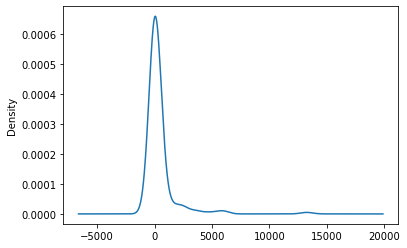

In [13]:
# Visualize the value counts of Destination
destin.plot.density()

In [14]:
# Determine which values to replace with Others
replace_destin = list(destin[destin < 500].index)

# Replace in dataframe
for destinations in replace_destin:
    travel_ins_df.Destination = travel_ins_df.Destination.replace(destinations,"Other")
    
# Check to make sure binning was successful
travel_ins_df.Destination.value_counts()

SINGAPORE                    13255
Other                         6364
MALAYSIA                      5930
THAILAND                      5894
CHINA                         4796
AUSTRALIA                     3694
INDONESIA                     3452
UNITED STATES                 2530
PHILIPPINES                   2490
HONG KONG                     2411
INDIA                         2251
JAPAN                         2061
VIET NAM                      1669
KOREA, REPUBLIC OF            1479
UNITED KINGDOM                1309
TAIWAN, PROVINCE OF CHINA     1090
MYANMAR                        806
BRUNEI DARUSSALAM              780
NEW ZEALAND                    537
CANADA                         528
Name: Destination, dtype: int64

In [15]:
# Transform string column
def change_string(claim):
    if claim == "Yes":
        return 1
    else:
        return 0

travel_ins_df["Claim"] = travel_ins_df["Claim"].apply(change_string)
print(travel_ins_df.shape)
travel_ins_df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,65,AUSTRALIA,-49.5,29.70,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,60,AUSTRALIA,-39.6,23.76,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,79,Other,-19.8,11.88,41
...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,0,111,JAPAN,35.0,12.25,31
63322,JZI,Airlines,Online,Basic Plan,0,58,CHINA,40.0,14.00,40
63323,JZI,Airlines,Online,Basic Plan,0,2,MALAYSIA,18.0,6.30,57
63324,JZI,Airlines,Online,Basic Plan,0,3,VIET NAM,18.0,6.30,63


In [33]:
# Saving cleaned data
file_path = "travel_insurance_clean.csv"
travel_ins_df.to_csv(file_path, index=False)

# Playing around

In [16]:
# Generate new categorical variable lists
travel_cat2 = travel_ins_df.dtypes[travel_ins_df.dtypes == "object"].index.tolist()

In [17]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(travel_ins_df[travel_cat2]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(travel_cat2)
encode_df.head()

,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,Agency_CWT,Agency_EPX,Agency_JWT,Agency_JZI,...,Destination_MYANMAR,Destination_NEW ZEALAND,Destination_Other,Destination_PHILIPPINES,Destination_SINGAPORE,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_THAILAND,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_VIET NAM
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Merge one-hot encoded features and drop the originals
travel_ins_df = travel_ins_df.merge(encode_df,left_index=True, right_index=True)
travel_ins_df = travel_ins_df.drop(travel_cat2,1)
travel_ins_df.head()

C:\Users\lilii\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Claim,Duration,Net Sales,Commision (in value),Age,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,...,Destination_MYANMAR,Destination_NEW ZEALAND,Destination_Other,Destination_PHILIPPINES,Destination_SINGAPORE,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_THAILAND,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_VIET NAM
0,0,186,-29.0,9.57,81,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,186,-29.0,9.57,71,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,65,-49.5,29.70,32,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,60,-39.6,23.76,32,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,79,-19.8,11.88,41,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Split our preprocessed data into our features and target arrays
y = travel_ins_df.Claim
X = travel_ins_df.drop(columns=["Claim"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [22]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [23]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = number_input_features*3
hidden_nodes_layer2 = hidden_nodes_layer1*0.75

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 210)               14910     
                                                                 
 dense_1 (Dense)             (None, 157)               33127     
                                                                 
 dense_2 (Dense)             (None, 1)                 158       
                                                                 
Total params: 48,195
Trainable params: 48,195
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [30]:
# Create a callback that saves the model's weights every 5 epochs.
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

In [31]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
   1/1485 [..............................] - ETA: 13:53 - loss: 6.4126 - accuracy: 0.0000e+00
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
  10/1485 [..............................] - ETA: 11s - loss: 1.1952 - accuracy: 0.8250      
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
  20/1485 [..............................] - ETA: 9s - loss: 0.8198 - accuracy: 0.9078 
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
  31/1485 [..............................] - ETA: 8s - loss: 0.6751 - accuracy: 0.9375
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
  40/1485 [..............................] - ETA: 8s - loss: 0.8629 - accuracy: 0.9445
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
  5

 415/1485 [=======>......................] - ETA: 6s - loss: 0.1916 - accuracy: 0.9799
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 425/1485 [=======>......................] - ETA: 6s - loss: 0.1904 - accuracy: 0.9796
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 435/1485 [=======>......................] - ETA: 6s - loss: 0.1887 - accuracy: 0.9797
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 445/1485 [=======>......................] - ETA: 6s - loss: 0.1853 - accuracy: 0.9801
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 455/1485 [========>.....................] - ETA: 6s - loss: 0.1848 - accuracy: 0.9801
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 465/1485 [========>..........

 880/1485 [================>.............] - ETA: 3s - loss: 0.1448 - accuracy: 0.9810
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 895/1485 [=================>............] - ETA: 3s - loss: 0.1447 - accuracy: 0.9809
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 907/1485 [=================>............] - ETA: 3s - loss: 0.1443 - accuracy: 0.9808
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 920/1485 [=================>............] - ETA: 2s - loss: 0.1434 - accuracy: 0.9810
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
 935/1485 [=================>............] - ETA: 2s - loss: 0

1345/1485 [==========================>...] - ETA: 0s - loss: 0.1235 - accuracy: 0.9819
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
1355/1485 [==========================>...] - ETA: 0s - loss: 0.1233 - accuracy: 0.9819
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.1227 - accuracy: 0.9820
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.1224 - accuracy: 0.9820
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.1218 - accuracy: 0.9820
Epoch 1: saving model to checkpoints\weights.01.hdf5

Epoch 1: saving model to checkpoints\weights.01.hdf5
1395/1485 [===================


Epoch 2: saving model to checkpoints\weights.02.hdf5
 305/1485 [=====>........................] - ETA: 5s - loss: 0.0710 - accuracy: 0.9857
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
 315/1485 [=====>........................] - ETA: 5s - loss: 0.0723 - accuracy: 0.9854
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
 325/1485 [=====>........................] - ETA: 5s - loss: 0.0712 - accuracy: 0.9857
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
 335/1485 [=====>........................] - ETA: 5s - loss: 0.0718 - accuracy: 0.9853
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
 350/1485 [======>.......................] - ETA: 5s - loss: 0.0733 - accuracy: 0.9849
Epoch 2: saving model to chec

 735/1485 [=============>................] - ETA: 3s - loss: 0.0743 - accuracy: 0.9848
Epoch 2: saving model to checkpoints\weights.02.hdf5
 742/1485 [=============>................] - ETA: 3s - loss: 0.0744 - accuracy: 0.9848
Epoch 2: saving model to checkpoints\weights.02.hdf5
 745/1485 [==============>...............] - ETA: 3s - loss: 0.0743 - accuracy: 0.9848
Epoch 2: saving model to checkpoints\weights.02.hdf5
 754/1485 [==============>...............] - ETA: 3s - loss: 0.0753 - accuracy: 0.9845
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
 760/1485 [==============>...............] - ETA: 3s - loss: 0.0752 - accuracy: 0.9845
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
 770/1485 [==============>...............] - ETA: 3s - loss: 0.0758 - accuracy: 0.9843
Epoch 2: saving model to checkpoints\weights.02.hdf5
 776/1485 [==============>...............] - ETA: 3s

1135/1485 [=====================>........] - ETA: 1s - loss: 0.0743 - accuracy: 0.9845
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
1145/1485 [======================>.......] - ETA: 1s - loss: 0.0745 - accuracy: 0.9844
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
1155/1485 [======================>.......] - ETA: 1s - loss: 0.0748 - accuracy: 0.9844
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
1165/1485 [======================>.......] - ETA: 1s - loss: 0.0745 - accuracy: 0.9844
Epoch 2: saving model to checkpoints\weights.02.hdf5

Epoch 2: saving model to checkpoints\weights.02.hdf5
1175/1485 [======================>.......] - ETA: 1s - loss: 0.0743 - accuracy: 0.9845
Epoch 2: saving model to checkpoints\weights.02.hdf5
1183/1485 [======================>.......] - ETA: 1s - loss: 0.0741 - accuracy: 0.98

  70/1485 [>.............................] - ETA: 8s - loss: 0.0630 - accuracy: 0.9866
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
  83/1485 [>.............................] - ETA: 7s - loss: 0.0674 - accuracy: 0.9853
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
  95/1485 [>.............................] - ETA: 7s - loss: 0.0645 - accuracy: 0.9852
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 107/1485 [=>............................] - ETA: 7s - loss: 0.0639 - accuracy: 0.9851
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 115/1485 [=>............................] - ETA: 7s - loss: 0.0655 - accuracy: 0.9851
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to chec

 508/1485 [=========>....................] - ETA: 5s - loss: 0.0673 - accuracy: 0.9840
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 520/1485 [=========>....................] - ETA: 4s - loss: 0.0672 - accuracy: 0.9841
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 531/1485 [=========>....................] - ETA: 4s - loss: 0.0678 - accuracy: 0.9839
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 541/1485 [=========>....................] - ETA: 4s - loss: 0.0675 - accuracy: 0.9841
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 551/1485 [==========>...................] - ETA: 4s - loss: 0.0679 - accuracy: 0.9839
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to chec

 936/1485 [=================>............] - ETA: 2s - loss: 0.0699 - accuracy: 0.9844
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 945/1485 [==================>...........] - ETA: 2s - loss: 0.0697 - accuracy: 0.9845
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 955/1485 [==================>...........] - ETA: 2s - loss: 0.0694 - accuracy: 0.9845
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 967/1485 [==================>...........] - ETA: 2s - loss: 0.0688 - accuracy: 0.9846
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
 978/1485 [==================>...........] - ETA: 2s - loss: 0.0683 - accuracy: 0.9848
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to chec

1355/1485 [==========================>...] - ETA: 0s - loss: 0.0679 - accuracy: 0.9850
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.0681 - accuracy: 0.9850
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.0680 - accuracy: 0.9850
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0681 - accuracy: 0.9850
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
1395/1485 [===========================>..] - ETA: 0s - loss: 0.0680 - accuracy: 0.9850
Epoch 3: saving model to checkpoints\weights.03.hdf5

Epoch 3: saving model to checkpoints\weights.03.hdf5
1405/1485 [===================


Epoch 4: saving model to checkpoints\weights.04.hdf5
 270/1485 [====>.........................] - ETA: 8s - loss: 0.0712 - accuracy: 0.9844
Epoch 4: saving model to checkpoints\weights.04.hdf5
 277/1485 [====>.........................] - ETA: 8s - loss: 0.0723 - accuracy: 0.9841
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 285/1485 [====>.........................] - ETA: 8s - loss: 0.0721 - accuracy: 0.9841
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 295/1485 [====>.........................] - ETA: 8s - loss: 0.0720 - accuracy: 0.9841
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 305/1485 [=====>........................] - ETA: 8s - loss: 0.0727 - accuracy: 0.9838
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 315/1485 [=====>.............

 680/1485 [============>.................] - ETA: 5s - loss: 0.0700 - accuracy: 0.9846
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 690/1485 [============>.................] - ETA: 5s - loss: 0.0703 - accuracy: 0.9846
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 701/1485 [=============>................] - ETA: 5s - loss: 0.0700 - accuracy: 0.9846
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 710/1485 [=============>................] - ETA: 5s - loss: 0.0698 - accuracy: 0.9847
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 720/1485 [=============>................] - ETA: 5s - loss: 0.0694 - accuracy: 0.9848
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
 730/1485 [=============>.....


Epoch 4: saving model to checkpoints\weights.04.hdf5
1112/1485 [=====================>........] - ETA: 2s - loss: 0.0688 - accuracy: 0.9847
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
1124/1485 [=====================>........] - ETA: 2s - loss: 0.0690 - accuracy: 0.9846
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
1134/1485 [=====================>........] - ETA: 2s - loss: 0.0690 - accuracy: 0.9847
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
1145/1485 [======================>.......] - ETA: 2s - loss: 0.0688 - accuracy: 0.9847
Epoch 4: saving model to checkpoints\weights.04.hdf5

Epoch 4: saving model to checkpoints\weights.04.hdf5
1157/1485 [======================>.......] - ETA: 2s - loss: 0.0685 - accuracy: 0.9848
Epoch 4: saving model to chec


Epoch 5: saving model to checkpoints\weights.05.hdf5
  60/1485 [>.............................] - ETA: 8s - loss: 0.0623 - accuracy: 0.9859
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
  70/1485 [>.............................] - ETA: 8s - loss: 0.0670 - accuracy: 0.9848
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
  80/1485 [>.............................] - ETA: 8s - loss: 0.0655 - accuracy: 0.9852
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
  90/1485 [>.............................] - ETA: 8s - loss: 0.0691 - accuracy: 0.9847
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 100/1485 [=>............................] - ETA: 8s - loss: 0.0722 - accuracy: 0.9831
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to chec

 475/1485 [========>.....................] - ETA: 5s - loss: 0.0681 - accuracy: 0.9851
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 485/1485 [========>.....................] - ETA: 5s - loss: 0.0675 - accuracy: 0.9853
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 497/1485 [=========>....................] - ETA: 5s - loss: 0.0664 - accuracy: 0.9855
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 505/1485 [=========>....................] - ETA: 5s - loss: 0.0664 - accuracy: 0.9856
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 515/1485 [=========>....................] - ETA: 5s - loss: 0.0663 - accuracy: 0.9856
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 526/1485 [=========>.........

 910/1485 [=================>............] - ETA: 3s - loss: 0.0667 - accuracy: 0.9853
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 920/1485 [=================>............] - ETA: 3s - loss: 0.0665 - accuracy: 0.9854
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 935/1485 [=================>............] - ETA: 3s - loss: 0.0664 - accuracy: 0.9855
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 949/1485 [==================>...........] - ETA: 2s - loss: 0.0661 - accuracy: 0.9855
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
 959/1485 [==================>...........] - ETA: 2s - loss: 0.0657 - accuracy: 0.9856
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to chec

1340/1485 [==========================>...] - ETA: 0s - loss: 0.0660 - accuracy: 0.9856
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
1351/1485 [==========================>...] - ETA: 0s - loss: 0.0661 - accuracy: 0.9855
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
1364/1485 [==========================>...] - ETA: 0s - loss: 0.0661 - accuracy: 0.9855
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.0661 - accuracy: 0.9855
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to checkpoints\weights.05.hdf5
1389/1485 [===========================>..] - ETA: 0s - loss: 0.0661 - accuracy: 0.9856
Epoch 5: saving model to checkpoints\weights.05.hdf5

Epoch 5: saving model to chec

 295/1485 [====>.........................] - ETA: 5s - loss: 0.0678 - accuracy: 0.9854
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 310/1485 [=====>........................] - ETA: 5s - loss: 0.0672 - accuracy: 0.9854
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 320/1485 [=====>........................] - ETA: 5s - loss: 0.0660 - accuracy: 0.9856
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 330/1485 [=====>........................] - ETA: 5s - loss: 0.0668 - accuracy: 0.9854
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 342/1485 [=====>........................] - ETA: 5s - loss: 0.0654 - accuracy: 0.9857
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to chec


Epoch 6: saving model to checkpoints\weights.06.hdf5
 750/1485 [==============>...............] - ETA: 3s - loss: 0.0630 - accuracy: 0.9862
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 761/1485 [==============>...............] - ETA: 3s - loss: 0.0630 - accuracy: 0.9863
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 774/1485 [==============>...............] - ETA: 3s - loss: 0.0624 - accuracy: 0.9864
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 785/1485 [==============>...............] - ETA: 3s - loss: 0.0630 - accuracy: 0.9863
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
 796/1485 [===============>..............] - ETA: 3s - loss: 0.0631 - accuracy: 0.9863
Epoch 6: saving model to chec

1198/1485 [=======================>......] - ETA: 1s - loss: 0.0656 - accuracy: 0.9856
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
1210/1485 [=======================>......] - ETA: 1s - loss: 0.0656 - accuracy: 0.9856
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
1225/1485 [=======================>......] - ETA: 1s - loss: 0.0658 - accuracy: 0.9855
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
1237/1485 [=======================>......] - ETA: 1s - loss: 0.0657 - accuracy: 0.9855
Epoch 6: saving model to checkpoints\weights.06.hdf5

Epoch 6: saving model to checkpoints\weights.06.hdf5
1248/1485 [========================>.....] - ETA: 1s - loss: 0.0660 - accuracy: 0.9854
Epoch 6: saving model to chec


Epoch 7: saving model to checkpoints\weights.07.hdf5
 167/1485 [==>...........................] - ETA: 6s - loss: 0.0747 - accuracy: 0.9837
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 180/1485 [==>...........................] - ETA: 6s - loss: 0.0759 - accuracy: 0.9833
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 190/1485 [==>...........................] - ETA: 6s - loss: 0.0754 - accuracy: 0.9834
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 201/1485 [===>..........................] - ETA: 6s - loss: 0.0744 - accuracy: 0.9835
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 212/1485 [===>..........................] - ETA: 6s - loss: 0.0740 - accuracy: 0.9836
Epoch 7: saving model to chec


Epoch 7: saving model to checkpoints\weights.07.hdf5
 625/1485 [===========>..................] - ETA: 4s - loss: 0.0686 - accuracy: 0.9844
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 639/1485 [===========>..................] - ETA: 3s - loss: 0.0675 - accuracy: 0.9846
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 650/1485 [============>.................] - ETA: 3s - loss: 0.0683 - accuracy: 0.9844
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 660/1485 [============>.................] - ETA: 3s - loss: 0.0685 - accuracy: 0.9844
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
 670/1485 [============>.................] - ETA: 3s - loss: 0.0684 - accuracy: 0.9844
Epoch 7: saving model to chec

1075/1485 [====================>.........] - ETA: 1s - loss: 0.0660 - accuracy: 0.9851
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
1088/1485 [====================>.........] - ETA: 1s - loss: 0.0658 - accuracy: 0.9852
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
1100/1485 [=====================>........] - ETA: 1s - loss: 0.0654 - accuracy: 0.9853
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
1110/1485 [=====================>........] - ETA: 1s - loss: 0.0661 - accuracy: 0.9852
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to checkpoints\weights.07.hdf5
1120/1485 [=====================>........] - ETA: 1s - loss: 0.0658 - accuracy: 0.9853
Epoch 7: saving model to checkpoints\weights.07.hdf5

Epoch 7: saving model to chec

  20/1485 [..............................] - ETA: 9s - loss: 0.0629 - accuracy: 0.9875
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
  30/1485 [..............................] - ETA: 9s - loss: 0.0664 - accuracy: 0.9854
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
  40/1485 [..............................] - ETA: 9s - loss: 0.0655 - accuracy: 0.9852
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
  50/1485 [>.............................] - ETA: 8s - loss: 0.0640 - accuracy: 0.9856
Epoch 8: saving model to checkpoints\weights.08.hdf5
  58/1485 [>.............................] - ETA: 8s - loss: 0.0711 - accuracy: 0.9844
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
  65/1485 [>.............................] - ETA: 8s - loss: 0.0718 - accuracy: 0.98


Epoch 8: saving model to checkpoints\weights.08.hdf5
 460/1485 [========>.....................] - ETA: 5s - loss: 0.0694 - accuracy: 0.9841
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 470/1485 [========>.....................] - ETA: 5s - loss: 0.0695 - accuracy: 0.9840
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 484/1485 [========>.....................] - ETA: 5s - loss: 0.0689 - accuracy: 0.9842
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 495/1485 [=========>....................] - ETA: 5s - loss: 0.0680 - accuracy: 0.9844
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 508/1485 [=========>....................] - ETA: 5s - loss: 0.0694 - accuracy: 0.9841
Epoch 8: saving model to chec


Epoch 8: saving model to checkpoints\weights.08.hdf5
 905/1485 [=================>............] - ETA: 3s - loss: 0.0651 - accuracy: 0.9854
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 917/1485 [=================>............] - ETA: 2s - loss: 0.0654 - accuracy: 0.9853
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 930/1485 [=================>............] - ETA: 2s - loss: 0.0657 - accuracy: 0.9852
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 941/1485 [==================>...........] - ETA: 2s - loss: 0.0656 - accuracy: 0.9853
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
 950/1485 [==================>...........] - ETA: 2s - loss: 0.0655 - accuracy: 0.9853
Epoch 8: saving model to chec

1350/1485 [==========================>...] - ETA: 0s - loss: 0.0647 - accuracy: 0.9854
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
1363/1485 [==========================>...] - ETA: 0s - loss: 0.0651 - accuracy: 0.9853
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
1374/1485 [==========================>...] - ETA: 0s - loss: 0.0651 - accuracy: 0.9853
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
1384/1485 [==========================>...] - ETA: 0s - loss: 0.0651 - accuracy: 0.9853
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to checkpoints\weights.08.hdf5
1395/1485 [===========================>..] - ETA: 0s - loss: 0.0650 - accuracy: 0.9853
Epoch 8: saving model to checkpoints\weights.08.hdf5

Epoch 8: saving model to chec

 315/1485 [=====>........................] - ETA: 5s - loss: 0.0652 - accuracy: 0.9849
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 328/1485 [=====>........................] - ETA: 5s - loss: 0.0646 - accuracy: 0.9850
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 338/1485 [=====>........................] - ETA: 5s - loss: 0.0651 - accuracy: 0.9848
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 348/1485 [======>.......................] - ETA: 5s - loss: 0.0659 - accuracy: 0.9847
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 360/1485 [======>.......................] - ETA: 5s - loss: 0.0657 - accuracy: 0.9848
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to chec


Epoch 9: saving model to checkpoints\weights.09.hdf5
 784/1485 [==============>...............] - ETA: 3s - loss: 0.0651 - accuracy: 0.9852
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 795/1485 [===============>..............] - ETA: 3s - loss: 0.0654 - accuracy: 0.9852
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 808/1485 [===============>..............] - ETA: 3s - loss: 0.0653 - accuracy: 0.9853
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 820/1485 [===============>..............] - ETA: 3s - loss: 0.0651 - accuracy: 0.9853
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
 835/148

1229/1485 [=======================>......] - ETA: 1s - loss: 0.0647 - accuracy: 0.9854
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
1240/1485 [========================>.....] - ETA: 1s - loss: 0.0645 - accuracy: 0.9854
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
1252/1485 [========================>.....] - ETA: 1s - loss: 0.0642 - accuracy: 0.9855
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
1264/1485 [========================>.....] - ETA: 1s - loss: 0.0638 - accuracy: 0.9856
Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5

Epoch 9: saving model to checkpoints\weights.09.hdf5
1275/1485 [========================>.....] - ETA: 1s - loss: 0.0640 - accuracy: 0.9856
Epoch 9: saving model to chec

 183/1485 [==>...........................] - ETA: 6s - loss: 0.0624 - accuracy: 0.9853
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 195/1485 [==>...........................] - ETA: 6s - loss: 0.0638 - accuracy: 0.9851
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 209/1485 [===>..........................] - ETA: 6s - loss: 0.0640 - accuracy: 0.9850
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 220/1485 [===>..........................] - ETA: 6s - loss: 0.0638 - accuracy: 0.9849
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 235/1485 [===>..........................] - ETA: 5

 642/1485 [===========>..................] - ETA: 3s - loss: 0.0622 - accuracy: 0.9860
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 651/1485 [============>.................] - ETA: 3s - loss: 0.0622 - accuracy: 0.9859
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 665/1485 [============>.................] - ETA: 3s - loss: 0.0627 - accuracy: 0.9858
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 679/1485 [============>.................] - ETA: 3s - loss: 0.0631 - accuracy: 0.9856
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
 690/1485 [============>.................] - ETA: 3s - loss: 0.0626 - accuracy: 0.9858
Epoch 10: saving mo

1077/1485 [====================>.........] - ETA: 1s - loss: 0.0628 - accuracy: 0.9858
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
1088/1485 [====================>.........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9858
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
1098/1485 [=====================>........] - ETA: 1s - loss: 0.0628 - accuracy: 0.9858
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
1110/1485 [=====================>........] - ETA: 1s - loss: 0.0631 - accuracy: 0.9857
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving model to checkpoints\weights.10.hdf5
1120/1485 [=====================>........] - ETA: 1s - loss: 0.0629 - accuracy: 0.9858
Epoch 10: saving model to checkpoints\weights.10.hdf5

Epoch 10: saving mo

   1/1485 [..............................] - ETA: 7s - loss: 0.0235 - accuracy: 1.0000
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
  11/1485 [..............................] - ETA: 7s - loss: 0.0481 - accuracy: 0.9886
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
  20/1485 [..............................] - ETA: 8s - loss: 0.0473 - accuracy: 0.9875
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
  30/1485 [..............................] - ETA: 8s - loss: 0.0566 - accuracy: 0.9854
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
  40/1485 [..............................] - ETA: 8s - loss: 0.0603 - accuracy: 0.9844
Epoch 11: saving model to checkpoints\weights.11.hdf5
  47/1485 [..............................] - ETA: 8s - loss: 0.0569 - accur

 410/1485 [=======>......................] - ETA: 6s - loss: 0.0633 - accuracy: 0.9855
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 422/1485 [=======>......................] - ETA: 6s - loss: 0.0629 - accuracy: 0.9856
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 433/1485 [=======>......................] - ETA: 6s - loss: 0.0624 - accuracy: 0.9858
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 441/1485 [=======>......................] - ETA: 6s - loss: 0.0634 - accuracy: 0.9855
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 452/1485 [========>.....................] - ETA: 5s - loss: 0.0629 - accuracy: 0.9856
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving mo

 830/1485 [===============>..............] - ETA: 3s - loss: 0.0655 - accuracy: 0.9854
Epoch 11: saving model to checkpoints\weights.11.hdf5
 837/1485 [===============>..............] - ETA: 3s - loss: 0.0656 - accuracy: 0.9853
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 845/1485 [================>.............] - ETA: 3s - loss: 0.0655 - accuracy: 0.9854
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 855/1485 [================>.............] - ETA: 3s - loss: 0.0654 - accuracy: 0.9854
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 865/1485 [================>.............] - ETA: 3s - loss: 0.0654 - accuracy: 0.9854
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
 875/1485 [================>.............] - ETA: 3s - loss: 0.0652 - accur

1235/1485 [=======================>......] - ETA: 1s - loss: 0.0641 - accuracy: 0.9856
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
1245/1485 [========================>.....] - ETA: 1s - loss: 0.0640 - accuracy: 0.9856
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0639 - accuracy: 0.9856
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
1265/1485 [========================>.....] - ETA: 1s - loss: 0.0641 - accuracy: 0.9855
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
1275/1485 [========================>.....] - ETA: 1s - loss: 0.0643 - accuracy: 0.9855
Epoch 11: saving model to checkpoints\weights.11.hdf5

Epoch 11: saving model to checkpoints\weights.11.hdf5
1285/1485 [=========

 150/1485 [==>...........................] - ETA: 8s - loss: 0.0658 - accuracy: 0.9848
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 160/1485 [==>...........................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9855
Epoch 12: saving model to checkpoints\weights.12.hdf5
 165/1485 [==>...........................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9856
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 175/1485 [==>...........................] - ETA: 8s - loss: 0.0611 - accuracy: 0.9861
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 185/1485 [==>...........................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9863
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 195/1485 [==>...........................] - ETA: 8s - loss: 0.0610 - accur

 520/1485 [=========>....................] - ETA: 7s - loss: 0.0601 - accuracy: 0.9864
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 530/1485 [=========>....................] - ETA: 7s - loss: 0.0596 - accuracy: 0.9865
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 540/1485 [=========>....................] - ETA: 6s - loss: 0.0591 - accuracy: 0.9867
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 550/1485 [==========>...................] - ETA: 6s - loss: 0.0598 - accuracy: 0.9865
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 560/1485 [==========>...................] - ETA: 6s - loss: 0.0603 - accuracy: 0.9864
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 570/1485 [=========

 935/1485 [=================>............] - ETA: 3s - loss: 0.0628 - accuracy: 0.9856
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 945/1485 [==================>...........] - ETA: 3s - loss: 0.0628 - accuracy: 0.9856
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 955/1485 [==================>...........] - ETA: 3s - loss: 0.0628 - accuracy: 0.9856
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 965/1485 [==================>...........] - ETA: 3s - loss: 0.0626 - accuracy: 0.9857
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 975/1485 [==================>...........] - ETA: 3s - loss: 0.0633 - accuracy: 0.9855
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
 985/1485 [=========


Epoch 12: saving model to checkpoints\weights.12.hdf5
1350/1485 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9857
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
1360/1485 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9857
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
1370/1485 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9857
Epoch 12: saving model to checkpoints\weights.12.hdf5
1377/1485 [==========================>...] - ETA: 0s - loss: 0.0629 - accuracy: 0.9856
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 0.9856
Epoch 12: saving model to checkpoints\weights.12.hdf5

Epoch 12: saving model to checkpoints\weights.12.hdf5
1395/1485 [=========

 260/1485 [====>.........................] - ETA: 7s - loss: 0.0618 - accuracy: 0.9858
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 270/1485 [====>.........................] - ETA: 7s - loss: 0.0613 - accuracy: 0.9859
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 280/1485 [====>.........................] - ETA: 7s - loss: 0.0603 - accuracy: 0.9862
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 290/1485 [====>.........................] - ETA: 7s - loss: 0.0598 - accuracy: 0.9863
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 300/1485 [=====>........................] - ETA: 7s - loss: 0.0598 - accuracy: 0.9865
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 310/1485 [=====>...

 670/1485 [============>.................] - ETA: 4s - loss: 0.0611 - accuracy: 0.9861
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 680/1485 [============>.................] - ETA: 4s - loss: 0.0614 - accuracy: 0.9860
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 690/1485 [============>.................] - ETA: 4s - loss: 0.0611 - accuracy: 0.9861
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 700/1485 [=============>................] - ETA: 4s - loss: 0.0616 - accuracy: 0.9859
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 711/1485 [=============>................] - ETA: 4s - loss: 0.0623 - accuracy: 0.9858
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
 720/1485 [=========

1090/1485 [=====================>........] - ETA: 2s - loss: 0.0636 - accuracy: 0.9854
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
1100/1485 [=====================>........] - ETA: 2s - loss: 0.0632 - accuracy: 0.9855
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
1110/1485 [=====================>........] - ETA: 2s - loss: 0.0630 - accuracy: 0.9856
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
1120/1485 [=====================>........] - ETA: 2s - loss: 0.0626 - accuracy: 0.9857
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
1130/1485 [=====================>........] - ETA: 2s - loss: 0.0627 - accuracy: 0.9857
Epoch 13: saving model to checkpoints\weights.13.hdf5

Epoch 13: saving model to checkpoints\weights.13.hdf5
1140/1485 [=========


Epoch 14: saving model to checkpoints\weights.14.hdf5
  13/1485 [..............................] - ETA: 6s - loss: 0.0585 - accuracy: 0.9856
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
  20/1485 [..............................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9844
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
  30/1485 [..............................] - ETA: 7s - loss: 0.0691 - accuracy: 0.9812
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
  40/1485 [..............................] - ETA: 7s - loss: 0.0707 - accuracy: 0.9805
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
  50/1485 [>.............................] - ETA: 8s - loss: 0.0759 - accuracy: 0.9794
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving mo


Epoch 14: saving model to checkpoints\weights.14.hdf5
 420/1485 [=======>......................] - ETA: 6s - loss: 0.0615 - accuracy: 0.9858
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 430/1485 [=======>......................] - ETA: 6s - loss: 0.0617 - accuracy: 0.9857
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 440/1485 [=======>......................] - ETA: 6s - loss: 0.0621 - accuracy: 0.9854
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 450/1485 [========>.....................] - ETA: 6s - loss: 0.0622 - accuracy: 0.9855
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 460/1485 [========>.....................] - ETA: 6s - loss: 0.0617 - accuracy: 0.9856
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving mo

 835/1485 [===============>..............] - ETA: 3s - loss: 0.0633 - accuracy: 0.9853
Epoch 14: saving model to checkpoints\weights.14.hdf5
 841/1485 [===============>..............] - ETA: 3s - loss: 0.0634 - accuracy: 0.9853
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 850/1485 [================>.............] - ETA: 3s - loss: 0.0633 - accuracy: 0.9853
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 860/1485 [================>.............] - ETA: 3s - loss: 0.0634 - accuracy: 0.9852
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 870/1485 [================>.............] - ETA: 3s - loss: 0.0635 - accuracy: 0.9852
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
 880/1485 [================>.............] - ETA: 3s - loss: 0.0633 - accur

1230/1485 [=======================>......] - ETA: 1s - loss: 0.0637 - accuracy: 0.9854
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
1240/1485 [========================>.....] - ETA: 1s - loss: 0.0637 - accuracy: 0.9854
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
1250/1485 [========================>.....] - ETA: 1s - loss: 0.0637 - accuracy: 0.9854
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
1260/1485 [========================>.....] - ETA: 1s - loss: 0.0637 - accuracy: 0.9854
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
1270/1485 [========================>.....] - ETA: 1s - loss: 0.0639 - accuracy: 0.9854
Epoch 14: saving model to checkpoints\weights.14.hdf5

Epoch 14: saving model to checkpoints\weights.14.hdf5
1280/1485 [=========


Epoch 15: saving model to checkpoints\weights.15.hdf5
 125/1485 [=>............................] - ETA: 9s - loss: 0.0545 - accuracy: 0.9883
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 135/1485 [=>............................] - ETA: 9s - loss: 0.0540 - accuracy: 0.9882
Epoch 15: saving model to checkpoints\weights.15.hdf5
 143/1485 [=>............................] - ETA: 9s - loss: 0.0556 - accuracy: 0.9878
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 150/1485 [==>...........................] - ETA: 9s - loss: 0.0542 - accuracy: 0.9881
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 160/1485 [==>...........................] - ETA: 9s - loss: 0.0543 - accuracy: 0.9879
Epoch 15: saving model to checkpoints\weights.15.hdf5
 167/1485 [==>...........................] - ETA: 9s - loss: 0.0552 - accur

 490/1485 [========>.....................] - ETA: 7s - loss: 0.0623 - accuracy: 0.9853
Epoch 15: saving model to checkpoints\weights.15.hdf5
 499/1485 [=========>....................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9855
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 505/1485 [=========>....................] - ETA: 7s - loss: 0.0619 - accuracy: 0.9855
Epoch 15: saving model to checkpoints\weights.15.hdf5
 513/1485 [=========>....................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9855
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 520/1485 [=========>....................] - ETA: 7s - loss: 0.0618 - accuracy: 0.9856
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 530/1485 [=========>....................] - ETA: 7s - loss: 0.0624 - accuracy: 0.9853
Epoch 15: saving model to checkpoints\weigh


Epoch 15: saving model to checkpoints\weights.15.hdf5
 875/1485 [================>.............] - ETA: 4s - loss: 0.0637 - accuracy: 0.9852
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 885/1485 [================>.............] - ETA: 4s - loss: 0.0637 - accuracy: 0.9851
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 895/1485 [=================>............] - ETA: 4s - loss: 0.0634 - accuracy: 0.9852
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 905/1485 [=================>............] - ETA: 4s - loss: 0.0639 - accuracy: 0.9851
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
 915/1485 [=================>............] - ETA: 4s - loss: 0.0637 - accuracy: 0.9852
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving mo


Epoch 15: saving model to checkpoints\weights.15.hdf5
1245/1485 [========================>.....] - ETA: 1s - loss: 0.0638 - accuracy: 0.9852
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0640 - accuracy: 0.9852
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
1265/1485 [========================>.....] - ETA: 1s - loss: 0.0643 - accuracy: 0.9852
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
1275/1485 [========================>.....] - ETA: 1s - loss: 0.0641 - accuracy: 0.9852
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving model to checkpoints\weights.15.hdf5
1285/1485 [========================>.....] - ETA: 1s - loss: 0.0639 - accuracy: 0.9853
Epoch 15: saving model to checkpoints\weights.15.hdf5

Epoch 15: saving mo

 170/1485 [==>...........................] - ETA: 7s - loss: 0.0573 - accuracy: 0.9871
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 180/1485 [==>...........................] - ETA: 7s - loss: 0.0593 - accuracy: 0.9868
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 190/1485 [==>...........................] - ETA: 7s - loss: 0.0591 - accuracy: 0.9867
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 200/1485 [===>..........................] - ETA: 7s - loss: 0.0584 - accuracy: 0.9870
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 210/1485 [===>..........................] - ETA: 7s - loss: 0.0575 - accuracy: 0.9872
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 220/1485 [===>.....

 575/1485 [==========>...................] - ETA: 5s - loss: 0.0627 - accuracy: 0.9853
Epoch 16: saving model to checkpoints\weights.16.hdf5
 584/1485 [==========>...................] - ETA: 5s - loss: 0.0630 - accuracy: 0.9852
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 590/1485 [==========>...................] - ETA: 5s - loss: 0.0632 - accuracy: 0.9852
Epoch 16: saving model to checkpoints\weights.16.hdf5
 599/1485 [===========>..................] - ETA: 5s - loss: 0.0632 - accuracy: 0.9851
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 605/1485 [===========>..................] - ETA: 5s - loss: 0.0635 - accuracy: 0.9850
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 615/1485 [===========>..................] - ETA: 5s - loss: 0.0629 - accuracy: 0.9852
Epoch 16: saving model to checkpoints\weigh

 970/1485 [==================>...........] - ETA: 3s - loss: 0.0620 - accuracy: 0.9856
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 980/1485 [==================>...........] - ETA: 3s - loss: 0.0620 - accuracy: 0.9856
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
 990/1485 [===================>..........] - ETA: 3s - loss: 0.0622 - accuracy: 0.9855
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
1000/1485 [===================>..........] - ETA: 3s - loss: 0.0623 - accuracy: 0.9855
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
1010/1485 [===================>..........] - ETA: 3s - loss: 0.0626 - accuracy: 0.9855
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
1020/1485 [=========


Epoch 16: saving model to checkpoints\weights.16.hdf5
1380/1485 [==========================>...] - ETA: 0s - loss: 0.0631 - accuracy: 0.9855
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
1390/1485 [===========================>..] - ETA: 0s - loss: 0.0629 - accuracy: 0.9855
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
1400/1485 [===========================>..] - ETA: 0s - loss: 0.0632 - accuracy: 0.9854
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
1410/1485 [===========================>..] - ETA: 0s - loss: 0.0635 - accuracy: 0.9853
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving model to checkpoints\weights.16.hdf5
1420/1485 [===========================>..] - ETA: 0s - loss: 0.0636 - accuracy: 0.9853
Epoch 16: saving model to checkpoints\weights.16.hdf5

Epoch 16: saving mo

 290/1485 [====>.........................] - ETA: 7s - loss: 0.0611 - accuracy: 0.9861
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
 300/1485 [=====>........................] - ETA: 7s - loss: 0.0606 - accuracy: 0.9864
Epoch 17: saving model to checkpoints\weights.17.hdf5
 308/1485 [=====>........................] - ETA: 7s - loss: 0.0610 - accuracy: 0.9863
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
 315/1485 [=====>........................] - ETA: 7s - loss: 0.0608 - accuracy: 0.9863
Epoch 17: saving model to checkpoints\weights.17.hdf5
 321/1485 [=====>........................] - ETA: 7s - loss: 0.0612 - accuracy: 0.9862
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
 330/1485 [=====>........................] - ETA: 7s - loss: 0.0617 - accuracy: 0.9861
Epoch 17: saving model to checkpoints\weigh


Epoch 17: saving model to checkpoints\weights.17.hdf5
 690/1485 [============>.................] - ETA: 5s - loss: 0.0642 - accuracy: 0.9852
Epoch 17: saving model to checkpoints\weights.17.hdf5
 696/1485 [=============>................] - ETA: 5s - loss: 0.0639 - accuracy: 0.9853
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
 705/1485 [=============>................] - ETA: 5s - loss: 0.0635 - accuracy: 0.9853
Epoch 17: saving model to checkpoints\weights.17.hdf5
 714/1485 [=============>................] - ETA: 5s - loss: 0.0634 - accuracy: 0.9854
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
 720/1485 [=============>................] - ETA: 5s - loss: 0.0632 - accuracy: 0.9854
Epoch 17: saving model to checkpoints\weights.17.hdf5
 726/1485 [=============>................] - ETA: 5s - loss: 0.0627 - accuracy: 0.9855
Epoch 17: saving model to checkpoints\weigh

1075/1485 [====================>.........] - ETA: 2s - loss: 0.0628 - accuracy: 0.9853
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
1085/1485 [====================>.........] - ETA: 2s - loss: 0.0627 - accuracy: 0.9853
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
1095/1485 [=====================>........] - ETA: 2s - loss: 0.0629 - accuracy: 0.9852
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
1105/1485 [=====================>........] - ETA: 2s - loss: 0.0630 - accuracy: 0.9853
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
1115/1485 [=====================>........] - ETA: 2s - loss: 0.0630 - accuracy: 0.9853
Epoch 17: saving model to checkpoints\weights.17.hdf5

Epoch 17: saving model to checkpoints\weights.17.hdf5
1125/1485 [=========

1485/1485 [==============================] - 10s 7ms/step - loss: 0.0631 - accuracy: 0.9853
Epoch 18/100
   1/1485 [..............................] - ETA: 6s - loss: 0.1319 - accuracy: 0.9688
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
  11/1485 [..............................] - ETA: 7s - loss: 0.0385 - accuracy: 0.9915
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
  20/1485 [..............................] - ETA: 8s - loss: 0.0565 - accuracy: 0.9891
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
  30/1485 [..............................] - ETA: 8s - loss: 0.0606 - accuracy: 0.9865
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
  40/1485 [..............................] - ETA: 7s - loss: 0.0536 - accuracy: 0.9883
Epoch 18: saving model t


Epoch 18: saving model to checkpoints\weights.18.hdf5
 385/1485 [======>.......................] - ETA: 7s - loss: 0.0637 - accuracy: 0.9855
Epoch 18: saving model to checkpoints\weights.18.hdf5
 392/1485 [======>.......................] - ETA: 7s - loss: 0.0632 - accuracy: 0.9857
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 400/1485 [=======>......................] - ETA: 7s - loss: 0.0624 - accuracy: 0.9859
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 410/1485 [=======>......................] - ETA: 7s - loss: 0.0617 - accuracy: 0.9860
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 420/1485 [=======>......................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9860
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 430/1485 [=======>.


Epoch 18: saving model to checkpoints\weights.18.hdf5
 795/1485 [===============>..............] - ETA: 4s - loss: 0.0646 - accuracy: 0.9848
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 805/1485 [===============>..............] - ETA: 4s - loss: 0.0649 - accuracy: 0.9847
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 815/1485 [===============>..............] - ETA: 4s - loss: 0.0650 - accuracy: 0.9847
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 825/1485 [===============>..............] - ETA: 4s - loss: 0.0651 - accuracy: 0.9846
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
 835/1485 [===============>..............] - ETA: 4s - loss: 0.0651 - accuracy: 0.9845
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving mo


Epoch 18: saving model to checkpoints\weights.18.hdf5
1207/1485 [=======================>......] - ETA: 1s - loss: 0.0631 - accuracy: 0.9852
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
1215/1485 [=======================>......] - ETA: 1s - loss: 0.0630 - accuracy: 0.9853
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
1228/1485 [=======================>......] - ETA: 1s - loss: 0.0632 - accuracy: 0.9852
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
1238/1485 [========================>.....] - ETA: 1s - loss: 0.0631 - accuracy: 0.9852
Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5

Epoch 18: saving model to checkpoints\weights.18.hdf5
1250/1485 [========================>.....] - ETA: 1s - loss: 0.0630 - accuracy: 0.9853
Epoch 18: saving mo

 130/1485 [=>............................] - ETA: 7s - loss: 0.0568 - accuracy: 0.9873
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 140/1485 [=>............................] - ETA: 7s - loss: 0.0567 - accuracy: 0.9875
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 150/1485 [==>...........................] - ETA: 7s - loss: 0.0562 - accuracy: 0.9873
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 160/1485 [==>...........................] - ETA: 7s - loss: 0.0579 - accuracy: 0.9869
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 170/1485 [==>...........................] - ETA: 7s - loss: 0.0585 - accuracy: 0.9868
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 180/1485 [==>......

 540/1485 [=========>....................] - ETA: 5s - loss: 0.0584 - accuracy: 0.9866
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 550/1485 [==========>...................] - ETA: 5s - loss: 0.0588 - accuracy: 0.9865
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 560/1485 [==========>...................] - ETA: 5s - loss: 0.0585 - accuracy: 0.9866
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 570/1485 [==========>...................] - ETA: 5s - loss: 0.0587 - accuracy: 0.9866
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 580/1485 [==========>...................] - ETA: 5s - loss: 0.0583 - accuracy: 0.9867
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 590/1485 [=========

 950/1485 [==================>...........] - ETA: 3s - loss: 0.0595 - accuracy: 0.9863
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 960/1485 [==================>...........] - ETA: 3s - loss: 0.0599 - accuracy: 0.9862
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 970/1485 [==================>...........] - ETA: 3s - loss: 0.0602 - accuracy: 0.9862
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 980/1485 [==================>...........] - ETA: 2s - loss: 0.0602 - accuracy: 0.9862
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
 990/1485 [===================>..........] - ETA: 2s - loss: 0.0601 - accuracy: 0.9862
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
1000/1485 [=========


Epoch 19: saving model to checkpoints\weights.19.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.0629 - accuracy: 0.9853
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.0628 - accuracy: 0.9853
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0628 - accuracy: 0.9853
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
1395/1485 [===========================>..] - ETA: 0s - loss: 0.0628 - accuracy: 0.9853
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving model to checkpoints\weights.19.hdf5
1405/1485 [===========================>..] - ETA: 0s - loss: 0.0627 - accuracy: 0.9854
Epoch 19: saving model to checkpoints\weights.19.hdf5

Epoch 19: saving mo


Epoch 20: saving model to checkpoints\weights.20.hdf5
 290/1485 [====>.........................] - ETA: 7s - loss: 0.0621 - accuracy: 0.9859
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 300/1485 [=====>........................] - ETA: 7s - loss: 0.0636 - accuracy: 0.9854
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 310/1485 [=====>........................] - ETA: 7s - loss: 0.0640 - accuracy: 0.9853
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 320/1485 [=====>........................] - ETA: 7s - loss: 0.0637 - accuracy: 0.9854
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 330/1485 [=====>........................] - ETA: 7s - loss: 0.0625 - accuracy: 0.9856
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving mo

 705/1485 [=============>................] - ETA: 4s - loss: 0.0631 - accuracy: 0.9856
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 715/1485 [=============>................] - ETA: 4s - loss: 0.0631 - accuracy: 0.9856
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 725/1485 [=============>................] - ETA: 4s - loss: 0.0633 - accuracy: 0.9856
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 735/1485 [=============>................] - ETA: 4s - loss: 0.0629 - accuracy: 0.9857
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 745/1485 [==============>...............] - ETA: 4s - loss: 0.0626 - accuracy: 0.9858
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
 755/1485 [=========

1103/1485 [=====================>........] - ETA: 2s - loss: 0.0633 - accuracy: 0.9854
Epoch 20: saving model to checkpoints\weights.20.hdf5
1108/1485 [=====================>........] - ETA: 2s - loss: 0.0632 - accuracy: 0.9854
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
1115/1485 [=====================>........] - ETA: 2s - loss: 0.0632 - accuracy: 0.9855
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
1125/1485 [=====================>........] - ETA: 2s - loss: 0.0630 - accuracy: 0.9855
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
1135/1485 [=====================>........] - ETA: 2s - loss: 0.0628 - accuracy: 0.9855
Epoch 20: saving model to checkpoints\weights.20.hdf5

Epoch 20: saving model to checkpoints\weights.20.hdf5
1145/1485 [======================>.......] - ETA: 2s - loss: 0.0636 - accur

  20/1485 [..............................] - ETA: 8s - loss: 0.0457 - accuracy: 0.9906
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
  30/1485 [..............................] - ETA: 8s - loss: 0.0347 - accuracy: 0.9937
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
  40/1485 [..............................] - ETA: 8s - loss: 0.0469 - accuracy: 0.9906
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
  50/1485 [>.............................] - ETA: 8s - loss: 0.0437 - accuracy: 0.9919
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
  60/1485 [>.............................] - ETA: 8s - loss: 0.0444 - accuracy: 0.9911
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
  70/1485 [>........

 395/1485 [======>.......................] - ETA: 7s - loss: 0.0619 - accuracy: 0.9854
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
 405/1485 [=======>......................] - ETA: 7s - loss: 0.0621 - accuracy: 0.9854
Epoch 21: saving model to checkpoints\weights.21.hdf5
 414/1485 [=======>......................] - ETA: 7s - loss: 0.0616 - accuracy: 0.9856
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
 420/1485 [=======>......................] - ETA: 7s - loss: 0.0611 - accuracy: 0.9857
Epoch 21: saving model to checkpoints\weights.21.hdf5
 426/1485 [=======>......................] - ETA: 7s - loss: 0.0610 - accuracy: 0.9858
Epoch 21: saving model to checkpoints\weights.21.hdf5
 434/1485 [=======>......................] - ETA: 7s - loss: 0.0610 - accuracy: 0.9859
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weigh

 749/1485 [==============>...............] - ETA: 5s - loss: 0.0617 - accuracy: 0.9857
Epoch 21: saving model to checkpoints\weights.21.hdf5
 751/1485 [==============>...............] - ETA: 5s - loss: 0.0619 - accuracy: 0.9857
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
 760/1485 [==============>...............] - ETA: 5s - loss: 0.0613 - accuracy: 0.9859
Epoch 21: saving model to checkpoints\weights.21.hdf5
 768/1485 [==============>...............] - ETA: 5s - loss: 0.0609 - accuracy: 0.9860
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
 775/1485 [==============>...............] - ETA: 5s - loss: 0.0607 - accuracy: 0.9860
Epoch 21: saving model to checkpoints\weights.21.hdf5
 784/1485 [==============>...............] - ETA: 5s - loss: 0.0604 - accuracy: 0.9861
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weigh

1131/1485 [=====================>........] - ETA: 2s - loss: 0.0631 - accuracy: 0.9854
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
1140/1485 [======================>.......] - ETA: 2s - loss: 0.0630 - accuracy: 0.9855
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
1150/1485 [======================>.......] - ETA: 2s - loss: 0.0630 - accuracy: 0.9855
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
1160/1485 [======================>.......] - ETA: 2s - loss: 0.0630 - accuracy: 0.9855
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
1170/1485 [======================>.......] - ETA: 2s - loss: 0.0632 - accuracy: 0.9853
Epoch 21: saving model to checkpoints\weights.21.hdf5

Epoch 21: saving model to checkpoints\weights.21.hdf5
1180/1485 [=========

  35/1485 [..............................] - ETA: 10s - loss: 0.0538 - accuracy: 0.9893
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
  45/1485 [..............................] - ETA: 10s - loss: 0.0511 - accuracy: 0.9896
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
  55/1485 [>.............................] - ETA: 9s - loss: 0.0641 - accuracy: 0.9869 
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
  65/1485 [>.............................] - ETA: 9s - loss: 0.0617 - accuracy: 0.9875
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
  75/1485 [>.............................] - ETA: 9s - loss: 0.0605 - accuracy: 0.9883
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
  85/1485 [>.....

 455/1485 [========>.....................] - ETA: 6s - loss: 0.0613 - accuracy: 0.9864
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 465/1485 [========>.....................] - ETA: 6s - loss: 0.0614 - accuracy: 0.9864
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 475/1485 [========>.....................] - ETA: 6s - loss: 0.0613 - accuracy: 0.9864
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 485/1485 [========>.....................] - ETA: 6s - loss: 0.0607 - accuracy: 0.9865
Epoch 22: saving model to checkpoints\weights.22.hdf5
 493/1485 [========>.....................] - ETA: 6s - loss: 0.0603 - accuracy: 0.9867
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 500/1485 [=========>....................] - ETA: 6s - loss: 0.0598 - accur

 865/1485 [================>.............] - ETA: 3s - loss: 0.0633 - accuracy: 0.9853
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 875/1485 [================>.............] - ETA: 3s - loss: 0.0636 - accuracy: 0.9852
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 885/1485 [================>.............] - ETA: 3s - loss: 0.0641 - accuracy: 0.9851
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 895/1485 [=================>............] - ETA: 3s - loss: 0.0644 - accuracy: 0.9850
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 906/1485 [=================>............] - ETA: 3s - loss: 0.0642 - accuracy: 0.9850
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
 915/1485 [=========

1280/1485 [========================>.....] - ETA: 1s - loss: 0.0633 - accuracy: 0.9854
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
1290/1485 [=========================>....] - ETA: 1s - loss: 0.0634 - accuracy: 0.9854
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
1300/1485 [=========================>....] - ETA: 1s - loss: 0.0633 - accuracy: 0.9855
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
1310/1485 [=========================>....] - ETA: 1s - loss: 0.0634 - accuracy: 0.9854
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
1320/1485 [=========================>....] - ETA: 0s - loss: 0.0632 - accuracy: 0.9854
Epoch 22: saving model to checkpoints\weights.22.hdf5

Epoch 22: saving model to checkpoints\weights.22.hdf5
1330/1485 [=========

 200/1485 [===>..........................] - ETA: 7s - loss: 0.0613 - accuracy: 0.9861
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 210/1485 [===>..........................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9860
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 220/1485 [===>..........................] - ETA: 7s - loss: 0.0619 - accuracy: 0.9859
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 230/1485 [===>..........................] - ETA: 7s - loss: 0.0612 - accuracy: 0.9861
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 240/1485 [===>..........................] - ETA: 7s - loss: 0.0610 - accuracy: 0.9862
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 252/1485 [====>....

 605/1485 [===========>..................] - ETA: 5s - loss: 0.0608 - accuracy: 0.9858
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 615/1485 [===========>..................] - ETA: 5s - loss: 0.0611 - accuracy: 0.9857
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 625/1485 [===========>..................] - ETA: 5s - loss: 0.0618 - accuracy: 0.9856
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 635/1485 [===========>..................] - ETA: 5s - loss: 0.0616 - accuracy: 0.9856
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 645/1485 [============>.................] - ETA: 5s - loss: 0.0615 - accuracy: 0.9856
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
 655/1485 [=========

1015/1485 [===================>..........] - ETA: 2s - loss: 0.0620 - accuracy: 0.9854
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1025/1485 [===================>..........] - ETA: 2s - loss: 0.0617 - accuracy: 0.9855
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1035/1485 [===================>..........] - ETA: 2s - loss: 0.0622 - accuracy: 0.9854
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1045/1485 [====================>.........] - ETA: 2s - loss: 0.0622 - accuracy: 0.9854
Epoch 23: saving model to checkpoints\weights.23.hdf5
1052/1485 [====================>.........] - ETA: 2s - loss: 0.0621 - accuracy: 0.9854
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1060/1485 [====================>.........] - ETA: 2s - loss: 0.0622 - accur


Epoch 23: saving model to checkpoints\weights.23.hdf5
1430/1485 [===========================>..] - ETA: 0s - loss: 0.0632 - accuracy: 0.9853
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1440/1485 [============================>.] - ETA: 0s - loss: 0.0633 - accuracy: 0.9852
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1450/1485 [============================>.] - ETA: 0s - loss: 0.0631 - accuracy: 0.9853
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1460/1485 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9853
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving model to checkpoints\weights.23.hdf5
1470/1485 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9853
Epoch 23: saving model to checkpoints\weights.23.hdf5

Epoch 23: saving mo

 335/1485 [=====>........................] - ETA: 7s - loss: 0.0675 - accuracy: 0.9835
Epoch 24: saving model to checkpoints\weights.24.hdf5
 340/1485 [=====>........................] - ETA: 7s - loss: 0.0673 - accuracy: 0.9836
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 350/1485 [======>.......................] - ETA: 7s - loss: 0.0669 - accuracy: 0.9837
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 360/1485 [======>.......................] - ETA: 7s - loss: 0.0665 - accuracy: 0.9838
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 370/1485 [======>.......................] - ETA: 7s - loss: 0.0659 - accuracy: 0.9839
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 380/1485 [======>.......................] - ETA: 7s - loss: 0.0644 - accur

 740/1485 [=============>................] - ETA: 4s - loss: 0.0664 - accuracy: 0.9839
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 750/1485 [==============>...............] - ETA: 4s - loss: 0.0660 - accuracy: 0.9840
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 760/1485 [==============>...............] - ETA: 4s - loss: 0.0663 - accuracy: 0.9840
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 770/1485 [==============>...............] - ETA: 4s - loss: 0.0659 - accuracy: 0.9841
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 780/1485 [==============>...............] - ETA: 4s - loss: 0.0659 - accuracy: 0.9841
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
 790/1485 [=========


Epoch 24: saving model to checkpoints\weights.24.hdf5
1150/1485 [======================>.......] - ETA: 2s - loss: 0.0633 - accuracy: 0.9850
Epoch 24: saving model to checkpoints\weights.24.hdf5
1157/1485 [======================>.......] - ETA: 2s - loss: 0.0633 - accuracy: 0.9850
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
1165/1485 [======================>.......] - ETA: 2s - loss: 0.0634 - accuracy: 0.9850
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
1175/1485 [======================>.......] - ETA: 2s - loss: 0.0633 - accuracy: 0.9850
Epoch 24: saving model to checkpoints\weights.24.hdf5
1181/1485 [======================>.......] - ETA: 2s - loss: 0.0632 - accuracy: 0.9850
Epoch 24: saving model to checkpoints\weights.24.hdf5

Epoch 24: saving model to checkpoints\weights.24.hdf5
1190/1485 [=======================>......] - ETA: 1s - loss: 0.0631 - accur

  60/1485 [>.............................] - ETA: 8s - loss: 0.0506 - accuracy: 0.9891
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
  70/1485 [>.............................] - ETA: 8s - loss: 0.0556 - accuracy: 0.9879
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
  80/1485 [>.............................] - ETA: 8s - loss: 0.0527 - accuracy: 0.9887
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
  90/1485 [>.............................] - ETA: 8s - loss: 0.0540 - accuracy: 0.9885
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 100/1485 [=>............................] - ETA: 8s - loss: 0.0563 - accuracy: 0.9878
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 110/1485 [=>.......

 470/1485 [========>.....................] - ETA: 6s - loss: 0.0622 - accuracy: 0.9854
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 480/1485 [========>.....................] - ETA: 6s - loss: 0.0625 - accuracy: 0.9853
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 490/1485 [========>.....................] - ETA: 6s - loss: 0.0628 - accuracy: 0.9852
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 500/1485 [=========>....................] - ETA: 6s - loss: 0.0624 - accuracy: 0.9854
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 510/1485 [=========>....................] - ETA: 5s - loss: 0.0632 - accuracy: 0.9852
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 520/1485 [=========

 885/1485 [================>.............] - ETA: 3s - loss: 0.0632 - accuracy: 0.9849
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 895/1485 [=================>............] - ETA: 3s - loss: 0.0632 - accuracy: 0.9849
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 905/1485 [=================>............] - ETA: 3s - loss: 0.0628 - accuracy: 0.9850
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 915/1485 [=================>............] - ETA: 3s - loss: 0.0625 - accuracy: 0.9851
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 925/1485 [=================>............] - ETA: 3s - loss: 0.0631 - accuracy: 0.9850
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
 935/1485 [=========

1295/1485 [=========================>....] - ETA: 1s - loss: 0.0632 - accuracy: 0.9851
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
1305/1485 [=========================>....] - ETA: 1s - loss: 0.0633 - accuracy: 0.9851
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
1315/1485 [=========================>....] - ETA: 1s - loss: 0.0633 - accuracy: 0.9851
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
1325/1485 [=========================>....] - ETA: 0s - loss: 0.0632 - accuracy: 0.9851
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
1335/1485 [=========================>....] - ETA: 0s - loss: 0.0632 - accuracy: 0.9851
Epoch 25: saving model to checkpoints\weights.25.hdf5

Epoch 25: saving model to checkpoints\weights.25.hdf5
1345/1485 [=========


Epoch 26: saving model to checkpoints\weights.26.hdf5
 225/1485 [===>..........................] - ETA: 7s - loss: 0.0621 - accuracy: 0.9854
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 235/1485 [===>..........................] - ETA: 7s - loss: 0.0604 - accuracy: 0.9859
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 245/1485 [===>..........................] - ETA: 7s - loss: 0.0597 - accuracy: 0.9861
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 255/1485 [====>.........................] - ETA: 7s - loss: 0.0607 - accuracy: 0.9858
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 265/1485 [====>.........................] - ETA: 7s - loss: 0.0616 - accuracy: 0.9856
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving mo

 635/1485 [===========>..................] - ETA: 5s - loss: 0.0615 - accuracy: 0.9857
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 645/1485 [============>.................] - ETA: 5s - loss: 0.0618 - accuracy: 0.9856
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 655/1485 [============>.................] - ETA: 4s - loss: 0.0616 - accuracy: 0.9857
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 665/1485 [============>.................] - ETA: 4s - loss: 0.0617 - accuracy: 0.9857
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 675/1485 [============>.................] - ETA: 4s - loss: 0.0616 - accuracy: 0.9857
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
 685/1485 [=========

1055/1485 [====================>.........] - ETA: 2s - loss: 0.0628 - accuracy: 0.9855
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
1065/1485 [====================>.........] - ETA: 2s - loss: 0.0627 - accuracy: 0.9855
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
1075/1485 [====================>.........] - ETA: 2s - loss: 0.0624 - accuracy: 0.9856
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
1085/1485 [====================>.........] - ETA: 2s - loss: 0.0622 - accuracy: 0.9856
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
1095/1485 [=====================>........] - ETA: 2s - loss: 0.0619 - accuracy: 0.9857
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
1105/1485 [=========

1470/1485 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9854
Epoch 26: saving model to checkpoints\weights.26.hdf5

Epoch 26: saving model to checkpoints\weights.26.hdf5
1480/1485 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9854
Epoch 26: saving model to checkpoints\weights.26.hdf5
1485/1485 [==============================] - 9s 6ms/step - loss: 0.0628 - accuracy: 0.9853
Epoch 27/100
   1/1485 [..............................] - ETA: 7s - loss: 0.0105 - accuracy: 1.0000
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
  10/1485 [..............................] - ETA: 8s - loss: 0.0667 - accuracy: 0.9844
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
  20/1485 [..............................] - ETA: 8s - loss: 0.0558 - accuracy: 0.9875
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to

 380/1485 [======>.......................] - ETA: 7s - loss: 0.0687 - accuracy: 0.9842
Epoch 27: saving model to checkpoints\weights.27.hdf5
 389/1485 [======>.......................] - ETA: 7s - loss: 0.0683 - accuracy: 0.9843
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 398/1485 [=======>......................] - ETA: 6s - loss: 0.0675 - accuracy: 0.9844
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 405/1485 [=======>......................] - ETA: 6s - loss: 0.0670 - accuracy: 0.9845
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 415/1485 [=======>......................] - ETA: 6s - loss: 0.0676 - accuracy: 0.9842
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 425/1485 [=======>......................] - ETA: 6s - loss: 0.0665 - accur

 790/1485 [==============>...............] - ETA: 4s - loss: 0.0637 - accuracy: 0.9851
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 800/1485 [===============>..............] - ETA: 4s - loss: 0.0639 - accuracy: 0.9850
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 810/1485 [===============>..............] - ETA: 4s - loss: 0.0638 - accuracy: 0.9851
Epoch 27: saving model to checkpoints\weights.27.hdf5
 818/1485 [===============>..............] - ETA: 4s - loss: 0.0639 - accuracy: 0.9850
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 825/1485 [===============>..............] - ETA: 4s - loss: 0.0638 - accuracy: 0.9850
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
 835/1485 [===============>..............] - ETA: 4s - loss: 0.0636 - accur

1160/1485 [======================>.......] - ETA: 2s - loss: 0.0644 - accuracy: 0.9850
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
1170/1485 [======================>.......] - ETA: 2s - loss: 0.0642 - accuracy: 0.9850
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
1180/1485 [======================>.......] - ETA: 2s - loss: 0.0641 - accuracy: 0.9850
Epoch 27: saving model to checkpoints\weights.27.hdf5
1186/1485 [======================>.......] - ETA: 2s - loss: 0.0639 - accuracy: 0.9851
Epoch 27: saving model to checkpoints\weights.27.hdf5
1194/1485 [=======================>......] - ETA: 1s - loss: 0.0637 - accuracy: 0.9852
Epoch 27: saving model to checkpoints\weights.27.hdf5

Epoch 27: saving model to checkpoints\weights.27.hdf5
1200/1485 [=======================>......] - ETA: 1s - loss: 0.0636 - accuracy: 0.9852
Epoch 27: saving model to checkpoints\weigh

  45/1485 [..............................] - ETA: 9s - loss: 0.0609 - accuracy: 0.9861
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
  55/1485 [>.............................] - ETA: 9s - loss: 0.0625 - accuracy: 0.9858
Epoch 28: saving model to checkpoints\weights.28.hdf5
  60/1485 [>.............................] - ETA: 10s - loss: 0.0618 - accuracy: 0.9859
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
  71/1485 [>.............................] - ETA: 9s - loss: 0.0592 - accuracy: 0.9864 
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
  80/1485 [>.............................] - ETA: 9s - loss: 0.0626 - accuracy: 0.9848
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
  91/1485 [>.............................] - ETA: 8s - loss: 0.0632 - acc

 483/1485 [========>.....................] - ETA: 5s - loss: 0.0653 - accuracy: 0.9851
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 490/1485 [========>.....................] - ETA: 5s - loss: 0.0659 - accuracy: 0.9848
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 502/1485 [=========>....................] - ETA: 5s - loss: 0.0656 - accuracy: 0.9849
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 512/1485 [=========>....................] - ETA: 5s - loss: 0.0653 - accuracy: 0.9850
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 520/1485 [=========>....................] - ETA: 5s - loss: 0.0651 - accuracy: 0.9851
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving mo


Epoch 28: saving model to checkpoints\weights.28.hdf5
 920/1485 [=================>............] - ETA: 2s - loss: 0.0649 - accuracy: 0.9847
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 934/1485 [=================>............] - ETA: 2s - loss: 0.0646 - accuracy: 0.9847
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 945/1485 [==================>...........] - ETA: 2s - loss: 0.0649 - accuracy: 0.9847
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 955/1485 [==================>...........] - ETA: 2s - loss: 0.0652 - accuracy: 0.9846
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
 966/1485 [==================>...........] - ETA: 2s - loss: 0.0650 - accuracy: 0.9846
Epoch 28: saving mo

1360/1485 [==========================>...] - ETA: 0s - loss: 0.0632 - accuracy: 0.9852
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
1370/1485 [==========================>...] - ETA: 0s - loss: 0.0632 - accuracy: 0.9852
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
1381/1485 [==========================>...] - ETA: 0s - loss: 0.0633 - accuracy: 0.9852
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
1395/1485 [===========================>..] - ETA: 0s - loss: 0.0630 - accuracy: 0.9852
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving model to checkpoints\weights.28.hdf5
1408/1485 [===========================>..] - ETA: 0s - loss: 0.0629 - accuracy: 0.9853
Epoch 28: saving model to checkpoints\weights.28.hdf5

Epoch 28: saving mo

 310/1485 [=====>........................] - ETA: 5s - loss: 0.0632 - accuracy: 0.9854
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 323/1485 [=====>........................] - ETA: 5s - loss: 0.0644 - accuracy: 0.9852
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 335/1485 [=====>........................] - ETA: 5s - loss: 0.0645 - accuracy: 0.9852
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 349/1485 [======>.......................] - ETA: 5s - loss: 0.0640 - accuracy: 0.9854
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 360/1485 [======>.......................] - ETA: 5s - loss: 0.0635 - accuracy: 0.9855
Epoch 29: saving mo

 755/1485 [==============>...............] - ETA: 3s - loss: 0.0626 - accuracy: 0.9856
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 768/1485 [==============>...............] - ETA: 3s - loss: 0.0623 - accuracy: 0.9857
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 780/1485 [==============>...............] - ETA: 3s - loss: 0.0626 - accuracy: 0.9855
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 793/1485 [===============>..............] - ETA: 3s - loss: 0.0630 - accuracy: 0.9854
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
 805/1485 [===============>..............] - ETA: 3s - loss: 0.0631 - accuracy: 0.9854
Epoch 29: saving mo

1195/1485 [=======================>......] - ETA: 1s - loss: 0.0638 - accuracy: 0.9851
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
1205/1485 [=======================>......] - ETA: 1s - loss: 0.0635 - accuracy: 0.9852
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
1218/1485 [=======================>......] - ETA: 1s - loss: 0.0639 - accuracy: 0.9851
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
1230/1485 [=======================>......] - ETA: 1s - loss: 0.0639 - accuracy: 0.9851
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving model to checkpoints\weights.29.hdf5
1240/1485 [========================>.....] - ETA: 1s - loss: 0.0643 - accuracy: 0.9850
Epoch 29: saving model to checkpoints\weights.29.hdf5

Epoch 29: saving mo

 150/1485 [==>...........................] - ETA: 6s - loss: 0.0537 - accuracy: 0.9877
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 160/1485 [==>...........................] - ETA: 6s - loss: 0.0561 - accuracy: 0.9873
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 175/1485 [==>...........................] - ETA: 6s - loss: 0.0550 - accuracy: 0.9877
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 189/1485 [==>...........................] - ETA: 6s - loss: 0.0565 - accuracy: 0.9871
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 200/1485 [===>..........................] - ETA: 6s - loss: 0.0554 - accuracy: 0.9873
Epoch 30: saving mo

 614/1485 [===========>..................] - ETA: 3s - loss: 0.0590 - accuracy: 0.9860
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 625/1485 [===========>..................] - ETA: 3s - loss: 0.0588 - accuracy: 0.9861
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 638/1485 [===========>..................] - ETA: 3s - loss: 0.0592 - accuracy: 0.9859
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 650/1485 [============>.................] - ETA: 3s - loss: 0.0588 - accuracy: 0.9861
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
 661/1485 [============>.................] - ETA: 3s - loss: 0.0593 - accuracy: 0.9859
Epoch 30: saving mo

1075/1485 [====================>.........] - ETA: 1s - loss: 0.0590 - accuracy: 0.9860
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
1086/1485 [====================>.........] - ETA: 1s - loss: 0.0594 - accuracy: 0.9860
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
1095/1485 [=====================>........] - ETA: 1s - loss: 0.0598 - accuracy: 0.9859
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
1107/1485 [=====================>........] - ETA: 1s - loss: 0.0600 - accuracy: 0.9858
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
1115/1485 [=====================>........] - ETA: 1s - loss: 0.0602 - accuracy: 0.9858
Epoch 30: saving model to checkpoints\weights.30.hdf5

Epoch 30: saving model to checkpoints\weights.30.hdf5
1128/1485 [=========


Epoch 31: saving model to checkpoints\weights.31.hdf5
  45/1485 [..............................] - ETA: 6s - loss: 0.0636 - accuracy: 0.9840
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
  58/1485 [>.............................] - ETA: 6s - loss: 0.0710 - accuracy: 0.9828
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
  70/1485 [>.............................] - ETA: 6s - loss: 0.0675 - accuracy: 0.9839
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
  80/1485 [>.............................] - ETA: 6s - loss: 0.0695 - accuracy: 0.9836
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
  91/1485 [>.............................] - ETA: 6s - loss: 0.0674 - accuracy: 0.9842
Epoch 31: saving mo

 480/1485 [========>.....................] - ETA: 4s - loss: 0.0608 - accuracy: 0.9854
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 491/1485 [========>.....................] - ETA: 4s - loss: 0.0606 - accuracy: 0.9854
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 503/1485 [=========>....................] - ETA: 4s - loss: 0.0612 - accuracy: 0.9852
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 513/1485 [=========>....................] - ETA: 4s - loss: 0.0614 - accuracy: 0.9852
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 523/1485 [=========>....................] - ETA: 4s - loss: 0.0614 - accuracy: 0.9852
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 533/1485 [=========

 893/1485 [=================>............] - ETA: 3s - loss: 0.0604 - accuracy: 0.9858
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 905/1485 [=================>............] - ETA: 3s - loss: 0.0606 - accuracy: 0.9857
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 918/1485 [=================>............] - ETA: 2s - loss: 0.0604 - accuracy: 0.9858
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 929/1485 [=================>............] - ETA: 2s - loss: 0.0603 - accuracy: 0.9859
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
 940/1485 [=================>............] - ETA: 2s - loss: 0.0604 - accuracy: 0.9859
Epoch 31: saving mo

1330/1485 [=========================>....] - ETA: 0s - loss: 0.0621 - accuracy: 0.9854
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
1340/1485 [==========================>...] - ETA: 0s - loss: 0.0621 - accuracy: 0.9854
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
1350/1485 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9855
Epoch 31: saving model to checkpoints\weights.31.hdf5
1358/1485 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9855
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
1367/1485 [==========================>...] - ETA: 0s - loss: 0.0620 - accuracy: 0.9855
Epoch 31: saving model to checkpoints\weights.31.hdf5

Epoch 31: saving model to checkpoints\weights.31.hdf5
1376/1485 [==========================>...] - ETA: 0s - loss: 0.0622 - accur

 240/1485 [===>..........................] - ETA: 8s - loss: 0.0621 - accuracy: 0.9858
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 250/1485 [====>.........................] - ETA: 8s - loss: 0.0627 - accuracy: 0.9858
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 260/1485 [====>.........................] - ETA: 8s - loss: 0.0626 - accuracy: 0.9857
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 270/1485 [====>.........................] - ETA: 8s - loss: 0.0630 - accuracy: 0.9855
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 280/1485 [====>.........................] - ETA: 8s - loss: 0.0624 - accuracy: 0.9857
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 290/1485 [====>....

 650/1485 [============>.................] - ETA: 5s - loss: 0.0613 - accuracy: 0.9857
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 660/1485 [============>.................] - ETA: 5s - loss: 0.0608 - accuracy: 0.9858
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 670/1485 [============>.................] - ETA: 5s - loss: 0.0609 - accuracy: 0.9858
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 680/1485 [============>.................] - ETA: 5s - loss: 0.0606 - accuracy: 0.9859
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 690/1485 [============>.................] - ETA: 5s - loss: 0.0609 - accuracy: 0.9859
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
 700/1485 [=========


Epoch 32: saving model to checkpoints\weights.32.hdf5
1065/1485 [====================>.........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9857
Epoch 32: saving model to checkpoints\weights.32.hdf5
1074/1485 [====================>.........] - ETA: 2s - loss: 0.0610 - accuracy: 0.9857
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
1080/1485 [====================>.........] - ETA: 2s - loss: 0.0609 - accuracy: 0.9857
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
1090/1485 [=====================>........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9857
Epoch 32: saving model to checkpoints\weights.32.hdf5
1099/1485 [=====================>........] - ETA: 2s - loss: 0.0612 - accuracy: 0.9856
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
1105/1485 [=====================>........] - ETA: 2s - loss: 0.0612 - accur

1445/1485 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9854
Epoch 32: saving model to checkpoints\weights.32.hdf5
1450/1485 [============================>.] - ETA: 0s - loss: 0.0624 - accuracy: 0.9853
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
1460/1485 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9854
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
1470/1485 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9854
Epoch 32: saving model to checkpoints\weights.32.hdf5

Epoch 32: saving model to checkpoints\weights.32.hdf5
1480/1485 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9853
Epoch 32: saving model to checkpoints\weights.32.hdf5
1485/1485 [==============================] - 10s 7ms/step - loss: 0.0621 - accuracy: 0.9854
Epoch 33/100
   1/1485 [..............

 355/1485 [======>.......................] - ETA: 7s - loss: 0.0574 - accuracy: 0.9866
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
 365/1485 [======>.......................] - ETA: 7s - loss: 0.0585 - accuracy: 0.9861
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
 375/1485 [======>.......................] - ETA: 7s - loss: 0.0586 - accuracy: 0.9862
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
 385/1485 [======>.......................] - ETA: 7s - loss: 0.0587 - accuracy: 0.9860
Epoch 33: saving model to checkpoints\weights.33.hdf5
 394/1485 [======>.......................] - ETA: 7s - loss: 0.0586 - accuracy: 0.9860
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
 400/1485 [=======>......................] - ETA: 7s - loss: 0.0582 - accur

 765/1485 [==============>...............] - ETA: 4s - loss: 0.0597 - accuracy: 0.9859
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
 775/1485 [==============>...............] - ETA: 4s - loss: 0.0598 - accuracy: 0.9859
Epoch 33: saving model to checkpoints\weights.33.hdf5
 781/1485 [==============>...............] - ETA: 4s - loss: 0.0595 - accuracy: 0.9860
Epoch 33: saving model to checkpoints\weights.33.hdf5
 788/1485 [==============>...............] - ETA: 4s - loss: 0.0595 - accuracy: 0.9860
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
 795/1485 [===============>..............] - ETA: 4s - loss: 0.0594 - accuracy: 0.9860
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
 805/1485 [===============>..............] - ETA: 4s - loss: 0.0589 - accuracy: 0.9861
Epoch 33: saving model to checkpoints\weigh

1158/1485 [======================>.......] - ETA: 2s - loss: 0.0613 - accuracy: 0.9855
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
1165/1485 [======================>.......] - ETA: 2s - loss: 0.0614 - accuracy: 0.9855
Epoch 33: saving model to checkpoints\weights.33.hdf5
1170/1485 [======================>.......] - ETA: 2s - loss: 0.0613 - accuracy: 0.9855
Epoch 33: saving model to checkpoints\weights.33.hdf5
1178/1485 [======================>.......] - ETA: 1s - loss: 0.0611 - accuracy: 0.9856
Epoch 33: saving model to checkpoints\weights.33.hdf5

Epoch 33: saving model to checkpoints\weights.33.hdf5
1185/1485 [======================>.......] - ETA: 1s - loss: 0.0609 - accuracy: 0.9856
Epoch 33: saving model to checkpoints\weights.33.hdf5
1190/1485 [=======================>......] - ETA: 1s - loss: 0.0608 - accuracy: 0.9856
Epoch 33: saving model to checkpoints\weights.33.hdf5
1196/1485 [=======================>......] -

  65/1485 [>.............................] - ETA: 9s - loss: 0.0605 - accuracy: 0.9865
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
  75/1485 [>.............................] - ETA: 9s - loss: 0.0558 - accuracy: 0.9875
Epoch 34: saving model to checkpoints\weights.34.hdf5
  84/1485 [>.............................] - ETA: 9s - loss: 0.0550 - accuracy: 0.9877
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
  90/1485 [>.............................] - ETA: 9s - loss: 0.0591 - accuracy: 0.9865
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 100/1485 [=>............................] - ETA: 9s - loss: 0.0571 - accuracy: 0.9872
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 110/1485 [=>............................] - ETA: 9s - loss: 0.0576 - accur

 470/1485 [========>.....................] - ETA: 6s - loss: 0.0608 - accuracy: 0.9854
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 480/1485 [========>.....................] - ETA: 6s - loss: 0.0609 - accuracy: 0.9854
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 490/1485 [========>.....................] - ETA: 6s - loss: 0.0606 - accuracy: 0.9855
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 500/1485 [=========>....................] - ETA: 6s - loss: 0.0601 - accuracy: 0.9857
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 510/1485 [=========>....................] - ETA: 6s - loss: 0.0602 - accuracy: 0.9857
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 520/1485 [=========

 880/1485 [================>.............] - ETA: 3s - loss: 0.0618 - accuracy: 0.9855
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 890/1485 [================>.............] - ETA: 3s - loss: 0.0615 - accuracy: 0.9856
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 900/1485 [=================>............] - ETA: 3s - loss: 0.0615 - accuracy: 0.9857
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 910/1485 [=================>............] - ETA: 3s - loss: 0.0614 - accuracy: 0.9857
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 920/1485 [=================>............] - ETA: 3s - loss: 0.0613 - accuracy: 0.9858
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
 930/1485 [=========

1285/1485 [========================>.....] - ETA: 1s - loss: 0.0628 - accuracy: 0.9853
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
1295/1485 [=========================>....] - ETA: 1s - loss: 0.0625 - accuracy: 0.9854
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
1305/1485 [=========================>....] - ETA: 1s - loss: 0.0632 - accuracy: 0.9853
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
1315/1485 [=========================>....] - ETA: 1s - loss: 0.0631 - accuracy: 0.9853
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
1325/1485 [=========================>....] - ETA: 1s - loss: 0.0631 - accuracy: 0.9853
Epoch 34: saving model to checkpoints\weights.34.hdf5

Epoch 34: saving model to checkpoints\weights.34.hdf5
1335/1485 [=========

 210/1485 [===>..........................] - ETA: 7s - loss: 0.0516 - accuracy: 0.9888
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 220/1485 [===>..........................] - ETA: 7s - loss: 0.0516 - accuracy: 0.9889
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 230/1485 [===>..........................] - ETA: 7s - loss: 0.0505 - accuracy: 0.9893
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 240/1485 [===>..........................] - ETA: 7s - loss: 0.0523 - accuracy: 0.9888
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 250/1485 [====>.........................] - ETA: 7s - loss: 0.0525 - accuracy: 0.9887
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 260/1485 [====>....

 625/1485 [===========>..................] - ETA: 5s - loss: 0.0576 - accuracy: 0.9870
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 635/1485 [===========>..................] - ETA: 4s - loss: 0.0579 - accuracy: 0.9869
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 645/1485 [============>.................] - ETA: 4s - loss: 0.0581 - accuracy: 0.9868
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 655/1485 [============>.................] - ETA: 4s - loss: 0.0579 - accuracy: 0.9867
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 665/1485 [============>.................] - ETA: 4s - loss: 0.0573 - accuracy: 0.9869
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
 675/1485 [=========

1030/1485 [===================>..........] - ETA: 2s - loss: 0.0596 - accuracy: 0.9864
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1040/1485 [====================>.........] - ETA: 2s - loss: 0.0597 - accuracy: 0.9864
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1050/1485 [====================>.........] - ETA: 2s - loss: 0.0596 - accuracy: 0.9863
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1060/1485 [====================>.........] - ETA: 2s - loss: 0.0599 - accuracy: 0.9863
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1070/1485 [====================>.........] - ETA: 2s - loss: 0.0598 - accuracy: 0.9863
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1080/1485 [=========

1445/1485 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9853
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1455/1485 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9854
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1465/1485 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9853
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1476/1485 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9853
Epoch 35: saving model to checkpoints\weights.35.hdf5

Epoch 35: saving model to checkpoints\weights.35.hdf5
1485/1485 [==============================] - 9s 6ms/step - loss: 0.0620 - accuracy: 0.9853
Epoch 36/100
   1/1485 [..............................] - ETA: 3s - loss: 0.1416 - accuracy: 0.9688
Epoch 36: saving model to


Epoch 36: saving model to checkpoints\weights.36.hdf5
 375/1485 [======>.......................] - ETA: 6s - loss: 0.0682 - accuracy: 0.9834
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 385/1485 [======>.......................] - ETA: 6s - loss: 0.0686 - accuracy: 0.9834
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 395/1485 [======>.......................] - ETA: 6s - loss: 0.0683 - accuracy: 0.9834
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 405/1485 [=======>......................] - ETA: 6s - loss: 0.0687 - accuracy: 0.9833
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 415/1485 [=======>......................] - ETA: 6s - loss: 0.0680 - accuracy: 0.9835
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving mo


Epoch 36: saving model to checkpoints\weights.36.hdf5
 785/1485 [==============>...............] - ETA: 4s - loss: 0.0631 - accuracy: 0.9851
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 795/1485 [===============>..............] - ETA: 4s - loss: 0.0630 - accuracy: 0.9852
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 805/1485 [===============>..............] - ETA: 4s - loss: 0.0629 - accuracy: 0.9852
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 815/1485 [===============>..............] - ETA: 4s - loss: 0.0634 - accuracy: 0.9851
Epoch 36: saving model to checkpoints\weights.36.hdf5
 824/1485 [===============>..............] - ETA: 4s - loss: 0.0633 - accuracy: 0.9851
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
 830/1485 [=========

1200/1485 [=======================>......] - ETA: 1s - loss: 0.0628 - accuracy: 0.9852
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
1210/1485 [=======================>......] - ETA: 1s - loss: 0.0630 - accuracy: 0.9851
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
1220/1485 [=======================>......] - ETA: 1s - loss: 0.0628 - accuracy: 0.9852
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
1230/1485 [=======================>......] - ETA: 1s - loss: 0.0629 - accuracy: 0.9851
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
1240/1485 [========================>.....] - ETA: 1s - loss: 0.0627 - accuracy: 0.9852
Epoch 36: saving model to checkpoints\weights.36.hdf5

Epoch 36: saving model to checkpoints\weights.36.hdf5
1250/1485 [=========

 125/1485 [=>............................] - ETA: 8s - loss: 0.0639 - accuracy: 0.9837
Epoch 37: saving model to checkpoints\weights.37.hdf5
 131/1485 [=>............................] - ETA: 8s - loss: 0.0683 - accuracy: 0.9828
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 140/1485 [=>............................] - ETA: 8s - loss: 0.0701 - accuracy: 0.9824
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 150/1485 [==>...........................] - ETA: 8s - loss: 0.0699 - accuracy: 0.9825
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 160/1485 [==>...........................] - ETA: 8s - loss: 0.0686 - accuracy: 0.9830
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 170/1485 [==>...........................] - ETA: 8s - loss: 0.0681 - accur

 530/1485 [=========>....................] - ETA: 6s - loss: 0.0605 - accuracy: 0.9858
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 540/1485 [=========>....................] - ETA: 6s - loss: 0.0607 - accuracy: 0.9858
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 550/1485 [==========>...................] - ETA: 5s - loss: 0.0609 - accuracy: 0.9857
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 560/1485 [==========>...................] - ETA: 5s - loss: 0.0611 - accuracy: 0.9857
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 570/1485 [==========>...................] - ETA: 5s - loss: 0.0614 - accuracy: 0.9856
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 580/1485 [=========

 950/1485 [==================>...........] - ETA: 3s - loss: 0.0621 - accuracy: 0.9853
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 960/1485 [==================>...........] - ETA: 3s - loss: 0.0621 - accuracy: 0.9853
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 970/1485 [==================>...........] - ETA: 3s - loss: 0.0624 - accuracy: 0.9852
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 980/1485 [==================>...........] - ETA: 3s - loss: 0.0628 - accuracy: 0.9851
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
 990/1485 [===================>..........] - ETA: 3s - loss: 0.0625 - accuracy: 0.9852
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
1000/1485 [=========

1365/1485 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9854
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.0621 - accuracy: 0.9854
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0624 - accuracy: 0.9853
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
1395/1485 [===========================>..] - ETA: 0s - loss: 0.0624 - accuracy: 0.9853
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
1405/1485 [===========================>..] - ETA: 0s - loss: 0.0624 - accuracy: 0.9853
Epoch 37: saving model to checkpoints\weights.37.hdf5

Epoch 37: saving model to checkpoints\weights.37.hdf5
1415/1485 [=========

 290/1485 [====>.........................] - ETA: 6s - loss: 0.0571 - accuracy: 0.9863
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 300/1485 [=====>........................] - ETA: 6s - loss: 0.0567 - accuracy: 0.9864
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 310/1485 [=====>........................] - ETA: 6s - loss: 0.0564 - accuracy: 0.9863
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 320/1485 [=====>........................] - ETA: 6s - loss: 0.0566 - accuracy: 0.9863
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 330/1485 [=====>........................] - ETA: 6s - loss: 0.0561 - accuracy: 0.9865
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 341/1485 [=====>...


Epoch 38: saving model to checkpoints\weights.38.hdf5
 705/1485 [=============>................] - ETA: 4s - loss: 0.0584 - accuracy: 0.9864
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 715/1485 [=============>................] - ETA: 4s - loss: 0.0582 - accuracy: 0.9864
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 725/1485 [=============>................] - ETA: 4s - loss: 0.0589 - accuracy: 0.9862
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 735/1485 [=============>................] - ETA: 4s - loss: 0.0588 - accuracy: 0.9862
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
 745/1485 [==============>...............] - ETA: 4s - loss: 0.0589 - accuracy: 0.9862
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving mo

1108/1485 [=====================>........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9856
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
1115/1485 [=====================>........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9856
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
1125/1485 [=====================>........] - ETA: 2s - loss: 0.0610 - accuracy: 0.9855
Epoch 38: saving model to checkpoints\weights.38.hdf5
1130/1485 [=====================>........] - ETA: 2s - loss: 0.0609 - accuracy: 0.9855
Epoch 38: saving model to checkpoints\weights.38.hdf5

Epoch 38: saving model to checkpoints\weights.38.hdf5
1140/1485 [======================>.......] - ETA: 2s - loss: 0.0609 - accuracy: 0.9856
Epoch 38: saving model to checkpoints\weights.38.hdf5
1149/1485 [======================>.......] - ETA: 2s - loss: 0.0610 - accuracy: 0.9855
Epoch 38: saving model to checkpoints\weigh

  20/1485 [..............................] - ETA: 10s - loss: 0.0723 - accuracy: 0.9844
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
  30/1485 [..............................] - ETA: 9s - loss: 0.0706 - accuracy: 0.9833 
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
  40/1485 [..............................] - ETA: 9s - loss: 0.0705 - accuracy: 0.9828
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
  50/1485 [>.............................] - ETA: 9s - loss: 0.0643 - accuracy: 0.9844
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
  60/1485 [>.............................] - ETA: 9s - loss: 0.0672 - accuracy: 0.9839
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
  70/1485 [>......

 407/1485 [=======>......................] - ETA: 7s - loss: 0.0633 - accuracy: 0.9853
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 415/1485 [=======>......................] - ETA: 7s - loss: 0.0625 - accuracy: 0.9855
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 425/1485 [=======>......................] - ETA: 7s - loss: 0.0626 - accuracy: 0.9856
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 435/1485 [=======>......................] - ETA: 7s - loss: 0.0621 - accuracy: 0.9857
Epoch 39: saving model to checkpoints\weights.39.hdf5
 442/1485 [=======>......................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9858
Epoch 39: saving model to checkpoints\weights.39.hdf5
 448/1485 [========>.....................] - ETA: 7s - loss: 0.0622 - accuracy: 0.9858
Epoch 39: saving model to checkpoints\weigh

 810/1485 [===============>..............] - ETA: 4s - loss: 0.0630 - accuracy: 0.9853
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 820/1485 [===============>..............] - ETA: 4s - loss: 0.0630 - accuracy: 0.9853
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 830/1485 [===============>..............] - ETA: 4s - loss: 0.0630 - accuracy: 0.9852
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 840/1485 [===============>..............] - ETA: 4s - loss: 0.0625 - accuracy: 0.9854
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 850/1485 [================>.............] - ETA: 4s - loss: 0.0626 - accuracy: 0.9854
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
 860/1485 [=========

1215/1485 [=======================>......] - ETA: 1s - loss: 0.0618 - accuracy: 0.9855
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
1225/1485 [=======================>......] - ETA: 1s - loss: 0.0617 - accuracy: 0.9856
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
1235/1485 [=======================>......] - ETA: 1s - loss: 0.0614 - accuracy: 0.9856
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
1245/1485 [========================>.....] - ETA: 1s - loss: 0.0612 - accuracy: 0.9857
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0610 - accuracy: 0.9857
Epoch 39: saving model to checkpoints\weights.39.hdf5

Epoch 39: saving model to checkpoints\weights.39.hdf5
1265/1485 [=========


Epoch 40: saving model to checkpoints\weights.40.hdf5
 120/1485 [=>............................] - ETA: 8s - loss: 0.0650 - accuracy: 0.9852
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 130/1485 [=>............................] - ETA: 8s - loss: 0.0654 - accuracy: 0.9849
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 140/1485 [=>............................] - ETA: 8s - loss: 0.0629 - accuracy: 0.9857
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 150/1485 [==>...........................] - ETA: 8s - loss: 0.0612 - accuracy: 0.9862
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 160/1485 [==>...........................] - ETA: 8s - loss: 0.0591 - accuracy: 0.9867
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving mo

 525/1485 [=========>....................] - ETA: 5s - loss: 0.0621 - accuracy: 0.9858
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 535/1485 [=========>....................] - ETA: 5s - loss: 0.0627 - accuracy: 0.9855
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 545/1485 [==========>...................] - ETA: 5s - loss: 0.0625 - accuracy: 0.9856
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 555/1485 [==========>...................] - ETA: 5s - loss: 0.0625 - accuracy: 0.9855
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 565/1485 [==========>...................] - ETA: 5s - loss: 0.0626 - accuracy: 0.9855
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 575/1485 [=========

 935/1485 [=================>............] - ETA: 3s - loss: 0.0628 - accuracy: 0.9853
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 945/1485 [==================>...........] - ETA: 3s - loss: 0.0629 - accuracy: 0.9853
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 955/1485 [==================>...........] - ETA: 3s - loss: 0.0630 - accuracy: 0.9852
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 965/1485 [==================>...........] - ETA: 3s - loss: 0.0631 - accuracy: 0.9852
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
 975/1485 [==================>...........] - ETA: 3s - loss: 0.0635 - accuracy: 0.9851
Epoch 40: saving model to checkpoints\weights.40.hdf5
 984/1485 [==================>...........] - ETA: 3s - loss: 0.0635 - accur

1325/1485 [=========================>....] - ETA: 1s - loss: 0.0619 - accuracy: 0.9853
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
1335/1485 [=========================>....] - ETA: 0s - loss: 0.0616 - accuracy: 0.9854
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
1346/1485 [==========================>...] - ETA: 0s - loss: 0.0620 - accuracy: 0.9854
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
1358/1485 [==========================>...] - ETA: 0s - loss: 0.0621 - accuracy: 0.9853
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving model to checkpoints\weights.40.hdf5
1370/1485 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9854
Epoch 40: saving model to checkpoints\weights.40.hdf5

Epoch 40: saving mo

 285/1485 [====>.........................] - ETA: 5s - loss: 0.0653 - accuracy: 0.9839
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 300/1485 [=====>........................] - ETA: 5s - loss: 0.0646 - accuracy: 0.9841
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 313/1485 [=====>........................] - ETA: 5s - loss: 0.0673 - accuracy: 0.9833
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 325/1485 [=====>........................] - ETA: 5s - loss: 0.0669 - accuracy: 0.9836
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 335/1485 [=====>........................] - ETA: 5s - loss: 0.0665 - accuracy: 0.9837
Epoch 41: saving mo


Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 755/1485 [==============>...............] - ETA: 3s - loss: 0.0626 - accuracy: 0.9850
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 770/1485 [==============>...............] - ETA: 3s - loss: 0.0621 - accuracy: 0.9851
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 785/1485 [==============>...............] - ETA: 3s - loss: 0.0615 - accuracy: 0.9852
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
 800/1485 [===============>..............] - ETA: 3s - loss: 0.0619 - accuracy: 0.9852
Epoch 41: saving model to checkpoints\weights.41.h

1195/1485 [=======================>......] - ETA: 1s - loss: 0.0626 - accuracy: 0.9853
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
1209/1485 [=======================>......] - ETA: 1s - loss: 0.0630 - accuracy: 0.9852
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
1220/1485 [=======================>......] - ETA: 1s - loss: 0.0628 - accuracy: 0.9852
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
1232/1485 [=======================>......] - ETA: 1s - loss: 0.0626 - accuracy: 0.9853
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving model to checkpoints\weights.41.hdf5
1242/1485 [========================>.....] - ETA: 1s - loss: 0.0624 - accuracy: 0.9853
Epoch 41: saving model to checkpoints\weights.41.hdf5

Epoch 41: saving mo

 125/1485 [=>............................] - ETA: 7s - loss: 0.0662 - accuracy: 0.9840
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 135/1485 [=>............................] - ETA: 7s - loss: 0.0664 - accuracy: 0.9840
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 145/1485 [=>............................] - ETA: 7s - loss: 0.0677 - accuracy: 0.9836
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 155/1485 [==>...........................] - ETA: 7s - loss: 0.0669 - accuracy: 0.9839
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 166/1485 [==>...........................] - ETA: 7s - loss: 0.0637 - accuracy: 0.9848
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 175/1485 [==>......

 560/1485 [==========>...................] - ETA: 4s - loss: 0.0641 - accuracy: 0.9848
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 570/1485 [==========>...................] - ETA: 4s - loss: 0.0639 - accuracy: 0.9848
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 580/1485 [==========>...................] - ETA: 4s - loss: 0.0648 - accuracy: 0.9845
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 590/1485 [==========>...................] - ETA: 4s - loss: 0.0649 - accuracy: 0.9845
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 603/1485 [===========>..................] - ETA: 4s - loss: 0.0646 - accuracy: 0.9846
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving mo

 986/1485 [==================>...........] - ETA: 2s - loss: 0.0631 - accuracy: 0.9850
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
 995/1485 [===================>..........] - ETA: 2s - loss: 0.0637 - accuracy: 0.9848
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1007/1485 [===================>..........] - ETA: 2s - loss: 0.0638 - accuracy: 0.9848
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1015/1485 [===================>..........] - ETA: 2s - loss: 0.0636 - accuracy: 0.9849
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1025/1485 [===================>..........] - ETA: 2s - loss: 0.0634 - accuracy: 0.9849
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1035/1485 [=========

1398/1485 [===========================>..] - ETA: 0s - loss: 0.0621 - accuracy: 0.9852
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1410/1485 [===========================>..] - ETA: 0s - loss: 0.0619 - accuracy: 0.9852
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1421/1485 [===========================>..] - ETA: 0s - loss: 0.0619 - accuracy: 0.9852
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1430/1485 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9852
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving model to checkpoints\weights.42.hdf5
1440/1485 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9852
Epoch 42: saving model to checkpoints\weights.42.hdf5

Epoch 42: saving mo


Epoch 43: saving model to checkpoints\weights.43.hdf5
 343/1485 [=====>........................] - ETA: 5s - loss: 0.0623 - accuracy: 0.9852
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 354/1485 [======>.......................] - ETA: 5s - loss: 0.0617 - accuracy: 0.9854
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 365/1485 [======>.......................] - ETA: 5s - loss: 0.0619 - accuracy: 0.9854
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 375/1485 [======>.......................] - ETA: 5s - loss: 0.0630 - accuracy: 0.9851
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 386/1485 [======>.......................] - ETA: 5s - loss: 0.0632 - accuracy: 0.9849
Epoch 43: saving mo

 795/1485 [===============>..............] - ETA: 3s - loss: 0.0618 - accuracy: 0.9855
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 807/1485 [===============>..............] - ETA: 3s - loss: 0.0624 - accuracy: 0.9853
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 819/1485 [===============>..............] - ETA: 3s - loss: 0.0629 - accuracy: 0.9851
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 828/1485 [===============>..............] - ETA: 3s - loss: 0.0632 - accuracy: 0.9851
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
 839/1485 [===============>..............] - ETA: 3s - loss: 0.0637 - accuracy: 0.9848
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving mo

1244/1485 [========================>.....] - ETA: 1s - loss: 0.0617 - accuracy: 0.9853
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0615 - accuracy: 0.9853
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
1269/1485 [========================>.....] - ETA: 1s - loss: 0.0616 - accuracy: 0.9853
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
1279/1485 [========================>.....] - ETA: 0s - loss: 0.0616 - accuracy: 0.9853
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving model to checkpoints\weights.43.hdf5
1287/1485 [=========================>....] - ETA: 0s - loss: 0.0617 - accuracy: 0.9853
Epoch 43: saving model to checkpoints\weights.43.hdf5

Epoch 43: saving mo


Epoch 44: saving model to checkpoints\weights.44.hdf5
 212/1485 [===>..........................] - ETA: 6s - loss: 0.0691 - accuracy: 0.9830
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 225/1485 [===>..........................] - ETA: 6s - loss: 0.0702 - accuracy: 0.9828
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 239/1485 [===>..........................] - ETA: 5s - loss: 0.0701 - accuracy: 0.9829
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 247/1485 [===>..........................] - ETA: 5s - loss: 0.0708 - accuracy: 0.9827
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 259/1485 [====>.........................] - ETA: 5s - loss: 0.0719 - accuracy: 0.9825
Epoch 44: saving mo

 662/1485 [============>.................] - ETA: 3s - loss: 0.0646 - accuracy: 0.9846
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 675/1485 [============>.................] - ETA: 3s - loss: 0.0643 - accuracy: 0.9847
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 686/1485 [============>.................] - ETA: 3s - loss: 0.0641 - accuracy: 0.9847
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 697/1485 [=============>................] - ETA: 3s - loss: 0.0647 - accuracy: 0.9845
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
 709/1485 [=============>................] - ETA: 3s - loss: 0.0642 - accuracy: 0.9847
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving mo

1095/1485 [=====================>........] - ETA: 1s - loss: 0.0630 - accuracy: 0.9851
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
1105/1485 [=====================>........] - ETA: 1s - loss: 0.0628 - accuracy: 0.9851
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
1116/1485 [=====================>........] - ETA: 1s - loss: 0.0629 - accuracy: 0.9851
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
1130/1485 [=====================>........] - ETA: 1s - loss: 0.0629 - accuracy: 0.9851
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving model to checkpoints\weights.44.hdf5
1140/1485 [======================>.......] - ETA: 1s - loss: 0.0629 - accuracy: 0.9851
Epoch 44: saving model to checkpoints\weights.44.hdf5

Epoch 44: saving mo

  50/1485 [>.............................] - ETA: 7s - loss: 0.0560 - accuracy: 0.9862
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
  64/1485 [>.............................] - ETA: 7s - loss: 0.0551 - accuracy: 0.9863
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
  70/1485 [>.............................] - ETA: 7s - loss: 0.0560 - accuracy: 0.9857
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
  80/1485 [>.............................] - ETA: 7s - loss: 0.0540 - accuracy: 0.9863
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
  90/1485 [>.............................] - ETA: 7s - loss: 0.0569 - accuracy: 0.9861
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 100/1485 [=>.......


Epoch 45: saving model to checkpoints\weights.45.hdf5
 477/1485 [========>.....................] - ETA: 5s - loss: 0.0628 - accuracy: 0.9851
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 485/1485 [========>.....................] - ETA: 5s - loss: 0.0633 - accuracy: 0.9849
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 495/1485 [=========>....................] - ETA: 5s - loss: 0.0633 - accuracy: 0.9849
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 505/1485 [=========>....................] - ETA: 5s - loss: 0.0629 - accuracy: 0.9850
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 515/1485 [=========>....................] - ETA: 5s - loss: 0.0628 - accuracy: 0.9850
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving mo

 910/1485 [=================>............] - ETA: 3s - loss: 0.0609 - accuracy: 0.9854
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 920/1485 [=================>............] - ETA: 3s - loss: 0.0615 - accuracy: 0.9855
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 930/1485 [=================>............] - ETA: 2s - loss: 0.0614 - accuracy: 0.9855
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 940/1485 [=================>............] - ETA: 2s - loss: 0.0611 - accuracy: 0.9856
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 950/1485 [==================>...........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9856
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
 960/1485 [=========

1330/1485 [=========================>....] - ETA: 0s - loss: 0.0623 - accuracy: 0.9853
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
1343/1485 [==========================>...] - ETA: 0s - loss: 0.0621 - accuracy: 0.9854
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
1354/1485 [==========================>...] - ETA: 0s - loss: 0.0618 - accuracy: 0.9855
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.0616 - accuracy: 0.9855
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving model to checkpoints\weights.45.hdf5
1376/1485 [==========================>...] - ETA: 0s - loss: 0.0618 - accuracy: 0.9855
Epoch 45: saving model to checkpoints\weights.45.hdf5

Epoch 45: saving mo


Epoch 46: saving model to checkpoints\weights.46.hdf5
 285/1485 [====>.........................] - ETA: 5s - loss: 0.0589 - accuracy: 0.9868
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
 295/1485 [====>.........................] - ETA: 5s - loss: 0.0593 - accuracy: 0.9867
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
 305/1485 [=====>........................] - ETA: 5s - loss: 0.0589 - accuracy: 0.9868
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
 315/1485 [=====>........................] - ETA: 5s - loss: 0.0581 - accuracy: 0.9870
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
 325/1485 [=====>........................] - ETA: 5s - loss: 0.0579 - accuracy: 0.9870
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving mo


Epoch 46: saving model to checkpoints\weights.46.hdf5
 705/1485 [=============>................] - ETA: 4s - loss: 0.0620 - accuracy: 0.9855
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
 717/1485 [=============>................] - ETA: 4s - loss: 0.0615 - accuracy: 0.9857
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
 729/1485 [=============>................] - ETA: 4s - loss: 0.0616 - accuracy: 0.9856
Epoch 46: saving model to checkpoints\weights.46.hdf5
 732/1485 [=============>................] - ETA: 4s - loss: 0.0621 - accuracy: 0.9854
Epoch 46: saving model to checkpoints\weights.46.hdf5
 738/1485 [=============>................] - ETA: 4s - loss: 0.0618 - accuracy: 0.9855
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
 745/1485 [==============>...............] - ETA: 4s - loss: 0.0619 - accur

1110/1485 [=====================>........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9856
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
1124/1485 [=====================>........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9856
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
1134/1485 [=====================>........] - ETA: 1s - loss: 0.0615 - accuracy: 0.9855
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
1140/1485 [======================>.......] - ETA: 1s - loss: 0.0615 - accuracy: 0.9855
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5
1152/1485 [======================>.......] - ETA: 1s - loss: 0.0617 - accuracy: 0.9854
Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving model to checkpoints\weights.46.hdf5

Epoch 46: saving mo


Epoch 47: saving model to checkpoints\weights.47.hdf5
  57/1485 [>.............................] - ETA: 6s - loss: 0.0717 - accuracy: 0.9808
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
  65/1485 [>.............................] - ETA: 7s - loss: 0.0726 - accuracy: 0.9812
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
  75/1485 [>.............................] - ETA: 7s - loss: 0.0665 - accuracy: 0.9829
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
  89/1485 [>.............................] - ETA: 6s - loss: 0.0656 - accuracy: 0.9831
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 100/1485 [=>............................] - ETA: 6s - loss: 0.0646 - accuracy: 0.9841
Epoch 47: saving mo


Epoch 47: saving model to checkpoints\weights.47.hdf5
 505/1485 [=========>....................] - ETA: 4s - loss: 0.0580 - accuracy: 0.9864
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 517/1485 [=========>....................] - ETA: 4s - loss: 0.0579 - accuracy: 0.9863
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 530/1485 [=========>....................] - ETA: 4s - loss: 0.0577 - accuracy: 0.9864
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 542/1485 [=========>....................] - ETA: 4s - loss: 0.0578 - accuracy: 0.9863
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 554/1485 [==========>...................] - ETA: 4s - loss: 0.0581 - accuracy: 0.9862
Epoch 47: saving mo


Epoch 47: saving model to checkpoints\weights.47.hdf5
 945/1485 [==================>...........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9855
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 956/1485 [==================>...........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9855
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 970/1485 [==================>...........] - ETA: 2s - loss: 0.0605 - accuracy: 0.9855
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 980/1485 [==================>...........] - ETA: 2s - loss: 0.0609 - accuracy: 0.9854
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
 990/1485 [===================>..........] - ETA: 2s - loss: 0.0604 - accuracy: 0.9856
Epoch 47: saving mo

1378/1485 [==========================>...] - ETA: 0s - loss: 0.0613 - accuracy: 0.9853
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0612 - accuracy: 0.9854
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
1399/1485 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9853
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
1410/1485 [===========================>..] - ETA: 0s - loss: 0.0615 - accuracy: 0.9852
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving model to checkpoints\weights.47.hdf5
1420/1485 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9853
Epoch 47: saving model to checkpoints\weights.47.hdf5

Epoch 47: saving mo


Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 340/1485 [=====>........................] - ETA: 5s - loss: 0.0575 - accuracy: 0.9862
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 355/1485 [======>.......................] - ETA: 5s - loss: 0.0591 - accuracy: 0.9855
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 367/1485 [======>.......................] - ETA: 5s - loss: 0.0590 - accuracy: 0.9855
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 380/1485 [======>.......................] - ETA: 5s - loss: 0.0592 - accuracy: 0.9856
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.h

 790/1485 [==============>...............] - ETA: 3s - loss: 0.0604 - accuracy: 0.9855
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 805/1485 [===============>..............] - ETA: 3s - loss: 0.0600 - accuracy: 0.9856
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 819/1485 [===============>..............] - ETA: 3s - loss: 0.0601 - accuracy: 0.9856
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 830/1485 [===============>..............] - ETA: 3s - loss: 0.0603 - accuracy: 0.9856
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
 843/1485 [================>.............] - ETA: 2s - loss: 0.0606 - accuracy: 0.9855
Epoch 48: saving mo

1215/1485 [=======================>......] - ETA: 1s - loss: 0.0618 - accuracy: 0.9851
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
1225/1485 [=======================>......] - ETA: 1s - loss: 0.0617 - accuracy: 0.9851
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
1235/1485 [=======================>......] - ETA: 1s - loss: 0.0618 - accuracy: 0.9851
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
1245/1485 [========================>.....] - ETA: 1s - loss: 0.0618 - accuracy: 0.9851
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0617 - accuracy: 0.9852
Epoch 48: saving model to checkpoints\weights.48.hdf5

Epoch 48: saving model to checkpoints\weights.48.hdf5
1265/1485 [=========

 136/1485 [=>............................] - ETA: 8s - loss: 0.0643 - accuracy: 0.9841
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 145/1485 [=>............................] - ETA: 8s - loss: 0.0657 - accuracy: 0.9838
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 155/1485 [==>...........................] - ETA: 8s - loss: 0.0646 - accuracy: 0.9841
Epoch 49: saving model to checkpoints\weights.49.hdf5
 164/1485 [==>...........................] - ETA: 8s - loss: 0.0662 - accuracy: 0.9836
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 170/1485 [==>...........................] - ETA: 8s - loss: 0.0653 - accuracy: 0.9840
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 180/1485 [==>...........................] - ETA: 8s - loss: 0.0651 - accur


Epoch 49: saving model to checkpoints\weights.49.hdf5
 561/1485 [==========>...................] - ETA: 5s - loss: 0.0620 - accuracy: 0.9846
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 574/1485 [==========>...................] - ETA: 5s - loss: 0.0618 - accuracy: 0.9848
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 580/1485 [==========>...................] - ETA: 5s - loss: 0.0615 - accuracy: 0.9849
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 591/1485 [==========>...................] - ETA: 5s - loss: 0.0619 - accuracy: 0.9848
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
 602/1485 [===========>..................] - ETA: 4s - loss: 0.0621 - accuracy: 0.9847
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving mo

1000/1485 [===================>..........] - ETA: 2s - loss: 0.0614 - accuracy: 0.9853
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
1010/1485 [===================>..........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9854
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
1021/1485 [===================>..........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9854
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
1030/1485 [===================>..........] - ETA: 2s - loss: 0.0612 - accuracy: 0.9854
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
1043/1485 [====================>.........] - ETA: 2s - loss: 0.0613 - accuracy: 0.9853
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving mo


Epoch 49: saving model to checkpoints\weights.49.hdf5
1449/1485 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9854
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
1460/1485 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9854
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
1470/1485 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9854
Epoch 49: saving model to checkpoints\weights.49.hdf5

Epoch 49: saving model to checkpoints\weights.49.hdf5
1482/1485 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9854
Epoch 49: saving model to checkpoints\weights.49.hdf5
1485/1485 [==============================] - 8s 5ms/step - loss: 0.0612 - accuracy: 0.9854
Epoch 50/100
   1/1485 [..............................] - ETA: 6s - lo


Epoch 50: saving model to checkpoints\weights.50.hdf5
 404/1485 [=======>......................] - ETA: 5s - loss: 0.0601 - accuracy: 0.9855
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 415/1485 [=======>......................] - ETA: 5s - loss: 0.0612 - accuracy: 0.9852
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 429/1485 [=======>......................] - ETA: 5s - loss: 0.0608 - accuracy: 0.9852
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 440/1485 [=======>......................] - ETA: 5s - loss: 0.0608 - accuracy: 0.9852
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.h

 835/1485 [===============>..............] - ETA: 3s - loss: 0.0626 - accuracy: 0.9850
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 845/1485 [================>.............] - ETA: 3s - loss: 0.0625 - accuracy: 0.9850
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 855/1485 [================>.............] - ETA: 3s - loss: 0.0622 - accuracy: 0.9851
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 865/1485 [================>.............] - ETA: 3s - loss: 0.0625 - accuracy: 0.9850
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 875/1485 [================>.............] - ETA: 3s - loss: 0.0624 - accuracy: 0.9850
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
 885/1485 [=========

1245/1485 [========================>.....] - ETA: 1s - loss: 0.0617 - accuracy: 0.9853
Epoch 50: saving model to checkpoints\weights.50.hdf5
1254/1485 [========================>.....] - ETA: 1s - loss: 0.0620 - accuracy: 0.9853
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
1260/1485 [========================>.....] - ETA: 1s - loss: 0.0619 - accuracy: 0.9853
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
1270/1485 [========================>.....] - ETA: 1s - loss: 0.0619 - accuracy: 0.9853
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
1280/1485 [========================>.....] - ETA: 1s - loss: 0.0619 - accuracy: 0.9853
Epoch 50: saving model to checkpoints\weights.50.hdf5

Epoch 50: saving model to checkpoints\weights.50.hdf5
1290/1485 [=========================>....] - ETA: 1s - loss: 0.0618 - accur

 150/1485 [==>...........................] - ETA: 8s - loss: 0.0598 - accuracy: 0.9862
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 160/1485 [==>...........................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9861
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 170/1485 [==>...........................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9858
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 180/1485 [==>...........................] - ETA: 8s - loss: 0.0603 - accuracy: 0.9856
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 190/1485 [==>...........................] - ETA: 8s - loss: 0.0609 - accuracy: 0.9854
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 200/1485 [===>.....

 560/1485 [==========>...................] - ETA: 5s - loss: 0.0631 - accuracy: 0.9848
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 574/1485 [==========>...................] - ETA: 5s - loss: 0.0628 - accuracy: 0.9849
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 585/1485 [==========>...................] - ETA: 5s - loss: 0.0626 - accuracy: 0.9849
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 597/1485 [===========>..................] - ETA: 5s - loss: 0.0633 - accuracy: 0.9847
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
 610/1485 [===========>..................] - ETA: 5s - loss: 0.0635 - accuracy: 0.9846
Epoch 51: saving mo

 995/1485 [===================>..........] - ETA: 2s - loss: 0.0616 - accuracy: 0.9852
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
1005/1485 [===================>..........] - ETA: 2s - loss: 0.0613 - accuracy: 0.9852
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
1019/1485 [===================>..........] - ETA: 2s - loss: 0.0614 - accuracy: 0.9852
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
1030/1485 [===================>..........] - ETA: 2s - loss: 0.0614 - accuracy: 0.9852
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
1044/1485 [====================>.........] - ETA: 2s - loss: 0.0618 - accuracy: 0.9851
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving mo

1455/1485 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9852
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
1470/1485 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9853
Epoch 51: saving model to checkpoints\weights.51.hdf5

Epoch 51: saving model to checkpoints\weights.51.hdf5
1481/1485 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9853
Epoch 51: saving model to checkpoints\weights.51.hdf5
1485/1485 [==============================] - 8s 5ms/step - loss: 0.0615 - accuracy: 0.9853
Epoch 52/100
   1/1485 [..............................] - ETA: 4s - loss: 0.0095 - accuracy: 1.0000
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
  15/1485 [..............................] - ETA: 6s - lo

 415/1485 [=======>......................] - ETA: 5s - loss: 0.0573 - accuracy: 0.9862
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 428/1485 [=======>......................] - ETA: 4s - loss: 0.0566 - accuracy: 0.9865
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 439/1485 [=======>......................] - ETA: 4s - loss: 0.0555 - accuracy: 0.9868
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 450/1485 [========>.....................] - ETA: 4s - loss: 0.0551 - accuracy: 0.9868
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 463/1485 [========>.....................] - ETA: 4s - loss: 0.0559 - accuracy: 0.9867
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving mo


Epoch 52: saving model to checkpoints\weights.52.hdf5
 870/1485 [================>.............] - ETA: 2s - loss: 0.0605 - accuracy: 0.9855
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 880/1485 [================>.............] - ETA: 2s - loss: 0.0609 - accuracy: 0.9853
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 893/1485 [=================>............] - ETA: 2s - loss: 0.0610 - accuracy: 0.9853
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 905/1485 [=================>............] - ETA: 2s - loss: 0.0611 - accuracy: 0.9853
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
 916/1485 [=================>............] - ETA: 2s - loss: 0.0612 - accuracy: 0.9853
Epoch 52: saving mo

1325/1485 [=========================>....] - ETA: 0s - loss: 0.0621 - accuracy: 0.9852
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
1337/1485 [==========================>...] - ETA: 0s - loss: 0.0621 - accuracy: 0.9852
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
1346/1485 [==========================>...] - ETA: 0s - loss: 0.0621 - accuracy: 0.9852
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
1360/1485 [==========================>...] - ETA: 0s - loss: 0.0620 - accuracy: 0.9852
Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5

Epoch 52: saving model to checkpoints\weights.52.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.0622 - accuracy: 0.9852
Epoch 52: saving mo

 275/1485 [====>.........................] - ETA: 6s - loss: 0.0657 - accuracy: 0.9843
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 285/1485 [====>.........................] - ETA: 6s - loss: 0.0660 - accuracy: 0.9843
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 295/1485 [====>.........................] - ETA: 6s - loss: 0.0652 - accuracy: 0.9844
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 305/1485 [=====>........................] - ETA: 6s - loss: 0.0654 - accuracy: 0.9843
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 318/1485 [=====>........................] - ETA: 6s - loss: 0.0667 - accuracy: 0.9839
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving mo

 720/1485 [=============>................] - ETA: 3s - loss: 0.0610 - accuracy: 0.9855
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 730/1485 [=============>................] - ETA: 3s - loss: 0.0610 - accuracy: 0.9856
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 741/1485 [=============>................] - ETA: 3s - loss: 0.0612 - accuracy: 0.9855
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 755/1485 [==============>...............] - ETA: 3s - loss: 0.0610 - accuracy: 0.9856
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
 768/1485 [==============>...............] - ETA: 3s - loss: 0.0608 - accuracy: 0.9856
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving mo


Epoch 53: saving model to checkpoints\weights.53.hdf5
1175/1485 [======================>.......] - ETA: 1s - loss: 0.0628 - accuracy: 0.9849
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
1188/1485 [=======================>......] - ETA: 1s - loss: 0.0626 - accuracy: 0.9849
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
1200/1485 [=======================>......] - ETA: 1s - loss: 0.0623 - accuracy: 0.9850
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
1214/1485 [=======================>......] - ETA: 1s - loss: 0.0624 - accuracy: 0.9849
Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5

Epoch 53: saving model to checkpoints\weights.53.hdf5
1225/1485 [=======================>......] - ETA: 1


Epoch 54: saving model to checkpoints\weights.54.hdf5
 140/1485 [=>............................] - ETA: 6s - loss: 0.0637 - accuracy: 0.9848
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 150/1485 [==>...........................] - ETA: 6s - loss: 0.0651 - accuracy: 0.9844
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 165/1485 [==>...........................] - ETA: 6s - loss: 0.0649 - accuracy: 0.9845
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 180/1485 [==>...........................] - ETA: 6s - loss: 0.0654 - accuracy: 0.9842
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 193/1485 [==>...........................] - ETA: 6


Epoch 54: saving model to checkpoints\weights.54.hdf5
 583/1485 [==========>...................] - ETA: 4s - loss: 0.0615 - accuracy: 0.9853
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 595/1485 [===========>..................] - ETA: 4s - loss: 0.0620 - accuracy: 0.9851
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 608/1485 [===========>..................] - ETA: 4s - loss: 0.0630 - accuracy: 0.9847
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 620/1485 [===========>..................] - ETA: 4s - loss: 0.0632 - accuracy: 0.9846
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
 634/1485 [===========>..................] - ETA: 4


Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
1045/1485 [====================>.........] - ETA: 2s - loss: 0.0612 - accuracy: 0.9852
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
1058/1485 [====================>.........] - ETA: 2s - loss: 0.0615 - accuracy: 0.9851
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
1070/1485 [====================>.........] - ETA: 1s - loss: 0.0618 - accuracy: 0.9849
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
1080/1485 [====================>.........] - ETA: 1s - loss: 0.0619 - accuracy: 0.9850
Epoch 54: saving model to checkpoints\weights.54.hdf5

Epoch 54: saving model to checkpoints\weights.54.hdf5
1093/1485 [=====================>........] - ETA: 1

Epoch 55/100
   1/1485 [..............................] - ETA: 3s - loss: 0.0128 - accuracy: 1.0000
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
  15/1485 [..............................] - ETA: 6s - loss: 0.0464 - accuracy: 0.9896
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
  30/1485 [..............................] - ETA: 6s - loss: 0.0422 - accuracy: 0.9906
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
  40/1485 [..............................] - ETA: 6s - loss: 0.0522 - accuracy: 0.9875
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
  51/1485 [>.............................] - ETA: 6s - loss: 0.0496 - accuracy: 0.9877
Epoch 

 455/1485 [========>.....................] - ETA: 4s - loss: 0.0597 - accuracy: 0.9856
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 469/1485 [========>.....................] - ETA: 4s - loss: 0.0597 - accuracy: 0.9855
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 480/1485 [========>.....................] - ETA: 4s - loss: 0.0600 - accuracy: 0.9854
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 492/1485 [========>.....................] - ETA: 4s - loss: 0.0591 - accuracy: 0.9857
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 503/1485 [=========>....................] - ETA: 4s - loss: 0.0596 - accuracy: 0.9856
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving mo

 897/1485 [=================>............] - ETA: 2s - loss: 0.0599 - accuracy: 0.9857
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 905/1485 [=================>............] - ETA: 2s - loss: 0.0598 - accuracy: 0.9857
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 916/1485 [=================>............] - ETA: 2s - loss: 0.0600 - accuracy: 0.9856
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 925/1485 [=================>............] - ETA: 2s - loss: 0.0602 - accuracy: 0.9855
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
 940/1485 [=================>............] - ETA: 2s - loss: 0.0601 - accuracy: 0.9855
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving mo

1348/1485 [==========================>...] - ETA: 0s - loss: 0.0602 - accuracy: 0.9856
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
1360/1485 [==========================>...] - ETA: 0s - loss: 0.0601 - accuracy: 0.9857
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
1374/1485 [==========================>...] - ETA: 0s - loss: 0.0604 - accuracy: 0.9856
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0607 - accuracy: 0.9856
Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5

Epoch 55: saving model to checkpoints\weights.55.hdf5
1400/1485 [===========================>..] - ETA: 0


Epoch 56: saving model to checkpoints\weights.56.hdf5
 315/1485 [=====>........................] - ETA: 5s - loss: 0.0611 - accuracy: 0.9858
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 328/1485 [=====>........................] - ETA: 5s - loss: 0.0614 - accuracy: 0.9858
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 339/1485 [=====>........................] - ETA: 5s - loss: 0.0621 - accuracy: 0.9856
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 350/1485 [======>.......................] - ETA: 5s - loss: 0.0625 - accuracy: 0.9855
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 365/1485 [======>.......................] - ETA: 5

 745/1485 [==============>...............] - ETA: 3s - loss: 0.0628 - accuracy: 0.9849
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 756/1485 [==============>...............] - ETA: 3s - loss: 0.0630 - accuracy: 0.9848
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 765/1485 [==============>...............] - ETA: 3s - loss: 0.0627 - accuracy: 0.9849
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 775/1485 [==============>...............] - ETA: 3s - loss: 0.0624 - accuracy: 0.9850
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 786/1485 [==============>...............] - ETA: 3s - loss: 0.0619 - accuracy: 0.9852
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
 799/1485 [=========

1179/1485 [======================>.......] - ETA: 1s - loss: 0.0604 - accuracy: 0.9856
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
1190/1485 [=======================>......] - ETA: 1s - loss: 0.0603 - accuracy: 0.9856
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
1200/1485 [=======================>......] - ETA: 1s - loss: 0.0602 - accuracy: 0.9857
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
1212/1485 [=======================>......] - ETA: 1s - loss: 0.0603 - accuracy: 0.9856
Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5

Epoch 56: saving model to checkpoints\weights.56.hdf5
1225/1485 [=======================>......] - ETA: 1s - loss: 0.0603 - accuracy: 0.9856
Epoch 56: saving mo

 141/1485 [=>............................] - ETA: 6s - loss: 0.0592 - accuracy: 0.9871
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 155/1485 [==>...........................] - ETA: 6s - loss: 0.0591 - accuracy: 0.9869
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 166/1485 [==>...........................] - ETA: 6s - loss: 0.0561 - accuracy: 0.9876
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 180/1485 [==>...........................] - ETA: 5s - loss: 0.0579 - accuracy: 0.9870
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 194/1485 [==>...........................] - ETA: 5s - loss: 0.0553 - accuracy: 0.9876
Epoch 57: saving mo

 600/1485 [===========>..................] - ETA: 4s - loss: 0.0595 - accuracy: 0.9863
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 613/1485 [===========>..................] - ETA: 4s - loss: 0.0594 - accuracy: 0.9863
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 625/1485 [===========>..................] - ETA: 3s - loss: 0.0594 - accuracy: 0.9862
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 638/1485 [===========>..................] - ETA: 3s - loss: 0.0593 - accuracy: 0.9862
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
 650/1485 [============>.................] - ETA: 3s - loss: 0.0601 - accuracy: 0.9860
Epoch 57: saving mo

1060/1485 [====================>.........] - ETA: 1s - loss: 0.0617 - accuracy: 0.9855
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
1072/1485 [====================>.........] - ETA: 1s - loss: 0.0618 - accuracy: 0.9855
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
1085/1485 [====================>.........] - ETA: 1s - loss: 0.0617 - accuracy: 0.9855
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
1100/1485 [=====================>........] - ETA: 1s - loss: 0.0613 - accuracy: 0.9856
Epoch 57: saving model to checkpoints\weights.57.hdf5

Epoch 57: saving model to checkpoints\weights.57.hdf5
1113/1485 [=====================>........] - ETA: 1s - loss: 0.0612 - accuracy: 0.9856
Epoch 57: saving mo

  30/1485 [..............................] - ETA: 6s - loss: 0.0573 - accuracy: 0.9865
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
  41/1485 [..............................] - ETA: 6s - loss: 0.0551 - accuracy: 0.9870
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
  50/1485 [>.............................] - ETA: 6s - loss: 0.0617 - accuracy: 0.9856
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
  64/1485 [>.............................] - ETA: 6s - loss: 0.0615 - accuracy: 0.9858
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
  75/1485 [>.............................] - ETA: 6s - loss: 0.0573 - accuracy: 0.9871
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving mo


Epoch 58: saving model to checkpoints\weights.58.hdf5
 474/1485 [========>.....................] - ETA: 5s - loss: 0.0609 - accuracy: 0.9856
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 481/1485 [========>.....................] - ETA: 5s - loss: 0.0611 - accuracy: 0.9855
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 492/1485 [========>.....................] - ETA: 5s - loss: 0.0612 - accuracy: 0.9855
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 505/1485 [=========>....................] - ETA: 4s - loss: 0.0604 - accuracy: 0.9857
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 515/1485 [=========>....................] - ETA: 4s - loss: 0.0607 - accuracy: 0.9856
Epoch 58: saving mo

 924/1485 [=================>............] - ETA: 2s - loss: 0.0627 - accuracy: 0.9850
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 935/1485 [=================>............] - ETA: 2s - loss: 0.0625 - accuracy: 0.9851
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 950/1485 [==================>...........] - ETA: 2s - loss: 0.0628 - accuracy: 0.9850
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 964/1485 [==================>...........] - ETA: 2s - loss: 0.0631 - accuracy: 0.9849
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
 975/1485 [==================>...........] - ETA: 2

1355/1485 [==========================>...] - ETA: 0s - loss: 0.0615 - accuracy: 0.9852
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.0614 - accuracy: 0.9852
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.0615 - accuracy: 0.9852
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0613 - accuracy: 0.9853
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5
1399/1485 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9853
Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving model to checkpoints\weights.58.hdf5

Epoch 58: saving mo


Epoch 59: saving model to checkpoints\weights.59.hdf5
 315/1485 [=====>........................] - ETA: 5s - loss: 0.0598 - accuracy: 0.9855
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 326/1485 [=====>........................] - ETA: 5s - loss: 0.0593 - accuracy: 0.9856
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 338/1485 [=====>........................] - ETA: 5s - loss: 0.0578 - accuracy: 0.9861
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 350/1485 [======>.......................] - ETA: 5s - loss: 0.0569 - accuracy: 0.9863
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 365/1485 [======>.......................] - ETA: 5

 759/1485 [==============>...............] - ETA: 3s - loss: 0.0579 - accuracy: 0.9863
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 770/1485 [==============>...............] - ETA: 3s - loss: 0.0580 - accuracy: 0.9863
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 783/1485 [==============>...............] - ETA: 3s - loss: 0.0583 - accuracy: 0.9862
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 795/1485 [===============>..............] - ETA: 3s - loss: 0.0587 - accuracy: 0.9860
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
 807/1485 [===============>..............] - ETA: 3s - loss: 0.0591 - accuracy: 0.9858
Epoch 59: saving mo


Epoch 59: saving model to checkpoints\weights.59.hdf5
1197/1485 [=======================>......] - ETA: 1s - loss: 0.0604 - accuracy: 0.9855
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
1207/1485 [=======================>......] - ETA: 1s - loss: 0.0604 - accuracy: 0.9855
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
1220/1485 [=======================>......] - ETA: 1s - loss: 0.0605 - accuracy: 0.9855
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
1234/1485 [=======================>......] - ETA: 1s - loss: 0.0605 - accuracy: 0.9854
Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5

Epoch 59: saving model to checkpoints\weights.59.hdf5
1245/1485 [========================>.....] - ETA: 1

 145/1485 [=>............................] - ETA: 6s - loss: 0.0526 - accuracy: 0.9873
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 156/1485 [==>...........................] - ETA: 6s - loss: 0.0526 - accuracy: 0.9870
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 170/1485 [==>...........................] - ETA: 6s - loss: 0.0536 - accuracy: 0.9868
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 180/1485 [==>...........................] - ETA: 6s - loss: 0.0530 - accuracy: 0.9870
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 194/1485 [==>...........................] - ETA: 5s - loss: 0.0543 - accuracy: 0.9868
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving mo


Epoch 60: saving model to checkpoints\weights.60.hdf5
 585/1485 [==========>...................] - ETA: 4s - loss: 0.0582 - accuracy: 0.9857
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 595/1485 [===========>..................] - ETA: 4s - loss: 0.0577 - accuracy: 0.9859
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 605/1485 [===========>..................] - ETA: 4s - loss: 0.0572 - accuracy: 0.9860
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 615/1485 [===========>..................] - ETA: 4s - loss: 0.0572 - accuracy: 0.9859
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
 625/1485 [===========>..................] - ETA: 4s - loss: 0.0571 - accuracy: 0.9859
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving mo

1019/1485 [===================>..........] - ETA: 2s - loss: 0.0594 - accuracy: 0.9856
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
1030/1485 [===================>..........] - ETA: 2s - loss: 0.0595 - accuracy: 0.9856
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
1043/1485 [====================>.........] - ETA: 2s - loss: 0.0591 - accuracy: 0.9856
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
1054/1485 [====================>.........] - ETA: 2s - loss: 0.0591 - accuracy: 0.9856
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
1065/1485 [====================>.........] - ETA: 2s - loss: 0.0590 - accuracy: 0.9857
Epoch 60: saving mo

1467/1485 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9854
Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5

Epoch 60: saving model to checkpoints\weights.60.hdf5
1480/1485 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9854
Epoch 60: saving model to checkpoints\weights.60.hdf5
1485/1485 [==============================] - 7s 5ms/step - loss: 0.0608 - accuracy: 0.9854
Epoch 61/100
   1/1485 [..............................] - ETA: 4s - loss: 0.1038 - accuracy: 0.9688
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
  15/1485 [..............................] - ETA: 7s - loss: 0.0694 - accuracy: 0.9854
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
  25/1485 [..............................] - ETA: 8s - lo

 390/1485 [======>.......................] - ETA: 6s - loss: 0.0620 - accuracy: 0.9850
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 400/1485 [=======>......................] - ETA: 6s - loss: 0.0622 - accuracy: 0.9850
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 410/1485 [=======>......................] - ETA: 6s - loss: 0.0618 - accuracy: 0.9851
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 420/1485 [=======>......................] - ETA: 6s - loss: 0.0617 - accuracy: 0.9851
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 430/1485 [=======>......................] - ETA: 6s - loss: 0.0610 - accuracy: 0.9853
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 440/1485 [=======>.

 792/1485 [===============>..............] - ETA: 4s - loss: 0.0611 - accuracy: 0.9853
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 800/1485 [===============>..............] - ETA: 4s - loss: 0.0612 - accuracy: 0.9853
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 810/1485 [===============>..............] - ETA: 4s - loss: 0.0610 - accuracy: 0.9853
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 820/1485 [===============>..............] - ETA: 4s - loss: 0.0610 - accuracy: 0.9854
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 830/1485 [===============>..............] - ETA: 4s - loss: 0.0613 - accuracy: 0.9853
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
 840/1485 [=========

1195/1485 [=======================>......] - ETA: 1s - loss: 0.0615 - accuracy: 0.9853
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
1205/1485 [=======================>......] - ETA: 1s - loss: 0.0617 - accuracy: 0.9852
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
1217/1485 [=======================>......] - ETA: 1s - loss: 0.0616 - accuracy: 0.9853
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
1227/1485 [=======================>......] - ETA: 1s - loss: 0.0618 - accuracy: 0.9852
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
1237/1485 [=======================>......] - ETA: 1s - loss: 0.0619 - accuracy: 0.9851
Epoch 61: saving model to checkpoints\weights.61.hdf5

Epoch 61: saving model to checkpoints\weights.61.hdf5
1248/1485 [=========

 135/1485 [=>............................] - ETA: 6s - loss: 0.0570 - accuracy: 0.9866
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
 145/1485 [=>............................] - ETA: 6s - loss: 0.0575 - accuracy: 0.9866
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
 158/1485 [==>...........................] - ETA: 6s - loss: 0.0590 - accuracy: 0.9862
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
 170/1485 [==>...........................] - ETA: 6s - loss: 0.0615 - accuracy: 0.9853
Epoch 62: saving model to checkpoints\weights.62.hdf5
 178/1485 [==>...........................] - ETA: 6s - loss: 0.0613 - accuracy: 0.9854
Epoch 62: saving model to checkpoints\weights.62.hdf5
 180/1485 [==>...........................] - ETA: 6s - loss: 0.0609 - accur

 585/1485 [==========>...................] - ETA: 4s - loss: 0.0644 - accuracy: 0.9838
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
 600/1485 [===========>..................] - ETA: 4s - loss: 0.0638 - accuracy: 0.9841
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
 614/1485 [===========>..................] - ETA: 4s - loss: 0.0644 - accuracy: 0.9839
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
 621/1485 [===========>..................] - ETA: 4s - loss: 0.0649 - accuracy: 0.9837
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
 633/1485 [===========>..................] - ETA: 4s - loss: 0.0650 - accuracy: 0.9837
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving mo


Epoch 62: saving model to checkpoints\weights.62.hdf5
1040/1485 [====================>.........] - ETA: 2s - loss: 0.0618 - accuracy: 0.9849
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
1055/1485 [====================>.........] - ETA: 2s - loss: 0.0612 - accuracy: 0.9851
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
1066/1485 [====================>.........] - ETA: 1s - loss: 0.0613 - accuracy: 0.9852
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
1078/1485 [====================>.........] - ETA: 1s - loss: 0.0611 - accuracy: 0.9852
Epoch 62: saving model to checkpoints\weights.62.hdf5

Epoch 62: saving model to checkpoints\weights.62.hdf5
1087/1485 [====================>.........] - ETA: 1s - loss: 0.0609 - accuracy: 0.9853
Epoch 62: saving mo

1485/1485 [==============================] - 7s 5ms/step - loss: 0.0603 - accuracy: 0.9854
Epoch 63/100
   1/1485 [..............................] - ETA: 3s - loss: 0.0160 - accuracy: 1.0000
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
  15/1485 [..............................] - ETA: 5s - loss: 0.0190 - accuracy: 0.9979
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
  26/1485 [..............................] - ETA: 6s - loss: 0.0350 - accuracy: 0.9928
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
  37/1485 [..............................] - ETA: 6s - loss: 0.0414 - accuracy: 0.9899
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
  

 445/1485 [=======>......................] - ETA: 4s - loss: 0.0581 - accuracy: 0.9857
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 460/1485 [========>.....................] - ETA: 4s - loss: 0.0576 - accuracy: 0.9859
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 472/1485 [========>.....................] - ETA: 4s - loss: 0.0579 - accuracy: 0.9858
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 483/1485 [========>.....................] - ETA: 4s - loss: 0.0571 - accuracy: 0.9861
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 495/1485 [=========>....................] - ETA: 4s - loss: 0.0575 - accuracy: 0.9860
Epoch 63: saving mo


Epoch 63: saving model to checkpoints\weights.63.hdf5
 870/1485 [================>.............] - ETA: 3s - loss: 0.0589 - accuracy: 0.9860
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 880/1485 [================>.............] - ETA: 3s - loss: 0.0590 - accuracy: 0.9859
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 890/1485 [================>.............] - ETA: 3s - loss: 0.0590 - accuracy: 0.9859
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 904/1485 [=================>............] - ETA: 2s - loss: 0.0589 - accuracy: 0.9859
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
 910/1485 [=================>............] - ETA: 2s - loss: 0.0586 - accuracy: 0.9860
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving mo

1299/1485 [=========================>....] - ETA: 0s - loss: 0.0600 - accuracy: 0.9855
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
1310/1485 [=========================>....] - ETA: 0s - loss: 0.0601 - accuracy: 0.9855
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
1325/1485 [=========================>....] - ETA: 0s - loss: 0.0598 - accuracy: 0.9856
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
1340/1485 [==========================>...] - ETA: 0s - loss: 0.0599 - accuracy: 0.9856
Epoch 63: saving model to checkpoints\weights.63.hdf5

Epoch 63: saving model to checkpoints\weights.63.hdf5
1353/1485 [==========================>...] - ETA: 0

 247/1485 [===>..........................] - ETA: 5s - loss: 0.0637 - accuracy: 0.9849
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 260/1485 [====>.........................] - ETA: 5s - loss: 0.0623 - accuracy: 0.9853
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 273/1485 [====>.........................] - ETA: 5s - loss: 0.0636 - accuracy: 0.9850
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 285/1485 [====>.........................] - ETA: 5s - loss: 0.0623 - accuracy: 0.9853
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 300/1485 [=====>........................] - ETA: 5


Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 705/1485 [=============>................] - ETA: 3s - loss: 0.0605 - accuracy: 0.9854
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 720/1485 [=============>................] - ETA: 3s - loss: 0.0604 - accuracy: 0.9854
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 735/1485 [=============>................] - ETA: 3s - loss: 0.0605 - accuracy: 0.9854
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
 749/1485 [==============>...............] - ETA: 3s - loss: 0.0601 - accuracy: 0.9855
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.h

1144/1485 [======================>.......] - ETA: 1s - loss: 0.0620 - accuracy: 0.9851
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
1155/1485 [======================>.......] - ETA: 1s - loss: 0.0618 - accuracy: 0.9851
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
1165/1485 [======================>.......] - ETA: 1s - loss: 0.0617 - accuracy: 0.9851
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
1175/1485 [======================>.......] - ETA: 1s - loss: 0.0614 - accuracy: 0.9852
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving model to checkpoints\weights.64.hdf5
1185/1485 [======================>.......] - ETA: 1s - loss: 0.0615 - accuracy: 0.9852
Epoch 64: saving model to checkpoints\weights.64.hdf5

Epoch 64: saving mo


Epoch 65: saving model to checkpoints\weights.65.hdf5
  96/1485 [>.............................] - ETA: 6s - loss: 0.0573 - accuracy: 0.9854
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 108/1485 [=>............................] - ETA: 6s - loss: 0.0555 - accuracy: 0.9858
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 120/1485 [=>............................] - ETA: 6s - loss: 0.0568 - accuracy: 0.9854
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 135/1485 [=>............................] - ETA: 6s - loss: 0.0585 - accuracy: 0.9850
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 145/1485 [=>............................] - ETA: 6

 550/1485 [==========>...................] - ETA: 4s - loss: 0.0618 - accuracy: 0.9849
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 564/1485 [==========>...................] - ETA: 4s - loss: 0.0608 - accuracy: 0.9853
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 575/1485 [==========>...................] - ETA: 4s - loss: 0.0617 - accuracy: 0.9851
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 589/1485 [==========>...................] - ETA: 4s - loss: 0.0619 - accuracy: 0.9850
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
 597/1485 [===========>..................] - ETA: 4s - loss: 0.0618 - accuracy: 0.9851
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving mo

1000/1485 [===================>..........] - ETA: 2s - loss: 0.0605 - accuracy: 0.9858
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
1011/1485 [===================>..........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9858
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
1020/1485 [===================>..........] - ETA: 2s - loss: 0.0604 - accuracy: 0.9858
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
1034/1485 [===================>..........] - ETA: 2s - loss: 0.0608 - accuracy: 0.9858
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
1045/1485 [====================>.........] - ETA: 2s - loss: 0.0610 - accuracy: 0.9857
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving mo

1437/1485 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9853
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
1450/1485 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9854
Epoch 65: saving model to checkpoints\weights.65.hdf5
1455/1485 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9854
Epoch 65: saving model to checkpoints\weights.65.hdf5
1461/1485 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9853
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
1470/1485 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9854
Epoch 65: saving model to checkpoints\weights.65.hdf5

Epoch 65: saving model to checkpoints\weights.65.hdf5
1482/1485 [============================>.] - ETA: 0s - loss: 0.0612 - accur


Epoch 66: saving model to checkpoints\weights.66.hdf5
 365/1485 [======>.......................] - ETA: 6s - loss: 0.0589 - accuracy: 0.9863
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 376/1485 [======>.......................] - ETA: 6s - loss: 0.0582 - accuracy: 0.9865
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 386/1485 [======>.......................] - ETA: 6s - loss: 0.0574 - accuracy: 0.9868
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 395/1485 [======>.......................] - ETA: 6s - loss: 0.0582 - accuracy: 0.9866
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 405/1485 [=======>......................] - ETA: 6s - loss: 0.0583 - accuracy: 0.9866
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving mo

 797/1485 [===============>..............] - ETA: 3s - loss: 0.0622 - accuracy: 0.9851
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 809/1485 [===============>..............] - ETA: 3s - loss: 0.0630 - accuracy: 0.9848
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 820/1485 [===============>..............] - ETA: 3s - loss: 0.0631 - accuracy: 0.9848
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 831/1485 [===============>..............] - ETA: 3s - loss: 0.0629 - accuracy: 0.9848
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
 840/1485 [===============>..............] - ETA: 3s - loss: 0.0626 - accuracy: 0.9849
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving mo

1226/1485 [=======================>......] - ETA: 1s - loss: 0.0609 - accuracy: 0.9853
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
1238/1485 [========================>.....] - ETA: 1s - loss: 0.0605 - accuracy: 0.9854
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
1249/1485 [========================>.....] - ETA: 1s - loss: 0.0604 - accuracy: 0.9854
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
1260/1485 [========================>.....] - ETA: 1s - loss: 0.0606 - accuracy: 0.9853
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving model to checkpoints\weights.66.hdf5
1273/1485 [========================>.....] - ETA: 1s - loss: 0.0607 - accuracy: 0.9852
Epoch 66: saving model to checkpoints\weights.66.hdf5

Epoch 66: saving mo

 166/1485 [==>...........................] - ETA: 7s - loss: 0.0586 - accuracy: 0.9848
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 177/1485 [==>...........................] - ETA: 7s - loss: 0.0588 - accuracy: 0.9848
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 190/1485 [==>...........................] - ETA: 7s - loss: 0.0582 - accuracy: 0.9850
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 200/1485 [===>..........................] - ETA: 6s - loss: 0.0575 - accuracy: 0.9855
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 210/1485 [===>..........................] - ETA: 6s - loss: 0.0563 - accuracy: 0.9859
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving mo

 605/1485 [===========>..................] - ETA: 4s - loss: 0.0572 - accuracy: 0.9861
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 616/1485 [===========>..................] - ETA: 4s - loss: 0.0574 - accuracy: 0.9860
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 627/1485 [===========>..................] - ETA: 4s - loss: 0.0573 - accuracy: 0.9860
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 635/1485 [===========>..................] - ETA: 4s - loss: 0.0579 - accuracy: 0.9859
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
 648/1485 [============>.................] - ETA: 4s - loss: 0.0574 - accuracy: 0.9861
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving mo

1037/1485 [===================>..........] - ETA: 2s - loss: 0.0603 - accuracy: 0.9856
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
1045/1485 [====================>.........] - ETA: 2s - loss: 0.0604 - accuracy: 0.9856
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
1056/1485 [====================>.........] - ETA: 2s - loss: 0.0602 - accuracy: 0.9856
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
1070/1485 [====================>.........] - ETA: 2s - loss: 0.0606 - accuracy: 0.9855
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
1082/1485 [====================>.........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9855
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving mo


Epoch 67: saving model to checkpoints\weights.67.hdf5
1475/1485 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9854
Epoch 67: saving model to checkpoints\weights.67.hdf5

Epoch 67: saving model to checkpoints\weights.67.hdf5
1485/1485 [==============================] - 8s 5ms/step - loss: 0.0601 - accuracy: 0.9854
Epoch 68/100
   1/1485 [..............................] - ETA: 4s - loss: 0.1515 - accuracy: 0.9688
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
  15/1485 [..............................] - ETA: 6s - loss: 0.0410 - accuracy: 0.9917
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
  30/1485 [..............................] - ETA: 6s - loss: 0.0383 - accuracy: 0.9917
Epoch 68: saving model to checkpoints\weights.68.hdf5

E

 413/1485 [=======>......................] - ETA: 5s - loss: 0.0560 - accuracy: 0.9862
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 425/1485 [=======>......................] - ETA: 5s - loss: 0.0570 - accuracy: 0.9860
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 435/1485 [=======>......................] - ETA: 5s - loss: 0.0564 - accuracy: 0.9863
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 445/1485 [=======>......................] - ETA: 5s - loss: 0.0567 - accuracy: 0.9862
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 455/1485 [========>.....................] - ETA: 5s - loss: 0.0569 - accuracy: 0.9862
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving mo

 820/1485 [===============>..............] - ETA: 3s - loss: 0.0588 - accuracy: 0.9857
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 830/1485 [===============>..............] - ETA: 3s - loss: 0.0583 - accuracy: 0.9858
Epoch 68: saving model to checkpoints\weights.68.hdf5
 839/1485 [===============>..............] - ETA: 3s - loss: 0.0585 - accuracy: 0.9858
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 845/1485 [================>.............] - ETA: 3s - loss: 0.0585 - accuracy: 0.9858
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 855/1485 [================>.............] - ETA: 3s - loss: 0.0580 - accuracy: 0.9859
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
 865/1485 [================>.............] - ETA: 3s - loss: 0.0579 - accur

1229/1485 [=======================>......] - ETA: 1s - loss: 0.0585 - accuracy: 0.9858
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
1235/1485 [=======================>......] - ETA: 1s - loss: 0.0587 - accuracy: 0.9858
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
1245/1485 [========================>.....] - ETA: 1s - loss: 0.0584 - accuracy: 0.9858
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0588 - accuracy: 0.9857
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
1265/1485 [========================>.....] - ETA: 1s - loss: 0.0591 - accuracy: 0.9856
Epoch 68: saving model to checkpoints\weights.68.hdf5

Epoch 68: saving model to checkpoints\weights.68.hdf5
1275/1485 [=========

 150/1485 [==>...........................] - ETA: 8s - loss: 0.0631 - accuracy: 0.9846
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 160/1485 [==>...........................] - ETA: 7s - loss: 0.0631 - accuracy: 0.9844
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 170/1485 [==>...........................] - ETA: 7s - loss: 0.0649 - accuracy: 0.9835
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 180/1485 [==>...........................] - ETA: 7s - loss: 0.0638 - accuracy: 0.9839
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 190/1485 [==>...........................] - ETA: 7s - loss: 0.0644 - accuracy: 0.9839
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 200/1485 [===>.....

 550/1485 [==========>...................] - ETA: 6s - loss: 0.0613 - accuracy: 0.9849
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 560/1485 [==========>...................] - ETA: 6s - loss: 0.0611 - accuracy: 0.9849
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 570/1485 [==========>...................] - ETA: 5s - loss: 0.0609 - accuracy: 0.9849
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 580/1485 [==========>...................] - ETA: 5s - loss: 0.0606 - accuracy: 0.9850
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 590/1485 [==========>...................] - ETA: 5s - loss: 0.0610 - accuracy: 0.9850
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 600/1485 [=========

 960/1485 [==================>...........] - ETA: 3s - loss: 0.0606 - accuracy: 0.9853
Epoch 69: saving model to checkpoints\weights.69.hdf5
 965/1485 [==================>...........] - ETA: 3s - loss: 0.0605 - accuracy: 0.9854
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 975/1485 [==================>...........] - ETA: 3s - loss: 0.0605 - accuracy: 0.9854
Epoch 69: saving model to checkpoints\weights.69.hdf5
 980/1485 [==================>...........] - ETA: 3s - loss: 0.0602 - accuracy: 0.9854
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
 990/1485 [===================>..........] - ETA: 3s - loss: 0.0606 - accuracy: 0.9853
Epoch 69: saving model to checkpoints\weights.69.hdf5
 996/1485 [===================>..........] - ETA: 3s - loss: 0.0606 - accuracy: 0.9853
Epoch 69: saving model to checkpoints\weights.69.hdf5
1002/1485 [===================>..........] -

1345/1485 [==========================>...] - ETA: 0s - loss: 0.0601 - accuracy: 0.9854
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
1355/1485 [==========================>...] - ETA: 0s - loss: 0.0600 - accuracy: 0.9854
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.0599 - accuracy: 0.9855
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
1375/1485 [==========================>...] - ETA: 0s - loss: 0.0598 - accuracy: 0.9855
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
1385/1485 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 0.9856
Epoch 69: saving model to checkpoints\weights.69.hdf5

Epoch 69: saving model to checkpoints\weights.69.hdf5
1395/1485 [=========

 250/1485 [====>.........................] - ETA: 9s - loss: 0.0618 - accuracy: 0.9849
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 260/1485 [====>.........................] - ETA: 8s - loss: 0.0610 - accuracy: 0.9851
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 270/1485 [====>.........................] - ETA: 8s - loss: 0.0636 - accuracy: 0.9845
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 280/1485 [====>.........................] - ETA: 8s - loss: 0.0644 - accuracy: 0.9842
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 290/1485 [====>.........................] - ETA: 8s - loss: 0.0639 - accuracy: 0.9844
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 300/1485 [=====>...

 660/1485 [============>.................] - ETA: 5s - loss: 0.0609 - accuracy: 0.9853
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 670/1485 [============>.................] - ETA: 5s - loss: 0.0609 - accuracy: 0.9853
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 680/1485 [============>.................] - ETA: 5s - loss: 0.0606 - accuracy: 0.9853
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 690/1485 [============>.................] - ETA: 5s - loss: 0.0605 - accuracy: 0.9853
Epoch 70: saving model to checkpoints\weights.70.hdf5
 699/1485 [=============>................] - ETA: 5s - loss: 0.0604 - accuracy: 0.9854
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
 705/1485 [=============>................] - ETA: 5s - loss: 0.0602 - accur

1030/1485 [===================>..........] - ETA: 3s - loss: 0.0599 - accuracy: 0.9856
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1040/1485 [====================>.........] - ETA: 3s - loss: 0.0597 - accuracy: 0.9856
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1050/1485 [====================>.........] - ETA: 3s - loss: 0.0598 - accuracy: 0.9856
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1060/1485 [====================>.........] - ETA: 3s - loss: 0.0599 - accuracy: 0.9856
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1070/1485 [====================>.........] - ETA: 2s - loss: 0.0596 - accuracy: 0.9856
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1080/1485 [=========

1395/1485 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9854
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1405/1485 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9853
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1415/1485 [===========================>..] - ETA: 0s - loss: 0.0603 - accuracy: 0.9853
Epoch 70: saving model to checkpoints\weights.70.hdf5
1422/1485 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9853
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1430/1485 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9852
Epoch 70: saving model to checkpoints\weights.70.hdf5

Epoch 70: saving model to checkpoints\weights.70.hdf5
1440/1485 [============================>.] - ETA: 0s - loss: 0.0604 - accur

 300/1485 [=====>........................] - ETA: 7s - loss: 0.0629 - accuracy: 0.9844
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 312/1485 [=====>........................] - ETA: 7s - loss: 0.0619 - accuracy: 0.9848
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 325/1485 [=====>........................] - ETA: 7s - loss: 0.0629 - accuracy: 0.9846
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 335/1485 [=====>........................] - ETA: 7s - loss: 0.0627 - accuracy: 0.9847
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 348/1485 [======>.......................] - ETA: 7s - loss: 0.0624 - accuracy: 0.9849
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving mo


Epoch 71: saving model to checkpoints\weights.71.hdf5
 725/1485 [=============>................] - ETA: 4s - loss: 0.0583 - accuracy: 0.9860
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 737/1485 [=============>................] - ETA: 4s - loss: 0.0582 - accuracy: 0.9860
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 745/1485 [==============>...............] - ETA: 4s - loss: 0.0578 - accuracy: 0.9862
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 755/1485 [==============>...............] - ETA: 4s - loss: 0.0575 - accuracy: 0.9862
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
 765/1485 [==============>...............] - ETA: 4s - loss: 0.0576 - accuracy: 0.9862
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving mo

1160/1485 [======================>.......] - ETA: 1s - loss: 0.0587 - accuracy: 0.9858
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
1175/1485 [======================>.......] - ETA: 1s - loss: 0.0586 - accuracy: 0.9859
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
1185/1485 [======================>.......] - ETA: 1s - loss: 0.0588 - accuracy: 0.9858
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
1195/1485 [=======================>......] - ETA: 1s - loss: 0.0586 - accuracy: 0.9859
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving model to checkpoints\weights.71.hdf5
1206/1485 [=======================>......] - ETA: 1s - loss: 0.0584 - accuracy: 0.9859
Epoch 71: saving model to checkpoints\weights.71.hdf5

Epoch 71: saving mo

 116/1485 [=>............................] - ETA: 6s - loss: 0.0549 - accuracy: 0.9868
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 127/1485 [=>............................] - ETA: 6s - loss: 0.0543 - accuracy: 0.9870
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 140/1485 [=>............................] - ETA: 6s - loss: 0.0530 - accuracy: 0.9875
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 151/1485 [==>...........................] - ETA: 6s - loss: 0.0553 - accuracy: 0.9865
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 160/1485 [==>...........................] - ETA: 6s - loss: 0.0549 - accuracy: 0.9863
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving mo


Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 565/1485 [==========>...................] - ETA: 4s - loss: 0.0563 - accuracy: 0.9867
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 579/1485 [==========>...................] - ETA: 4s - loss: 0.0570 - accuracy: 0.9866
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 590/1485 [==========>...................] - ETA: 4s - loss: 0.0569 - accuracy: 0.9865
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 603/1485 [===========>..................] - ETA: 4s - loss: 0.0568 - accuracy: 0.9865
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.h

 980/1485 [==================>...........] - ETA: 2s - loss: 0.0602 - accuracy: 0.9854
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
 990/1485 [===================>..........] - ETA: 2s - loss: 0.0601 - accuracy: 0.9854
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1000/1485 [===================>..........] - ETA: 2s - loss: 0.0602 - accuracy: 0.9854
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1011/1485 [===================>..........] - ETA: 2s - loss: 0.0602 - accuracy: 0.9854
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1021/1485 [===================>..........] - ETA: 2s - loss: 0.0603 - accuracy: 0.9854
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1030/1485 [=========

1400/1485 [===========================>..] - ETA: 0s - loss: 0.0600 - accuracy: 0.9853
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1410/1485 [===========================>..] - ETA: 0s - loss: 0.0598 - accuracy: 0.9854
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1420/1485 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9855
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1430/1485 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9855
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1440/1485 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9854
Epoch 72: saving model to checkpoints\weights.72.hdf5

Epoch 72: saving model to checkpoints\weights.72.hdf5
1450/1485 [=========

 310/1485 [=====>........................] - ETA: 7s - loss: 0.0542 - accuracy: 0.9870
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 320/1485 [=====>........................] - ETA: 7s - loss: 0.0544 - accuracy: 0.9869
Epoch 73: saving model to checkpoints\weights.73.hdf5
 325/1485 [=====>........................] - ETA: 7s - loss: 0.0545 - accuracy: 0.9869
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 335/1485 [=====>........................] - ETA: 7s - loss: 0.0545 - accuracy: 0.9868
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 345/1485 [=====>........................] - ETA: 7s - loss: 0.0551 - accuracy: 0.9866
Epoch 73: saving model to checkpoints\weights.73.hdf5
 350/1485 [======>.......................] - ETA: 7s - loss: 0.0547 - accuracy: 0.9867
Epoch 73: saving model to checkpoints\weigh

 700/1485 [=============>................] - ETA: 5s - loss: 0.0588 - accuracy: 0.9859
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 710/1485 [=============>................] - ETA: 5s - loss: 0.0589 - accuracy: 0.9858
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 720/1485 [=============>................] - ETA: 5s - loss: 0.0599 - accuracy: 0.9855
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 730/1485 [=============>................] - ETA: 5s - loss: 0.0597 - accuracy: 0.9857
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 740/1485 [=============>................] - ETA: 5s - loss: 0.0599 - accuracy: 0.9856
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
 750/1485 [=========

1105/1485 [=====================>........] - ETA: 2s - loss: 0.0612 - accuracy: 0.9851
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
1115/1485 [=====================>........] - ETA: 2s - loss: 0.0609 - accuracy: 0.9852
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
1125/1485 [=====================>........] - ETA: 2s - loss: 0.0610 - accuracy: 0.9852
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
1135/1485 [=====================>........] - ETA: 2s - loss: 0.0614 - accuracy: 0.9851
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
1145/1485 [======================>.......] - ETA: 2s - loss: 0.0615 - accuracy: 0.9850
Epoch 73: saving model to checkpoints\weights.73.hdf5

Epoch 73: saving model to checkpoints\weights.73.hdf5
1155/1485 [=========

  20/1485 [..............................] - ETA: 14s - loss: 0.0239 - accuracy: 0.9969
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
  30/1485 [..............................] - ETA: 12s - loss: 0.0321 - accuracy: 0.9948
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
  40/1485 [..............................] - ETA: 11s - loss: 0.0429 - accuracy: 0.9906
Epoch 74: saving model to checkpoints\weights.74.hdf5
  48/1485 [..............................] - ETA: 10s - loss: 0.0567 - accuracy: 0.9870
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
  55/1485 [>.............................] - ETA: 11s - loss: 0.0619 - accuracy: 0.9852
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
  65/1485 [>.............................] - ETA: 10s - loss: 0.0601 -

 440/1485 [=======>......................] - ETA: 6s - loss: 0.0600 - accuracy: 0.9857
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 450/1485 [========>.....................] - ETA: 6s - loss: 0.0598 - accuracy: 0.9858
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 460/1485 [========>.....................] - ETA: 6s - loss: 0.0602 - accuracy: 0.9856
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 474/1485 [========>.....................] - ETA: 5s - loss: 0.0592 - accuracy: 0.9859
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 483/1485 [========>.....................] - ETA: 5s - loss: 0.0593 - accuracy: 0.9859
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 492/1485 [========>

 883/1485 [================>.............] - ETA: 3s - loss: 0.0591 - accuracy: 0.9860
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 893/1485 [=================>............] - ETA: 3s - loss: 0.0592 - accuracy: 0.9860
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 900/1485 [=================>............] - ETA: 3s - loss: 0.0592 - accuracy: 0.9860
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 910/1485 [=================>............] - ETA: 3s - loss: 0.0599 - accuracy: 0.9858
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 920/1485 [=================>............] - ETA: 3s - loss: 0.0600 - accuracy: 0.9858
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
 930/1485 [=========

1325/1485 [=========================>....] - ETA: 0s - loss: 0.0607 - accuracy: 0.9855
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
1337/1485 [==========================>...] - ETA: 0s - loss: 0.0608 - accuracy: 0.9855
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
1350/1485 [==========================>...] - ETA: 0s - loss: 0.0606 - accuracy: 0.9855
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.0606 - accuracy: 0.9856
Epoch 74: saving model to checkpoints\weights.74.hdf5

Epoch 74: saving model to checkpoints\weights.74.hdf5
1377/1485 [==========================>...] - ETA: 0s - loss: 0.0608 - accuracy: 0.9855
Epoch 74: saving mo


Epoch 75: saving model to checkpoints\weights.75.hdf5
 286/1485 [====>.........................] - ETA: 6s - loss: 0.0617 - accuracy: 0.9851
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 297/1485 [=====>........................] - ETA: 6s - loss: 0.0615 - accuracy: 0.9852
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 310/1485 [=====>........................] - ETA: 5s - loss: 0.0629 - accuracy: 0.9848
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 324/1485 [=====>........................] - ETA: 5s - loss: 0.0636 - accuracy: 0.9846
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 335/1485 [=====>........................] - ETA: 5

 730/1485 [=============>................] - ETA: 3s - loss: 0.0608 - accuracy: 0.9852
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 741/1485 [=============>................] - ETA: 3s - loss: 0.0607 - accuracy: 0.9852
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 754/1485 [==============>...............] - ETA: 3s - loss: 0.0604 - accuracy: 0.9852
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 765/1485 [==============>...............] - ETA: 3s - loss: 0.0603 - accuracy: 0.9853
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
 775/1485 [==============>...............] - ETA: 3s - loss: 0.0604 - accuracy: 0.9853
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving mo

1194/1485 [=======================>......] - ETA: 1s - loss: 0.0606 - accuracy: 0.9853
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
1205/1485 [=======================>......] - ETA: 1s - loss: 0.0605 - accuracy: 0.9853
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
1218/1485 [=======================>......] - ETA: 1s - loss: 0.0605 - accuracy: 0.9853
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
1230/1485 [=======================>......] - ETA: 1s - loss: 0.0604 - accuracy: 0.9853
Epoch 75: saving model to checkpoints\weights.75.hdf5

Epoch 75: saving model to checkpoints\weights.75.hdf5
1240/1485 [========================>.....] - ETA: 1s - loss: 0.0602 - accuracy: 0.9854
Epoch 75: saving mo

 145/1485 [=>............................] - ETA: 6s - loss: 0.0494 - accuracy: 0.9890
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 159/1485 [==>...........................] - ETA: 6s - loss: 0.0498 - accuracy: 0.9888
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 168/1485 [==>...........................] - ETA: 6s - loss: 0.0498 - accuracy: 0.9887
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 179/1485 [==>...........................] - ETA: 6s - loss: 0.0553 - accuracy: 0.9873
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 190/1485 [==>...........................] - ETA: 6s - loss: 0.0541 - accuracy: 0.9875
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving mo

 604/1485 [===========>..................] - ETA: 4s - loss: 0.0538 - accuracy: 0.9869
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 615/1485 [===========>..................] - ETA: 3s - loss: 0.0537 - accuracy: 0.9869
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 628/1485 [===========>..................] - ETA: 3s - loss: 0.0540 - accuracy: 0.9869
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 640/1485 [===========>..................] - ETA: 3s - loss: 0.0537 - accuracy: 0.9870
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
 655/1485 [============>.................] - ETA: 3


Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
1060/1485 [====================>.........] - ETA: 1s - loss: 0.0557 - accuracy: 0.9866
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
1072/1485 [====================>.........] - ETA: 1s - loss: 0.0557 - accuracy: 0.9866
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
1085/1485 [====================>.........] - ETA: 1s - loss: 0.0554 - accuracy: 0.9866
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
1096/1485 [=====================>........] - ETA: 1s - loss: 0.0553 - accuracy: 0.9867
Epoch 76: saving model to checkpoints\weights.76.hdf5

Epoch 76: saving model to checkpoints\weights.76.hdf5
1107/1485 [=====================>........] - ETA: 1

  15/1485 [..............................] - ETA: 6s - loss: 0.0649 - accuracy: 0.9833
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
  29/1485 [..............................] - ETA: 5s - loss: 0.0671 - accuracy: 0.9828
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
  38/1485 [..............................] - ETA: 6s - loss: 0.0674 - accuracy: 0.9836
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
  50/1485 [>.............................] - ETA: 6s - loss: 0.0714 - accuracy: 0.9819
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
  63/1485 [>.............................] - ETA: 6s - loss: 0.0716 - accuracy: 0.9812
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving mo


Epoch 77: saving model to checkpoints\weights.77.hdf5
 473/1485 [========>.....................] - ETA: 4s - loss: 0.0626 - accuracy: 0.9845
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
 485/1485 [========>.....................] - ETA: 4s - loss: 0.0619 - accuracy: 0.9848
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
 498/1485 [=========>....................] - ETA: 4s - loss: 0.0615 - accuracy: 0.9849
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
 510/1485 [=========>....................] - ETA: 4s - loss: 0.0610 - accuracy: 0.9850
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.h

 920/1485 [=================>............] - ETA: 2s - loss: 0.0617 - accuracy: 0.9847
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
 933/1485 [=================>............] - ETA: 2s - loss: 0.0617 - accuracy: 0.9847
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
 945/1485 [==================>...........] - ETA: 2s - loss: 0.0624 - accuracy: 0.9846
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
 960/1485 [==================>...........] - ETA: 2s - loss: 0.0625 - accuracy: 0.9845
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
 975/1485 [==================>...........] - ETA: 2


Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
1390/1485 [===========================>..] - ETA: 0s - loss: 0.0606 - accuracy: 0.9853
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
1403/1485 [===========================>..] - ETA: 0s - loss: 0.0609 - accuracy: 0.9852
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
1415/1485 [===========================>..] - ETA: 0s - loss: 0.0611 - accuracy: 0.9852
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5
1429/1485 [===========================>..] - ETA: 0s - loss: 0.0610 - accuracy: 0.9852
Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.hdf5

Epoch 77: saving model to checkpoints\weights.77.h

 346/1485 [=====>........................] - ETA: 5s - loss: 0.0576 - accuracy: 0.9861
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 360/1485 [======>.......................] - ETA: 5s - loss: 0.0569 - accuracy: 0.9864
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 373/1485 [======>.......................] - ETA: 5s - loss: 0.0569 - accuracy: 0.9863
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 385/1485 [======>.......................] - ETA: 5s - loss: 0.0571 - accuracy: 0.9862
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 400/1485 [=======>......................] - ETA: 4


Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 815/1485 [===============>..............] - ETA: 3s - loss: 0.0587 - accuracy: 0.9858
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 830/1485 [===============>..............] - ETA: 2s - loss: 0.0586 - accuracy: 0.9858
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 845/1485 [================>.............] - ETA: 2s - loss: 0.0582 - accuracy: 0.9860
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
 859/1485 [================>.............] - ETA: 2s - loss: 0.0582 - accuracy: 0.9860
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.h

1273/1485 [========================>.....] - ETA: 0s - loss: 0.0590 - accuracy: 0.9858
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
1285/1485 [========================>.....] - ETA: 0s - loss: 0.0596 - accuracy: 0.9857
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
1299/1485 [=========================>....] - ETA: 0s - loss: 0.0595 - accuracy: 0.9857
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
1310/1485 [=========================>....] - ETA: 0s - loss: 0.0595 - accuracy: 0.9857
Epoch 78: saving model to checkpoints\weights.78.hdf5

Epoch 78: saving model to checkpoints\weights.78.hdf5
1322/1485 [=========================>....] - ETA: 0s - loss: 0.0598 - accuracy: 0.9856
Epoch 78: saving mo

 240/1485 [===>..........................] - ETA: 5s - loss: 0.0549 - accuracy: 0.9868
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 251/1485 [====>.........................] - ETA: 5s - loss: 0.0541 - accuracy: 0.9872
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 265/1485 [====>.........................] - ETA: 5s - loss: 0.0530 - accuracy: 0.9876
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 277/1485 [====>.........................] - ETA: 5s - loss: 0.0535 - accuracy: 0.9875
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 290/1485 [====>.........................] - ETA: 5s - loss: 0.0552 - accuracy: 0.9871
Epoch 79: saving mo

 695/1485 [=============>................] - ETA: 3s - loss: 0.0569 - accuracy: 0.9863
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 705/1485 [=============>................] - ETA: 3s - loss: 0.0576 - accuracy: 0.9862
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 720/1485 [=============>................] - ETA: 3s - loss: 0.0585 - accuracy: 0.9859
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 735/1485 [=============>................] - ETA: 3s - loss: 0.0588 - accuracy: 0.9858
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
 746/1485 [==============>...............] - ETA: 3s - loss: 0.0587 - accuracy: 0.9859
Epoch 79: saving mo

1148/1485 [======================>.......] - ETA: 1s - loss: 0.0593 - accuracy: 0.9857
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
1157/1485 [======================>.......] - ETA: 1s - loss: 0.0592 - accuracy: 0.9857
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
1170/1485 [======================>.......] - ETA: 1s - loss: 0.0592 - accuracy: 0.9857
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
1185/1485 [======================>.......] - ETA: 1s - loss: 0.0593 - accuracy: 0.9856
Epoch 79: saving model to checkpoints\weights.79.hdf5

Epoch 79: saving model to checkpoints\weights.79.hdf5
1198/1485 [=======================>......] - ETA: 1s - loss: 0.0594 - accuracy: 0.9855
Epoch 79: saving mo

 102/1485 [=>............................] - ETA: 6s - loss: 0.0539 - accuracy: 0.9877
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 113/1485 [=>............................] - ETA: 6s - loss: 0.0512 - accuracy: 0.9884
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 120/1485 [=>............................] - ETA: 6s - loss: 0.0526 - accuracy: 0.9878
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 131/1485 [=>............................] - ETA: 6s - loss: 0.0511 - accuracy: 0.9881
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 141/1485 [=>............................] - ETA: 6s - loss: 0.0515 - accuracy: 0.9883
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 150/1485 [==>......


Epoch 80: saving model to checkpoints\weights.80.hdf5
 530/1485 [=========>....................] - ETA: 4s - loss: 0.0597 - accuracy: 0.9850
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 540/1485 [=========>....................] - ETA: 4s - loss: 0.0593 - accuracy: 0.9851
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 550/1485 [==========>...................] - ETA: 4s - loss: 0.0593 - accuracy: 0.9851
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 562/1485 [==========>...................] - ETA: 4s - loss: 0.0589 - accuracy: 0.9853
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 572/1485 [==========>...................] - ETA: 4s - loss: 0.0602 - accuracy: 0.9850
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving mo

 974/1485 [==================>...........] - ETA: 2s - loss: 0.0613 - accuracy: 0.9851
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 985/1485 [==================>...........] - ETA: 2s - loss: 0.0611 - accuracy: 0.9851
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
 999/1485 [===================>..........] - ETA: 2s - loss: 0.0613 - accuracy: 0.9851
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
1010/1485 [===================>..........] - ETA: 2s - loss: 0.0612 - accuracy: 0.9851
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
1024/1485 [===================>..........] - ETA: 2s - loss: 0.0613 - accuracy: 0.9851
Epoch 80: saving mo

1415/1485 [===========================>..] - ETA: 0s - loss: 0.0607 - accuracy: 0.9854
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
1429/1485 [===========================>..] - ETA: 0s - loss: 0.0607 - accuracy: 0.9854
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
1440/1485 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9854
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
1452/1485 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9854
Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5

Epoch 80: saving model to checkpoints\weights.80.hdf5
1465/1485 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9854
Epoch 80: saving mo

 356/1485 [======>.......................] - ETA: 5s - loss: 0.0621 - accuracy: 0.9842
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 366/1485 [======>.......................] - ETA: 5s - loss: 0.0623 - accuracy: 0.9841
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 375/1485 [======>.......................] - ETA: 5s - loss: 0.0626 - accuracy: 0.9840
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 385/1485 [======>.......................] - ETA: 5s - loss: 0.0624 - accuracy: 0.9840
Epoch 81: saving model to checkpoints\weights.81.hdf5
 394/1485 [======>.......................] - ETA: 5s - loss: 0.0621 - accuracy: 0.9841
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 400/1485 [=======>......................] - ETA: 5s - loss: 0.0622 - accur

 794/1485 [===============>..............] - ETA: 3s - loss: 0.0589 - accuracy: 0.9852
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 804/1485 [===============>..............] - ETA: 3s - loss: 0.0591 - accuracy: 0.9852
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 815/1485 [===============>..............] - ETA: 3s - loss: 0.0592 - accuracy: 0.9852
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 827/1485 [===============>..............] - ETA: 3s - loss: 0.0596 - accuracy: 0.9850
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
 840/1485 [===============>..............] - ETA: 3s - loss: 0.0592 - accuracy: 0.9852
Epoch 81: saving mo

1226/1485 [=======================>......] - ETA: 1s - loss: 0.0605 - accuracy: 0.9851
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
1239/1485 [========================>.....] - ETA: 1s - loss: 0.0606 - accuracy: 0.9851
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
1250/1485 [========================>.....] - ETA: 1s - loss: 0.0604 - accuracy: 0.9851
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
1264/1485 [========================>.....] - ETA: 1s - loss: 0.0604 - accuracy: 0.9851
Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5

Epoch 81: saving model to checkpoints\weights.81.hdf5
1275/1485 [========================>.....] - ETA: 1s - loss: 0.0602 - accuracy: 0.9852
Epoch 81: saving mo


Epoch 82: saving model to checkpoints\weights.82.hdf5
 183/1485 [==>...........................] - ETA: 6s - loss: 0.0595 - accuracy: 0.9846
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 195/1485 [==>...........................] - ETA: 6s - loss: 0.0583 - accuracy: 0.9849
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 208/1485 [===>..........................] - ETA: 6s - loss: 0.0585 - accuracy: 0.9850
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 216/1485 [===>..........................] - ETA: 6s - loss: 0.0585 - accuracy: 0.9850
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 225/1485 [===>..........................] - ETA: 6s - loss: 0.0581 - accuracy: 0.9850
Epoch 82: saving mo

 625/1485 [===========>..................] - ETA: 4s - loss: 0.0589 - accuracy: 0.9855
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 637/1485 [===========>..................] - ETA: 4s - loss: 0.0587 - accuracy: 0.9855
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 650/1485 [============>.................] - ETA: 4s - loss: 0.0585 - accuracy: 0.9856
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 665/1485 [============>.................] - ETA: 3s - loss: 0.0582 - accuracy: 0.9857
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
 675/1485 [============>.................] - ETA: 3s - loss: 0.0580 - accuracy: 0.9857
Epoch 82: saving mo

1080/1485 [====================>.........] - ETA: 1s - loss: 0.0583 - accuracy: 0.9856
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
1095/1485 [=====================>........] - ETA: 1s - loss: 0.0583 - accuracy: 0.9856
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
1109/1485 [=====================>........] - ETA: 1s - loss: 0.0580 - accuracy: 0.9857
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
1120/1485 [=====================>........] - ETA: 1s - loss: 0.0579 - accuracy: 0.9857
Epoch 82: saving model to checkpoints\weights.82.hdf5

Epoch 82: saving model to checkpoints\weights.82.hdf5
1131/1485 [=====================>........] - ETA: 1s - loss: 0.0580 - accuracy: 0.9857
Epoch 82: saving mo

  30/1485 [..............................] - ETA: 8s - loss: 0.0451 - accuracy: 0.9917
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
  42/1485 [..............................] - ETA: 7s - loss: 0.0516 - accuracy: 0.9896
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
  52/1485 [>.............................] - ETA: 7s - loss: 0.0549 - accuracy: 0.9880
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
  64/1485 [>.............................] - ETA: 7s - loss: 0.0500 - accuracy: 0.9893
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
  75/1485 [>.............................] - ETA: 7s - loss: 0.0494 - accuracy: 0.9892
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving mo

 475/1485 [========>.....................] - ETA: 4s - loss: 0.0630 - accuracy: 0.9840
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 489/1485 [========>.....................] - ETA: 4s - loss: 0.0627 - accuracy: 0.9842
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 500/1485 [=========>....................] - ETA: 4s - loss: 0.0624 - accuracy: 0.9843
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 512/1485 [=========>....................] - ETA: 4s - loss: 0.0629 - accuracy: 0.9841
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 525/1485 [=========>....................] - ETA: 4s - loss: 0.0629 - accuracy: 0.9841
Epoch 83: saving mo

 927/1485 [=================>............] - ETA: 2s - loss: 0.0618 - accuracy: 0.9849
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 936/1485 [=================>............] - ETA: 2s - loss: 0.0623 - accuracy: 0.9848
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 947/1485 [==================>...........] - ETA: 2s - loss: 0.0625 - accuracy: 0.9847
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 960/1485 [==================>...........] - ETA: 2s - loss: 0.0627 - accuracy: 0.9846
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
 970/1485 [==================>...........] - ETA: 2s - loss: 0.0626 - accuracy: 0.9846
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving mo


Epoch 83: saving model to checkpoints\weights.83.hdf5
1370/1485 [==========================>...] - ETA: 0s - loss: 0.0607 - accuracy: 0.9852
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
1380/1485 [==========================>...] - ETA: 0s - loss: 0.0606 - accuracy: 0.9853
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
1390/1485 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9853
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
1402/1485 [===========================>..] - ETA: 0s - loss: 0.0603 - accuracy: 0.9853
Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5

Epoch 83: saving model to checkpoints\weights.83.hdf5
1415/1485 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9854
Epoch 83: saving mo

 315/1485 [=====>........................] - ETA: 5s - loss: 0.0585 - accuracy: 0.9859
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 325/1485 [=====>........................] - ETA: 5s - loss: 0.0577 - accuracy: 0.9862
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 335/1485 [=====>........................] - ETA: 5s - loss: 0.0585 - accuracy: 0.9859
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 345/1485 [=====>........................] - ETA: 5s - loss: 0.0590 - accuracy: 0.9857
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 355/1485 [======>.......................] - ETA: 5s - loss: 0.0599 - accuracy: 0.9855
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 365/1485 [======>..

 758/1485 [==============>...............] - ETA: 3s - loss: 0.0586 - accuracy: 0.9858
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 770/1485 [==============>...............] - ETA: 3s - loss: 0.0582 - accuracy: 0.9859
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 784/1485 [==============>...............] - ETA: 3s - loss: 0.0583 - accuracy: 0.9859
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 795/1485 [===============>..............] - ETA: 3s - loss: 0.0585 - accuracy: 0.9859
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
 809/1485 [===============>..............] - ETA: 3s - loss: 0.0583 - accuracy: 0.9860
Epoch 84: saving mo

1210/1485 [=======================>......] - ETA: 1s - loss: 0.0604 - accuracy: 0.9854
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
1220/1485 [=======================>......] - ETA: 1s - loss: 0.0602 - accuracy: 0.9855
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
1235/1485 [=======================>......] - ETA: 1s - loss: 0.0603 - accuracy: 0.9854
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
1249/1485 [========================>.....] - ETA: 1s - loss: 0.0604 - accuracy: 0.9854
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving model to checkpoints\weights.84.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0605 - accuracy: 0.9854
Epoch 84: saving model to checkpoints\weights.84.hdf5

Epoch 84: saving mo


Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 175/1485 [==>...........................] - ETA: 6s - loss: 0.0670 - accuracy: 0.9836
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 188/1485 [==>...........................] - ETA: 6s - loss: 0.0649 - accuracy: 0.9840
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 200/1485 [===>..........................] - ETA: 6s - loss: 0.0637 - accuracy: 0.9844
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 211/1485 [===>..........................] - ETA: 5s - loss: 0.0624 - accuracy: 0.9847
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 223/1485 [===>..........................] - ETA: 5

 628/1485 [===========>..................] - ETA: 3s - loss: 0.0612 - accuracy: 0.9851
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 640/1485 [===========>..................] - ETA: 3s - loss: 0.0615 - accuracy: 0.9850
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 650/1485 [============>.................] - ETA: 3s - loss: 0.0611 - accuracy: 0.9851
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 663/1485 [============>.................] - ETA: 3s - loss: 0.0603 - accuracy: 0.9853
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
 674/1485 [============>.................] - ETA: 3s - loss: 0.0605 - accuracy: 0.9852
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving mo

1075/1485 [====================>.........] - ETA: 1s - loss: 0.0608 - accuracy: 0.9851
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
1090/1485 [=====================>........] - ETA: 1s - loss: 0.0610 - accuracy: 0.9851
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
1105/1485 [=====================>........] - ETA: 1s - loss: 0.0610 - accuracy: 0.9851
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
1119/1485 [=====================>........] - ETA: 1s - loss: 0.0613 - accuracy: 0.9851
Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5

Epoch 85: saving model to checkpoints\weights.85.hdf5
1130/1485 [=====================>........] - ETA: 1

  40/1485 [..............................] - ETA: 6s - loss: 0.0694 - accuracy: 0.9828
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
  55/1485 [>.............................] - ETA: 6s - loss: 0.0620 - accuracy: 0.9847
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
  66/1485 [>.............................] - ETA: 6s - loss: 0.0642 - accuracy: 0.9844
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
  75/1485 [>.............................] - ETA: 6s - loss: 0.0658 - accuracy: 0.9842
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
  85/1485 [>.............................] - ETA: 6s - loss: 0.0682 - accuracy: 0.9831
Epoch 86: saving model to checkpoints\weights.86.hdf5
  93/1485 [>........

 489/1485 [========>.....................] - ETA: 4s - loss: 0.0628 - accuracy: 0.9851
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 500/1485 [=========>....................] - ETA: 4s - loss: 0.0629 - accuracy: 0.9851
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 515/1485 [=========>....................] - ETA: 4s - loss: 0.0633 - accuracy: 0.9850
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 530/1485 [=========>....................] - ETA: 4s - loss: 0.0632 - accuracy: 0.9850
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 544/1485 [=========>....................] - ETA: 4

 945/1485 [==================>...........] - ETA: 2s - loss: 0.0610 - accuracy: 0.9852
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 955/1485 [==================>...........] - ETA: 2s - loss: 0.0614 - accuracy: 0.9851
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 970/1485 [==================>...........] - ETA: 2s - loss: 0.0617 - accuracy: 0.9850
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 984/1485 [==================>...........] - ETA: 2s - loss: 0.0613 - accuracy: 0.9851
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
 995/1485 [===================>..........] - ETA: 2s - loss: 0.0609 - accuracy: 0.9852
Epoch 86: saving mo


Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
1390/1485 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9855
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
1405/1485 [===========================>..] - ETA: 0s - loss: 0.0601 - accuracy: 0.9855
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
1418/1485 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9855
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
1429/1485 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9855
Epoch 86: saving model to checkpoints\weights.86.hdf5

Epoch 86: saving model to checkpoints\weights.86.hdf5
1435/1485 [===========================>..] - ETA: 0

 320/1485 [=====>........................] - ETA: 6s - loss: 0.0699 - accuracy: 0.9830
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 334/1485 [=====>........................] - ETA: 5s - loss: 0.0703 - accuracy: 0.9830
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 344/1485 [=====>........................] - ETA: 5s - loss: 0.0700 - accuracy: 0.9830
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 355/1485 [======>.......................] - ETA: 5s - loss: 0.0692 - accuracy: 0.9833
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 365/1485 [======>.......................] - ETA: 5s - loss: 0.0693 - accuracy: 0.9832
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving mo

 740/1485 [=============>................] - ETA: 3s - loss: 0.0625 - accuracy: 0.9848
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 750/1485 [==============>...............] - ETA: 3s - loss: 0.0626 - accuracy: 0.9847
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 761/1485 [==============>...............] - ETA: 3s - loss: 0.0625 - accuracy: 0.9847
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 773/1485 [==============>...............] - ETA: 3s - loss: 0.0632 - accuracy: 0.9845
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
 785/1485 [==============>...............] - ETA: 3s - loss: 0.0632 - accuracy: 0.9846
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving mo


Epoch 87: saving model to checkpoints\weights.87.hdf5
1180/1485 [======================>.......] - ETA: 1s - loss: 0.0615 - accuracy: 0.9849
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
1192/1485 [=======================>......] - ETA: 1s - loss: 0.0614 - accuracy: 0.9850
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
1205/1485 [=======================>......] - ETA: 1s - loss: 0.0613 - accuracy: 0.9850
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
1215/1485 [=======================>......] - ETA: 1s - loss: 0.0612 - accuracy: 0.9850
Epoch 87: saving model to checkpoints\weights.87.hdf5

Epoch 87: saving model to checkpoints\weights.87.hdf5
1227/1485 [=======================>......] - ETA: 1s - loss: 0.0612 - accuracy: 0.9850
Epoch 87: saving mo

 115/1485 [=>............................] - ETA: 8s - loss: 0.0635 - accuracy: 0.9832
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 125/1485 [=>............................] - ETA: 8s - loss: 0.0620 - accuracy: 0.9837
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 135/1485 [=>............................] - ETA: 8s - loss: 0.0601 - accuracy: 0.9845
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 145/1485 [=>............................] - ETA: 8s - loss: 0.0595 - accuracy: 0.9847
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 155/1485 [==>...........................] - ETA: 8s - loss: 0.0596 - accuracy: 0.9847
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 165/1485 [==>......

 525/1485 [=========>....................] - ETA: 5s - loss: 0.0607 - accuracy: 0.9850
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 535/1485 [=========>....................] - ETA: 5s - loss: 0.0604 - accuracy: 0.9851
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 545/1485 [==========>...................] - ETA: 5s - loss: 0.0604 - accuracy: 0.9851
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 555/1485 [==========>...................] - ETA: 5s - loss: 0.0608 - accuracy: 0.9850
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 565/1485 [==========>...................] - ETA: 5s - loss: 0.0603 - accuracy: 0.9851
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 575/1485 [=========

 940/1485 [=================>............] - ETA: 3s - loss: 0.0633 - accuracy: 0.9843
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 950/1485 [==================>...........] - ETA: 3s - loss: 0.0632 - accuracy: 0.9844
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 960/1485 [==================>...........] - ETA: 3s - loss: 0.0631 - accuracy: 0.9844
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 970/1485 [==================>...........] - ETA: 3s - loss: 0.0630 - accuracy: 0.9844
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 980/1485 [==================>...........] - ETA: 3s - loss: 0.0626 - accuracy: 0.9846
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
 990/1485 [=========

1329/1485 [=========================>....] - ETA: 1s - loss: 0.0601 - accuracy: 0.9853
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
1335/1485 [=========================>....] - ETA: 0s - loss: 0.0599 - accuracy: 0.9853
Epoch 88: saving model to checkpoints\weights.88.hdf5
1343/1485 [==========================>...] - ETA: 0s - loss: 0.0597 - accuracy: 0.9854
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
1350/1485 [==========================>...] - ETA: 0s - loss: 0.0596 - accuracy: 0.9854
Epoch 88: saving model to checkpoints\weights.88.hdf5
1358/1485 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 0.9855
Epoch 88: saving model to checkpoints\weights.88.hdf5

Epoch 88: saving model to checkpoints\weights.88.hdf5
1365/1485 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 0.9855
Epoch 88: saving model to checkpoints\weigh

 239/1485 [===>..........................] - ETA: 8s - loss: 0.0576 - accuracy: 0.9864
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 245/1485 [===>..........................] - ETA: 8s - loss: 0.0568 - accuracy: 0.9866
Epoch 89: saving model to checkpoints\weights.89.hdf5
 254/1485 [====>.........................] - ETA: 8s - loss: 0.0569 - accuracy: 0.9867
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 260/1485 [====>.........................] - ETA: 8s - loss: 0.0572 - accuracy: 0.9865
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 270/1485 [====>.........................] - ETA: 8s - loss: 0.0560 - accuracy: 0.9868
Epoch 89: saving model to checkpoints\weights.89.hdf5
 279/1485 [====>.........................] - ETA: 8s - loss: 0.0551 - accuracy: 0.9870
Epoch 89: saving model to checkpoints\weigh

 640/1485 [===========>..................] - ETA: 5s - loss: 0.0601 - accuracy: 0.9855
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 650/1485 [============>.................] - ETA: 5s - loss: 0.0603 - accuracy: 0.9854
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 660/1485 [============>.................] - ETA: 5s - loss: 0.0600 - accuracy: 0.9855
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 670/1485 [============>.................] - ETA: 5s - loss: 0.0600 - accuracy: 0.9854
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 680/1485 [============>.................] - ETA: 5s - loss: 0.0597 - accuracy: 0.9855
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
 690/1485 [=========

1050/1485 [====================>.........] - ETA: 2s - loss: 0.0601 - accuracy: 0.9852
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1060/1485 [====================>.........] - ETA: 2s - loss: 0.0601 - accuracy: 0.9852
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1070/1485 [====================>.........] - ETA: 2s - loss: 0.0599 - accuracy: 0.9853
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1080/1485 [====================>.........] - ETA: 2s - loss: 0.0597 - accuracy: 0.9853
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1090/1485 [=====================>........] - ETA: 2s - loss: 0.0594 - accuracy: 0.9853
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1100/1485 [=========

1440/1485 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9854
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1450/1485 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9853
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1460/1485 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9853
Epoch 89: saving model to checkpoints\weights.89.hdf5
1465/1485 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9854
Epoch 89: saving model to checkpoints\weights.89.hdf5
1470/1485 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9853
Epoch 89: saving model to checkpoints\weights.89.hdf5

Epoch 89: saving model to checkpoints\weights.89.hdf5
1480/1485 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9853
Epoch 89: saving model to checkpoints\weigh

 330/1485 [=====>........................] - ETA: 8s - loss: 0.0620 - accuracy: 0.9853
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 340/1485 [=====>........................] - ETA: 8s - loss: 0.0623 - accuracy: 0.9851
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 350/1485 [======>.......................] - ETA: 8s - loss: 0.0623 - accuracy: 0.9851
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 360/1485 [======>.......................] - ETA: 8s - loss: 0.0619 - accuracy: 0.9852
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 370/1485 [======>.......................] - ETA: 8s - loss: 0.0618 - accuracy: 0.9853
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 380/1485 [======>..

 720/1485 [=============>................] - ETA: 5s - loss: 0.0585 - accuracy: 0.9859
Epoch 90: saving model to checkpoints\weights.90.hdf5
 728/1485 [=============>................] - ETA: 5s - loss: 0.0581 - accuracy: 0.9860
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 735/1485 [=============>................] - ETA: 5s - loss: 0.0582 - accuracy: 0.9860
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 745/1485 [==============>...............] - ETA: 5s - loss: 0.0579 - accuracy: 0.9860
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
 755/1485 [==============>...............] - ETA: 5s - loss: 0.0580 - accuracy: 0.9860
Epoch 90: saving model to checkpoints\weights.90.hdf5
 760/1485 [==============>...............] - ETA: 5s - loss: 0.0581 - accuracy: 0.9859
Epoch 90: saving model to checkpoints\weigh

1115/1485 [=====================>........] - ETA: 2s - loss: 0.0593 - accuracy: 0.9856
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
1125/1485 [=====================>........] - ETA: 2s - loss: 0.0592 - accuracy: 0.9856
Epoch 90: saving model to checkpoints\weights.90.hdf5
1134/1485 [=====================>........] - ETA: 2s - loss: 0.0589 - accuracy: 0.9856
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
1140/1485 [======================>.......] - ETA: 2s - loss: 0.0590 - accuracy: 0.9856
Epoch 90: saving model to checkpoints\weights.90.hdf5

Epoch 90: saving model to checkpoints\weights.90.hdf5
1150/1485 [======================>.......] - ETA: 2s - loss: 0.0590 - accuracy: 0.9856
Epoch 90: saving model to checkpoints\weights.90.hdf5
1159/1485 [======================>.......] - ETA: 2s - loss: 0.0589 - accuracy: 0.9857
Epoch 90: saving model to checkpoints\weigh

  18/1485 [..............................] - ETA: 11s - loss: 0.0477 - accuracy: 0.9913
Epoch 91: saving model to checkpoints\weights.91.hdf5
  24/1485 [..............................] - ETA: 11s - loss: 0.0575 - accuracy: 0.9883
Epoch 91: saving model to checkpoints\weights.91.hdf5
  26/1485 [..............................] - ETA: 13s - loss: 0.0540 - accuracy: 0.9892
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
  35/1485 [..............................] - ETA: 12s - loss: 0.0558 - accuracy: 0.9875
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
  45/1485 [..............................] - ETA: 12s - loss: 0.0606 - accuracy: 0.9868
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
  55/1485 [>.............................] - ETA: 11s - loss: 0.0580 - accuracy: 0.9875
Epoch 91: saving model to checkpoints

 425/1485 [=======>......................] - ETA: 7s - loss: 0.0574 - accuracy: 0.9862
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 435/1485 [=======>......................] - ETA: 7s - loss: 0.0573 - accuracy: 0.9861
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 445/1485 [=======>......................] - ETA: 7s - loss: 0.0582 - accuracy: 0.9858
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 455/1485 [========>.....................] - ETA: 7s - loss: 0.0580 - accuracy: 0.9859
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 465/1485 [========>.....................] - ETA: 6s - loss: 0.0579 - accuracy: 0.9860
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 475/1485 [========>

 800/1485 [===============>..............] - ETA: 4s - loss: 0.0578 - accuracy: 0.9860
Epoch 91: saving model to checkpoints\weights.91.hdf5
 808/1485 [===============>..............] - ETA: 4s - loss: 0.0576 - accuracy: 0.9860
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 815/1485 [===============>..............] - ETA: 4s - loss: 0.0573 - accuracy: 0.9861
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 825/1485 [===============>..............] - ETA: 4s - loss: 0.0571 - accuracy: 0.9862
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 835/1485 [===============>..............] - ETA: 4s - loss: 0.0575 - accuracy: 0.9861
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: saving model to checkpoints\weights.91.hdf5
 845/1485 [================>.............] - ETA: 4s - loss: 0.0578 - accur

1180/1485 [======================>.......] - ETA: 2s - loss: 0.0602 - accuracy: 0.9852
Epoch 91: saving model to checkpoints\weights.91.hdf5
1186/1485 [======================>.......] - ETA: 2s - loss: 0.0601 - accuracy: 0.9853
Epoch 91: saving model to checkpoints\weights.91.hdf5
1193/1485 [=======================>......] - ETA: 2s - loss: 0.0599 - accuracy: 0.9854
Epoch 91: saving model to checkpoints\weights.91.hdf5
1198/1485 [=======================>......] - ETA: 2s - loss: 0.0598 - accuracy: 0.9854
Epoch 91: saving model to checkpoints\weights.91.hdf5
1203/1485 [=======================>......] - ETA: 2s - loss: 0.0600 - accuracy: 0.9853
Epoch 91: saving model to checkpoints\weights.91.hdf5
1207/1485 [=======================>......] - ETA: 2s - loss: 0.0602 - accuracy: 0.9853
Epoch 91: saving model to checkpoints\weights.91.hdf5
1213/1485 [=======================>......] - ETA: 2s - loss: 0.0601 - accuracy: 0.9853
Epoch 91: saving model to checkpoints\weights.91.hdf5

Epoch 91: sa

  40/1485 [..............................] - ETA: 11s - loss: 0.0518 - accuracy: 0.9867
Epoch 92: saving model to checkpoints\weights.92.hdf5
  46/1485 [..............................] - ETA: 11s - loss: 0.0513 - accuracy: 0.9871
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
  55/1485 [>.............................] - ETA: 11s - loss: 0.0519 - accuracy: 0.9869
Epoch 92: saving model to checkpoints\weights.92.hdf5
  64/1485 [>.............................] - ETA: 11s - loss: 0.0520 - accuracy: 0.9863
Epoch 92: saving model to checkpoints\weights.92.hdf5
  69/1485 [>.............................] - ETA: 11s - loss: 0.0492 - accuracy: 0.9873
Epoch 92: saving model to checkpoints\weights.92.hdf5
  74/1485 [>.............................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9873
Epoch 92: saving model to checkpoints\weights.92.hdf5
  78/1485 [>.............................] - ETA: 12s - loss: 0.0506 - accuracy: 0.9876
Epoch

 420/1485 [=======>......................] - ETA: 8s - loss: 0.0620 - accuracy: 0.9848
Epoch 92: saving model to checkpoints\weights.92.hdf5
 427/1485 [=======>......................] - ETA: 8s - loss: 0.0628 - accuracy: 0.9846
Epoch 92: saving model to checkpoints\weights.92.hdf5
 433/1485 [=======>......................] - ETA: 8s - loss: 0.0626 - accuracy: 0.9846
Epoch 92: saving model to checkpoints\weights.92.hdf5
 438/1485 [=======>......................] - ETA: 8s - loss: 0.0626 - accuracy: 0.9846
Epoch 92: saving model to checkpoints\weights.92.hdf5
 441/1485 [=======>......................] - ETA: 8s - loss: 0.0628 - accuracy: 0.9845
Epoch 92: saving model to checkpoints\weights.92.hdf5
 448/1485 [========>.....................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9843
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
 455/1485 [========>.....................] - ETA: 8s - loss: 0.0635 - accuracy: 0.9842
Epoch 92: sa

 790/1485 [==============>...............] - ETA: 5s - loss: 0.0621 - accuracy: 0.9851
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
 800/1485 [===============>..............] - ETA: 5s - loss: 0.0620 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weights.92.hdf5
 806/1485 [===============>..............] - ETA: 5s - loss: 0.0620 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
 815/1485 [===============>..............] - ETA: 5s - loss: 0.0622 - accuracy: 0.9851
Epoch 92: saving model to checkpoints\weights.92.hdf5
 823/1485 [===============>..............] - ETA: 5s - loss: 0.0622 - accuracy: 0.9851
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
 830/1485 [===============>..............] - ETA: 5s - loss: 0.0619 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weigh

1165/1485 [======================>.......] - ETA: 2s - loss: 0.0612 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
1175/1485 [======================>.......] - ETA: 2s - loss: 0.0611 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
1185/1485 [======================>.......] - ETA: 2s - loss: 0.0612 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weights.92.hdf5
1193/1485 [=======================>......] - ETA: 2s - loss: 0.0612 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
1200/1485 [=======================>......] - ETA: 2s - loss: 0.0611 - accuracy: 0.9852
Epoch 92: saving model to checkpoints\weights.92.hdf5

Epoch 92: saving model to checkpoints\weights.92.hdf5
1210/1485 [=======================>......] - ETA: 2s - loss: 0.0614 - accur

  50/1485 [>.............................] - ETA: 12s - loss: 0.0584 - accuracy: 0.9850
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
  60/1485 [>.............................] - ETA: 12s - loss: 0.0633 - accuracy: 0.9833
Epoch 93: saving model to checkpoints\weights.93.hdf5
  66/1485 [>.............................] - ETA: 12s - loss: 0.0643 - accuracy: 0.9834
Epoch 93: saving model to checkpoints\weights.93.hdf5
  70/1485 [>.............................] - ETA: 12s - loss: 0.0616 - accuracy: 0.9844
Epoch 93: saving model to checkpoints\weights.93.hdf5
  78/1485 [>.............................] - ETA: 12s - loss: 0.0625 - accuracy: 0.9844
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
  85/1485 [>.............................] - ETA: 12s - loss: 0.0634 - accuracy: 0.9838
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints

 445/1485 [=======>......................] - ETA: 7s - loss: 0.0607 - accuracy: 0.9849
Epoch 93: saving model to checkpoints\weights.93.hdf5
 452/1485 [========>.....................] - ETA: 7s - loss: 0.0601 - accuracy: 0.9851
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
 460/1485 [========>.....................] - ETA: 7s - loss: 0.0605 - accuracy: 0.9849
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
 470/1485 [========>.....................] - ETA: 7s - loss: 0.0598 - accuracy: 0.9851
Epoch 93: saving model to checkpoints\weights.93.hdf5
 476/1485 [========>.....................] - ETA: 7s - loss: 0.0599 - accuracy: 0.9851
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
 485/1485 [========>.....................] - ETA: 7s - loss: 0.0598 - accuracy: 0.9851
Epoch 93: saving model to checkpoints\weigh

 835/1485 [===============>..............] - ETA: 4s - loss: 0.0589 - accuracy: 0.9854
Epoch 93: saving model to checkpoints\weights.93.hdf5
 842/1485 [================>.............] - ETA: 4s - loss: 0.0586 - accuracy: 0.9855
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
 850/1485 [================>.............] - ETA: 4s - loss: 0.0591 - accuracy: 0.9853
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
 860/1485 [================>.............] - ETA: 4s - loss: 0.0587 - accuracy: 0.9855
Epoch 93: saving model to checkpoints\weights.93.hdf5
 867/1485 [================>.............] - ETA: 4s - loss: 0.0586 - accuracy: 0.9855
Epoch 93: saving model to checkpoints\weights.93.hdf5
 871/1485 [================>.............] - ETA: 4s - loss: 0.0587 - accuracy: 0.9855
Epoch 93: saving model to checkpoints\weights.93.hdf5
 878/1485 [================>.............] -


Epoch 93: saving model to checkpoints\weights.93.hdf5
1180/1485 [======================>.......] - ETA: 2s - loss: 0.0582 - accuracy: 0.9855
Epoch 93: saving model to checkpoints\weights.93.hdf5
1187/1485 [======================>.......] - ETA: 2s - loss: 0.0586 - accuracy: 0.9854
Epoch 93: saving model to checkpoints\weights.93.hdf5

Epoch 93: saving model to checkpoints\weights.93.hdf5
1195/1485 [=======================>......] - ETA: 2s - loss: 0.0584 - accuracy: 0.9855
Epoch 93: saving model to checkpoints\weights.93.hdf5
1201/1485 [=======================>......] - ETA: 2s - loss: 0.0586 - accuracy: 0.9854
Epoch 93: saving model to checkpoints\weights.93.hdf5
1207/1485 [=======================>......] - ETA: 2s - loss: 0.0585 - accuracy: 0.9854
Epoch 93: saving model to checkpoints\weights.93.hdf5
1210/1485 [=======================>......] - ETA: 2s - loss: 0.0584 - accuracy: 0.9855
Epoch 93: saving model to checkpoints\weights.93.hdf5
1215/1485 [=======================>......] -

  35/1485 [..............................] - ETA: 13s - loss: 0.0794 - accuracy: 0.9812
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
  45/1485 [..............................] - ETA: 12s - loss: 0.0775 - accuracy: 0.9806
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
  55/1485 [>.............................] - ETA: 12s - loss: 0.0710 - accuracy: 0.9824
Epoch 94: saving model to checkpoints\weights.94.hdf5
  60/1485 [>.............................] - ETA: 12s - loss: 0.0665 - accuracy: 0.9839
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
  70/1485 [>.............................] - ETA: 11s - loss: 0.0610 - accuracy: 0.9853
Epoch 94: saving model to checkpoints\weights.94.hdf5
  77/1485 [>.............................] - ETA: 11s - loss: 0.0601 - accuracy: 0.9854
Epoch 94: saving model to checkpoints

 399/1485 [=======>......................] - ETA: 9s - loss: 0.0553 - accuracy: 0.9862
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 405/1485 [=======>......................] - ETA: 9s - loss: 0.0551 - accuracy: 0.9863
Epoch 94: saving model to checkpoints\weights.94.hdf5
 410/1485 [=======>......................] - ETA: 9s - loss: 0.0547 - accuracy: 0.9864
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 420/1485 [=======>......................] - ETA: 9s - loss: 0.0548 - accuracy: 0.9864
Epoch 94: saving model to checkpoints\weights.94.hdf5
 428/1485 [=======>......................] - ETA: 8s - loss: 0.0545 - accuracy: 0.9864
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 435/1485 [=======>......................] - ETA: 8s - loss: 0.0538 - accuracy: 0.9866
Epoch 94: saving model to checkpoints\weigh

 780/1485 [==============>...............] - ETA: 5s - loss: 0.0593 - accuracy: 0.9853
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 790/1485 [==============>...............] - ETA: 5s - loss: 0.0598 - accuracy: 0.9852
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 800/1485 [===============>..............] - ETA: 5s - loss: 0.0601 - accuracy: 0.9851
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 810/1485 [===============>..............] - ETA: 5s - loss: 0.0602 - accuracy: 0.9850
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 820/1485 [===============>..............] - ETA: 5s - loss: 0.0605 - accuracy: 0.9849
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
 830/1485 [=========

1165/1485 [======================>.......] - ETA: 2s - loss: 0.0597 - accuracy: 0.9852
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
1175/1485 [======================>.......] - ETA: 2s - loss: 0.0602 - accuracy: 0.9851
Epoch 94: saving model to checkpoints\weights.94.hdf5
1183/1485 [======================>.......] - ETA: 2s - loss: 0.0600 - accuracy: 0.9852
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
1190/1485 [=======================>......] - ETA: 2s - loss: 0.0599 - accuracy: 0.9852
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
1200/1485 [=======================>......] - ETA: 2s - loss: 0.0596 - accuracy: 0.9853
Epoch 94: saving model to checkpoints\weights.94.hdf5

Epoch 94: saving model to checkpoints\weights.94.hdf5
1210/1485 [=======================>......] - ETA: 2s - loss: 0.0596 - accur

  25/1485 [..............................] - ETA: 19s - loss: 0.0707 - accuracy: 0.9825
Epoch 95: saving model to checkpoints\weights.95.hdf5
  30/1485 [..............................] - ETA: 18s - loss: 0.0660 - accuracy: 0.9844
Epoch 95: saving model to checkpoints\weights.95.hdf5
  37/1485 [..............................] - ETA: 16s - loss: 0.0602 - accuracy: 0.9865
Epoch 95: saving model to checkpoints\weights.95.hdf5
  40/1485 [..............................] - ETA: 17s - loss: 0.0612 - accuracy: 0.9867
Epoch 95: saving model to checkpoints\weights.95.hdf5
  48/1485 [..............................] - ETA: 15s - loss: 0.0660 - accuracy: 0.9850
Epoch 95: saving model to checkpoints\weights.95.hdf5
  52/1485 [>.............................] - ETA: 16s - loss: 0.0621 - accuracy: 0.9862
Epoch 95: saving model to checkpoints\weights.95.hdf5
  59/1485 [>.............................] - ETA: 15s - loss: 0.0618 - accuracy: 0.9862
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch

 375/1485 [======>.......................] - ETA: 9s - loss: 0.0602 - accuracy: 0.9855
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
 385/1485 [======>.......................] - ETA: 9s - loss: 0.0607 - accuracy: 0.9853
Epoch 95: saving model to checkpoints\weights.95.hdf5
 394/1485 [======>.......................] - ETA: 9s - loss: 0.0613 - accuracy: 0.9850
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
 400/1485 [=======>......................] - ETA: 9s - loss: 0.0621 - accuracy: 0.9848
Epoch 95: saving model to checkpoints\weights.95.hdf5
 407/1485 [=======>......................] - ETA: 9s - loss: 0.0617 - accuracy: 0.9850
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
 415/1485 [=======>......................] - ETA: 9s - loss: 0.0611 - accuracy: 0.9852
Epoch 95: saving model to checkpoints\weigh

 747/1485 [==============>...............] - ETA: 6s - loss: 0.0594 - accuracy: 0.9858
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
 755/1485 [==============>...............] - ETA: 6s - loss: 0.0593 - accuracy: 0.9858
Epoch 95: saving model to checkpoints\weights.95.hdf5
 761/1485 [==============>...............] - ETA: 6s - loss: 0.0591 - accuracy: 0.9858
Epoch 95: saving model to checkpoints\weights.95.hdf5
 765/1485 [==============>...............] - ETA: 6s - loss: 0.0589 - accuracy: 0.9859
Epoch 95: saving model to checkpoints\weights.95.hdf5
 771/1485 [==============>...............] - ETA: 5s - loss: 0.0595 - accuracy: 0.9857
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
 780/1485 [==============>...............] - ETA: 5s - loss: 0.0596 - accuracy: 0.9857
Epoch 95: saving model to checkpoints\weights.95.hdf5
 789/1485 [==============>...............] -

1106/1485 [=====================>........] - ETA: 3s - loss: 0.0594 - accuracy: 0.9856
Epoch 95: saving model to checkpoints\weights.95.hdf5
1112/1485 [=====================>........] - ETA: 3s - loss: 0.0593 - accuracy: 0.9857
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
1120/1485 [=====================>........] - ETA: 3s - loss: 0.0592 - accuracy: 0.9857
Epoch 95: saving model to checkpoints\weights.95.hdf5
1128/1485 [=====================>........] - ETA: 2s - loss: 0.0594 - accuracy: 0.9856
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
1135/1485 [=====================>........] - ETA: 2s - loss: 0.0595 - accuracy: 0.9855
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
1145/1485 [======================>.......] - ETA: 2s - loss: 0.0598 - accuracy: 0.9855
Epoch 95: saving model to checkpoints\weigh

1433/1485 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9854
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
1440/1485 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9854
Epoch 95: saving model to checkpoints\weights.95.hdf5
1449/1485 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9854
Epoch 95: saving model to checkpoints\weights.95.hdf5

Epoch 95: saving model to checkpoints\weights.95.hdf5
1455/1485 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9854
Epoch 95: saving model to checkpoints\weights.95.hdf5
1460/1485 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9854
Epoch 95: saving model to checkpoints\weights.95.hdf5
1465/1485 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9854
Epoch 95: saving model to checkpoints\weights.95.hdf5
1471/1485 [============================>.] -

 286/1485 [====>.........................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9852
Epoch 96: saving model to checkpoints\weights.96.hdf5
 290/1485 [====>.........................] - ETA: 10s - loss: 0.0593 - accuracy: 0.9852
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
 300/1485 [=====>........................] - ETA: 10s - loss: 0.0587 - accuracy: 0.9854
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
 310/1485 [=====>........................] - ETA: 10s - loss: 0.0593 - accuracy: 0.9853
Epoch 96: saving model to checkpoints\weights.96.hdf5
 315/1485 [=====>........................] - ETA: 10s - loss: 0.0592 - accuracy: 0.9852
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
 325/1485 [=====>........................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9852
Epoch 96: saving model to checkpoints

 637/1485 [===========>..................] - ETA: 7s - loss: 0.0583 - accuracy: 0.9858
Epoch 96: saving model to checkpoints\weights.96.hdf5
 643/1485 [===========>..................] - ETA: 7s - loss: 0.0583 - accuracy: 0.9858
Epoch 96: saving model to checkpoints\weights.96.hdf5
 649/1485 [============>.................] - ETA: 7s - loss: 0.0580 - accuracy: 0.9859
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
 655/1485 [============>.................] - ETA: 7s - loss: 0.0580 - accuracy: 0.9859
Epoch 96: saving model to checkpoints\weights.96.hdf5
 660/1485 [============>.................] - ETA: 7s - loss: 0.0579 - accuracy: 0.9859
Epoch 96: saving model to checkpoints\weights.96.hdf5
 668/1485 [============>.................] - ETA: 7s - loss: 0.0577 - accuracy: 0.9860
Epoch 96: saving model to checkpoints\weights.96.hdf5
 672/1485 [============>.................] - ETA: 7s - loss: 0.0579 - accuracy: 0.9860
Epoch 96: sa

 975/1485 [==================>...........] - ETA: 4s - loss: 0.0591 - accuracy: 0.9856
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
 985/1485 [==================>...........] - ETA: 4s - loss: 0.0591 - accuracy: 0.9856
Epoch 96: saving model to checkpoints\weights.96.hdf5
 994/1485 [===================>..........] - ETA: 4s - loss: 0.0593 - accuracy: 0.9855
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
1000/1485 [===================>..........] - ETA: 4s - loss: 0.0591 - accuracy: 0.9856
Epoch 96: saving model to checkpoints\weights.96.hdf5
1009/1485 [===================>..........] - ETA: 4s - loss: 0.0591 - accuracy: 0.9856
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
1015/1485 [===================>..........] - ETA: 4s - loss: 0.0589 - accuracy: 0.9856
Epoch 96: saving model to checkpoints\weigh


Epoch 96: saving model to checkpoints\weights.96.hdf5
1335/1485 [=========================>....] - ETA: 1s - loss: 0.0590 - accuracy: 0.9854
Epoch 96: saving model to checkpoints\weights.96.hdf5
1343/1485 [==========================>...] - ETA: 1s - loss: 0.0590 - accuracy: 0.9855
Epoch 96: saving model to checkpoints\weights.96.hdf5
1347/1485 [==========================>...] - ETA: 1s - loss: 0.0591 - accuracy: 0.9855
Epoch 96: saving model to checkpoints\weights.96.hdf5
1352/1485 [==========================>...] - ETA: 1s - loss: 0.0590 - accuracy: 0.9855
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weights.96.hdf5
1360/1485 [==========================>...] - ETA: 1s - loss: 0.0591 - accuracy: 0.9855
Epoch 96: saving model to checkpoints\weights.96.hdf5
1367/1485 [==========================>...] - ETA: 1s - loss: 0.0589 - accuracy: 0.9855
Epoch 96: saving model to checkpoints\weights.96.hdf5

Epoch 96: saving model to checkpoints\weigh

 210/1485 [===>..........................] - ETA: 10s - loss: 0.0573 - accuracy: 0.9860
Epoch 97: saving model to checkpoints\weights.97.hdf5
 215/1485 [===>..........................] - ETA: 10s - loss: 0.0577 - accuracy: 0.9859
Epoch 97: saving model to checkpoints\weights.97.hdf5
 220/1485 [===>..........................] - ETA: 10s - loss: 0.0578 - accuracy: 0.9859
Epoch 97: saving model to checkpoints\weights.97.hdf5
 225/1485 [===>..........................] - ETA: 10s - loss: 0.0575 - accuracy: 0.9860
Epoch 97: saving model to checkpoints\weights.97.hdf5
 230/1485 [===>..........................] - ETA: 10s - loss: 0.0573 - accuracy: 0.9860
Epoch 97: saving model to checkpoints\weights.97.hdf5
 235/1485 [===>..........................] - ETA: 11s - loss: 0.0579 - accuracy: 0.9859
Epoch 97: saving model to checkpoints\weights.97.hdf5
 240/1485 [===>..........................] - ETA: 11s - loss: 0.0583 - accuracy: 0.9858
Epoch 97: saving model to checkpoints\weights.97.hdf5
 246/1

 541/1485 [=========>....................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9852
Epoch 97: saving model to checkpoints\weights.97.hdf5
 547/1485 [==========>...................] - ETA: 8s - loss: 0.0596 - accuracy: 0.9854
Epoch 97: saving model to checkpoints\weights.97.hdf5

Epoch 97: saving model to checkpoints\weights.97.hdf5
 555/1485 [==========>...................] - ETA: 8s - loss: 0.0594 - accuracy: 0.9855
Epoch 97: saving model to checkpoints\weights.97.hdf5
 563/1485 [==========>...................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9853
Epoch 97: saving model to checkpoints\weights.97.hdf5

Epoch 97: saving model to checkpoints\weights.97.hdf5
 570/1485 [==========>...................] - ETA: 8s - loss: 0.0597 - accuracy: 0.9854
Epoch 97: saving model to checkpoints\weights.97.hdf5
 579/1485 [==========>...................] - ETA: 8s - loss: 0.0593 - accuracy: 0.9855
Epoch 97: saving model to checkpoints\weights.97.hdf5

Epoch 97: saving model to checkpoints\weigh

 903/1485 [=================>............] - ETA: 5s - loss: 0.0597 - accuracy: 0.9854
Epoch 97: saving model to checkpoints\weights.97.hdf5

Epoch 97: saving model to checkpoints\weights.97.hdf5
 910/1485 [=================>............] - ETA: 5s - loss: 0.0598 - accuracy: 0.9854
Epoch 97: saving model to checkpoints\weights.97.hdf5
 918/1485 [=================>............] - ETA: 4s - loss: 0.0596 - accuracy: 0.9855
Epoch 97: saving model to checkpoints\weights.97.hdf5

Epoch 97: saving model to checkpoints\weights.97.hdf5
 925/1485 [=================>............] - ETA: 4s - loss: 0.0602 - accuracy: 0.9853
Epoch 97: saving model to checkpoints\weights.97.hdf5

Epoch 97: saving model to checkpoints\weights.97.hdf5
 935/1485 [=================>............] - ETA: 4s - loss: 0.0600 - accuracy: 0.9853
Epoch 97: saving model to checkpoints\weights.97.hdf5
 944/1485 [==================>...........] - ETA: 4s - loss: 0.0597 - accuracy: 0.9854
Epoch 97: saving model to checkpoints\weigh

1280/1485 [========================>.....] - ETA: 1s - loss: 0.0598 - accuracy: 0.9853
Epoch 97: saving model to checkpoints\weights.97.hdf5
1285/1485 [========================>.....] - ETA: 1s - loss: 0.0598 - accuracy: 0.9853
Epoch 97: saving model to checkpoints\weights.97.hdf5
1293/1485 [=========================>....] - ETA: 1s - loss: 0.0596 - accuracy: 0.9854
Epoch 97: saving model to checkpoints\weights.97.hdf5
1296/1485 [=========================>....] - ETA: 1s - loss: 0.0595 - accuracy: 0.9854
Epoch 97: saving model to checkpoints\weights.97.hdf5
1301/1485 [=========================>....] - ETA: 1s - loss: 0.0596 - accuracy: 0.9853
Epoch 97: saving model to checkpoints\weights.97.hdf5
1309/1485 [=========================>....] - ETA: 1s - loss: 0.0597 - accuracy: 0.9853
Epoch 97: saving model to checkpoints\weights.97.hdf5

Epoch 97: saving model to checkpoints\weights.97.hdf5
1315/1485 [=========================>....] - ETA: 1s - loss: 0.0595 - accuracy: 0.9854
Epoch 97: sa

 137/1485 [=>............................] - ETA: 11s - loss: 0.0617 - accuracy: 0.9856
Epoch 98: saving model to checkpoints\weights.98.hdf5
 144/1485 [=>............................] - ETA: 10s - loss: 0.0601 - accuracy: 0.9861
Epoch 98: saving model to checkpoints\weights.98.hdf5
 148/1485 [=>............................] - ETA: 11s - loss: 0.0605 - accuracy: 0.9861
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints\weights.98.hdf5
 155/1485 [==>...........................] - ETA: 11s - loss: 0.0608 - accuracy: 0.9859
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints\weights.98.hdf5
 165/1485 [==>...........................] - ETA: 10s - loss: 0.0596 - accuracy: 0.9864
Epoch 98: saving model to checkpoints\weights.98.hdf5
 172/1485 [==>...........................] - ETA: 10s - loss: 0.0587 - accuracy: 0.9866
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints

 500/1485 [=========>....................] - ETA: 8s - loss: 0.0616 - accuracy: 0.9851
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints\weights.98.hdf5
 510/1485 [=========>....................] - ETA: 8s - loss: 0.0621 - accuracy: 0.9849
Epoch 98: saving model to checkpoints\weights.98.hdf5
 517/1485 [=========>....................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9849
Epoch 98: saving model to checkpoints\weights.98.hdf5
 523/1485 [=========>....................] - ETA: 7s - loss: 0.0616 - accuracy: 0.9850
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints\weights.98.hdf5
 530/1485 [=========>....................] - ETA: 7s - loss: 0.0614 - accuracy: 0.9850
Epoch 98: saving model to checkpoints\weights.98.hdf5
 539/1485 [=========>....................] - ETA: 7s - loss: 0.0614 - accuracy: 0.9850
Epoch 98: saving model to checkpoints\weights.98.hdf5
 540/1485 [=========>....................] -

 860/1485 [================>.............] - ETA: 5s - loss: 0.0603 - accuracy: 0.9854
Epoch 98: saving model to checkpoints\weights.98.hdf5
 865/1485 [================>.............] - ETA: 5s - loss: 0.0603 - accuracy: 0.9854
Epoch 98: saving model to checkpoints\weights.98.hdf5
 872/1485 [================>.............] - ETA: 5s - loss: 0.0601 - accuracy: 0.9854
Epoch 98: saving model to checkpoints\weights.98.hdf5
 878/1485 [================>.............] - ETA: 5s - loss: 0.0603 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints\weights.98.hdf5
 885/1485 [================>.............] - ETA: 5s - loss: 0.0604 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weights.98.hdf5
 893/1485 [=================>............] - ETA: 4s - loss: 0.0606 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weights.98.hdf5
 897/1485 [=================>............] - ETA: 4s - loss: 0.0606 - accuracy: 0.9853
Epoch 98: sa


Epoch 98: saving model to checkpoints\weights.98.hdf5
1220/1485 [=======================>......] - ETA: 2s - loss: 0.0595 - accuracy: 0.9854
Epoch 98: saving model to checkpoints\weights.98.hdf5
1228/1485 [=======================>......] - ETA: 2s - loss: 0.0597 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weights.98.hdf5
1234/1485 [=======================>......] - ETA: 2s - loss: 0.0598 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints\weights.98.hdf5
1240/1485 [========================>.....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weights.98.hdf5
1247/1485 [========================>.....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weights.98.hdf5

Epoch 98: saving model to checkpoints\weights.98.hdf5
1255/1485 [========================>.....] - ETA: 1s - loss: 0.0596 - accuracy: 0.9853
Epoch 98: saving model to checkpoints\weigh

  95/1485 [>.............................] - ETA: 10s - loss: 0.0514 - accuracy: 0.9872
Epoch 99: saving model to checkpoints\weights.99.hdf5
 101/1485 [=>............................] - ETA: 10s - loss: 0.0524 - accuracy: 0.9870
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
 110/1485 [=>............................] - ETA: 10s - loss: 0.0524 - accuracy: 0.9869
Epoch 99: saving model to checkpoints\weights.99.hdf5
 116/1485 [=>............................] - ETA: 10s - loss: 0.0560 - accuracy: 0.9860
Epoch 99: saving model to checkpoints\weights.99.hdf5
 124/1485 [=>............................] - ETA: 10s - loss: 0.0559 - accuracy: 0.9861
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
 130/1485 [=>............................] - ETA: 10s - loss: 0.0563 - accuracy: 0.9861
Epoch 99: saving model to checkpoints\weights.99.hdf5
 139/1485 [=>.........................


Epoch 99: saving model to checkpoints\weights.99.hdf5
 455/1485 [========>.....................] - ETA: 8s - loss: 0.0594 - accuracy: 0.9849
Epoch 99: saving model to checkpoints\weights.99.hdf5
 461/1485 [========>.....................] - ETA: 8s - loss: 0.0590 - accuracy: 0.9851
Epoch 99: saving model to checkpoints\weights.99.hdf5
 469/1485 [========>.....................] - ETA: 8s - loss: 0.0587 - accuracy: 0.9852
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
 475/1485 [========>.....................] - ETA: 8s - loss: 0.0590 - accuracy: 0.9851
Epoch 99: saving model to checkpoints\weights.99.hdf5
 481/1485 [========>.....................] - ETA: 8s - loss: 0.0598 - accuracy: 0.9849
Epoch 99: saving model to checkpoints\weights.99.hdf5
 488/1485 [========>.....................] - ETA: 8s - loss: 0.0595 - accuracy: 0.9850
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weigh

 820/1485 [===============>..............] - ETA: 5s - loss: 0.0570 - accuracy: 0.9859
Epoch 99: saving model to checkpoints\weights.99.hdf5
 829/1485 [===============>..............] - ETA: 5s - loss: 0.0570 - accuracy: 0.9859
Epoch 99: saving model to checkpoints\weights.99.hdf5
 832/1485 [===============>..............] - ETA: 5s - loss: 0.0573 - accuracy: 0.9858
Epoch 99: saving model to checkpoints\weights.99.hdf5
 835/1485 [===============>..............] - ETA: 5s - loss: 0.0575 - accuracy: 0.9857
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
 845/1485 [================>.............] - ETA: 5s - loss: 0.0576 - accuracy: 0.9857
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
 855/1485 [================>.............] - ETA: 5s - loss: 0.0576 - accuracy: 0.9857
Epoch 99: saving model to checkpoints\weights.99.hdf5
 863/1485 [================>.............] -

1192/1485 [=======================>......] - ETA: 2s - loss: 0.0582 - accuracy: 0.9857
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
1200/1485 [=======================>......] - ETA: 2s - loss: 0.0583 - accuracy: 0.9856
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
1210/1485 [=======================>......] - ETA: 2s - loss: 0.0582 - accuracy: 0.9856
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
1220/1485 [=======================>......] - ETA: 2s - loss: 0.0580 - accuracy: 0.9857
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
1230/1485 [=======================>......] - ETA: 2s - loss: 0.0580 - accuracy: 0.9857
Epoch 99: saving model to checkpoints\weights.99.hdf5

Epoch 99: saving model to checkpoints\weights.99.hdf5
1240/1485 [=========


Epoch 100: saving model to checkpoints\weights.100.hdf5
  87/1485 [>.............................] - ETA: 10s - loss: 0.0511 - accuracy: 0.9881
Epoch 100: saving model to checkpoints\weights.100.hdf5
  93/1485 [>.............................] - ETA: 10s - loss: 0.0514 - accuracy: 0.9879
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 100/1485 [=>............................] - ETA: 10s - loss: 0.0522 - accuracy: 0.9875
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 110/1485 [=>............................] - ETA: 10s - loss: 0.0522 - accuracy: 0.9875
Epoch 100: saving model to checkpoints\weights.100.hdf5
 118/1485 [=>............................] - ETA: 9s - loss: 0.0524 - accuracy: 0.9876 
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 125/1485 [=>............................] - ETA: 9s

 454/1485 [========>.....................] - ETA: 8s - loss: 0.0561 - accuracy: 0.9864
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 460/1485 [========>.....................] - ETA: 8s - loss: 0.0565 - accuracy: 0.9862
Epoch 100: saving model to checkpoints\weights.100.hdf5
 465/1485 [========>.....................] - ETA: 8s - loss: 0.0570 - accuracy: 0.9862
Epoch 100: saving model to checkpoints\weights.100.hdf5
 470/1485 [========>.....................] - ETA: 8s - loss: 0.0572 - accuracy: 0.9861
Epoch 100: saving model to checkpoints\weights.100.hdf5
 475/1485 [========>.....................] - ETA: 8s - loss: 0.0573 - accuracy: 0.9861
Epoch 100: saving model to checkpoints\weights.100.hdf5
 482/1485 [========>.....................] - ETA: 8s - loss: 0.0571 - accuracy: 0.9861
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 490/1485 [========>........

 845/1485 [================>.............] - ETA: 4s - loss: 0.0589 - accuracy: 0.9855
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 855/1485 [================>.............] - ETA: 4s - loss: 0.0592 - accuracy: 0.9854
Epoch 100: saving model to checkpoints\weights.100.hdf5
 862/1485 [================>.............] - ETA: 4s - loss: 0.0589 - accuracy: 0.9855
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 870/1485 [================>.............] - ETA: 4s - loss: 0.0591 - accuracy: 0.9855
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 880/1485 [================>.............] - ETA: 4s - loss: 0.0593 - accuracy: 0.9854
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
 890/1485 [================>.............] - ETA: 4s - lo

1240/1485 [========================>.....] - ETA: 1s - loss: 0.0589 - accuracy: 0.9856
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
1250/1485 [========================>.....] - ETA: 1s - loss: 0.0588 - accuracy: 0.9857
Epoch 100: saving model to checkpoints\weights.100.hdf5
1258/1485 [========================>.....] - ETA: 1s - loss: 0.0588 - accuracy: 0.9857
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
1265/1485 [========================>.....] - ETA: 1s - loss: 0.0587 - accuracy: 0.9857
Epoch 100: saving model to checkpoints\weights.100.hdf5

Epoch 100: saving model to checkpoints\weights.100.hdf5
1275/1485 [========================>.....] - ETA: 1s - loss: 0.0589 - accuracy: 0.9856
Epoch 100: saving model to checkpoints\weights.100.hdf5
1283/1485 [========================>.....] - ETA: 1s - loss: 0.0587 - accuracy: 0.9856
Epoch 100: saving model to 

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

495/495 - 1s - loss: 3.1457 - accuracy: 0.9854 - 723ms/epoch - 1ms/step
Loss: 3.145684003829956, Accuracy: 0.9854093194007874
